In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.005
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
cm_target[0]

'NACA0018cm_blade1.csv'

In [11]:
str(cm_target[0])

'NACA0018cm_blade1.csv'

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    #total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    file = cm_target
    df = pd.DataFrame()

    data = pd.read_csv(file, header=None)
    df = pd.concat([df, data], axis=0)

    time = df.iloc[:,0].values
    cm = df.iloc[:,1].values

    time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
    cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]

    # Handle the time that is duplicated because of digits
    # Also, outliers are regulated at the second conditional statement.
    time_beUsed = handler_time(time_beUsed)
    cm_beUsed = handler_cm(cm_beUsed)

    linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                       bounds_error=False,kind='quadratic',
                                       fill_value='extrapolate')
    time_interp = np.arange(10, 15, t_interval).reshape((-1,1))

    cm_interp=linear_func(time_interp).reshape((-1,1))

    cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[0], n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (1000, 2)
Dimension - x:  (1000, 1)
Dimension - y:  (1000, 1)


In [21]:
x -=10

In [22]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [23]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [24]:
y_train.shape

(700, 1)

In [25]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [26]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [28]:
model_directory = "D:\\TrainedModels\\20221226_noflap_randomState50_0.005"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [29]:
ckpt_name = model_directory + "20221226unsteadyPrediction_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_0.005_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [30]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [31]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 0.2243 - rmse: 0.4735
Epoch 1: val_loss improved from inf to 0.15723, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 1s 126ms/step - loss: 0.1765 - rmse: 0.4200 - val_loss: 0.1572 - val_rmse: 0.3964 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1390 - rmse: 0.3727
Epoch 2: val_loss improved from 0.15723 to 0.12786, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 36ms/step - loss: 0.1375 - rmse: 0.3707 - val_loss: 0.1279 - val_rmse: 0.3574 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1113 - rmse: 0.3334
Epoch 3: val_loss im

Epoch 21/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0810 - rmse: 0.2844
Epoch 21: val_loss improved from 0.08804 to 0.08755, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 36ms/step - loss: 0.0807 - rmse: 0.2838 - val_loss: 0.0875 - val_rmse: 0.2957 - lr: 1.0000e-04
Epoch 22/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0665 - rmse: 0.2578
Epoch 22: val_loss improved from 0.08755 to 0.08456, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0694 - rmse: 0.2632 - val_loss: 0.0846 - val_rmse: 0.2906 - lr: 1.0000e-04
Epoch 23/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0880 - rmse: 0.2964
Epoch 23: va

3/3 [==============================] - 0s 41ms/step - loss: 0.0640 - rmse: 0.2527 - val_loss: 0.0695 - val_rmse: 0.2634 - lr: 1.0000e-04
Epoch 40/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0798 - rmse: 0.2824
Epoch 40: val_loss did not improve from 0.06950
3/3 [==============================] - 0s 17ms/step - loss: 0.0679 - rmse: 0.2603 - val_loss: 0.0696 - val_rmse: 0.2636 - lr: 1.0000e-04
Epoch 41/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0581 - rmse: 0.2408
Epoch 41: val_loss improved from 0.06950 to 0.06950, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0630 - rmse: 0.2507 - val_loss: 0.0695 - val_rmse: 0.2634 - lr: 1.0000e-04
Epoch 42/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0799 - rmse: 0.2825
Epoch 42: val_loss improved from 0.06950 to 0.

1/3 [=========>....................] - ETA: 0s - loss: 0.0722 - rmse: 0.2685
Epoch 62: val_loss did not improve from 0.06832
3/3 [==============================] - 0s 20ms/step - loss: 0.0662 - rmse: 0.2570 - val_loss: 0.0686 - val_rmse: 0.2617 - lr: 1.0000e-04
Epoch 63/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0661 - rmse: 0.2569
Epoch 63: val_loss did not improve from 0.06832
3/3 [==============================] - 0s 20ms/step - loss: 0.0651 - rmse: 0.2550 - val_loss: 0.0684 - val_rmse: 0.2613 - lr: 1.0000e-04
Epoch 64/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0603 - rmse: 0.2454
Epoch 64: val_loss did not improve from 0.06832
3/3 [==============================] - 0s 20ms/step - loss: 0.0655 - rmse: 0.2557 - val_loss: 0.0686 - val_rmse: 0.2617 - lr: 1.0000e-04
Epoch 65/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2345
Epoch 65: val_loss improved from 0.06832 to 0.06800, saving model to D:\TrainedModels\202212

1/3 [=========>....................] - ETA: 0s - loss: 0.0744 - rmse: 0.2726
Epoch 86: val_loss did not improve from 0.06690
3/3 [==============================] - 0s 20ms/step - loss: 0.0694 - rmse: 0.2633 - val_loss: 0.0672 - val_rmse: 0.2591 - lr: 1.0000e-04
Epoch 87/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0623 - rmse: 0.2495
Epoch 87: val_loss did not improve from 0.06690
3/3 [==============================] - 0s 20ms/step - loss: 0.0596 - rmse: 0.2439 - val_loss: 0.0673 - val_rmse: 0.2593 - lr: 1.0000e-04
Epoch 88/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0620 - rmse: 0.2488
Epoch 88: val_loss did not improve from 0.06690
3/3 [==============================] - 0s 20ms/step - loss: 0.0662 - rmse: 0.2571 - val_loss: 0.0675 - val_rmse: 0.2597 - lr: 1.0000e-04
Epoch 89/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0606 - rmse: 0.2459
Epoch 89: val_loss improved from 0.06690 to 0.06676, saving model to D:\TrainedModels\202212

3/3 [==============================] - 0s 44ms/step - loss: 0.0633 - rmse: 0.2515 - val_loss: 0.0652 - val_rmse: 0.2551 - lr: 1.0000e-04
Epoch 110/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0618 - rmse: 0.2484
Epoch 110: val_loss did not improve from 0.06516
3/3 [==============================] - 0s 20ms/step - loss: 0.0599 - rmse: 0.2445 - val_loss: 0.0656 - val_rmse: 0.2559 - lr: 1.0000e-04
Epoch 111/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0619 - rmse: 0.2485
Epoch 111: val_loss improved from 0.06516 to 0.06512, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0661 - rmse: 0.2569 - val_loss: 0.0651 - val_rmse: 0.2550 - lr: 1.0000e-04
Epoch 112/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0571 - rmse: 0.2388
Epoch 112: val_loss did not improve from 

1/3 [=========>....................] - ETA: 0s - loss: 0.0636 - rmse: 0.2520
Epoch 132: val_loss did not improve from 0.06387
3/3 [==============================] - 0s 20ms/step - loss: 0.0629 - rmse: 0.2506 - val_loss: 0.0641 - val_rmse: 0.2530 - lr: 1.0000e-04
Epoch 133/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0616 - rmse: 0.2480
Epoch 133: val_loss did not improve from 0.06387
3/3 [==============================] - 0s 20ms/step - loss: 0.0586 - rmse: 0.2419 - val_loss: 0.0640 - val_rmse: 0.2528 - lr: 1.0000e-04
Epoch 134/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0849 - rmse: 0.2912
Epoch 134: val_loss improved from 0.06387 to 0.06377, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0690 - rmse: 0.2624 - val_loss: 0.0638 - val_rmse: 0.2523 - lr: 1.0000e-04
Epoch 13

1/3 [=========>....................] - ETA: 0s - loss: 0.0617 - rmse: 0.2483
Epoch 154: val_loss did not improve from 0.06241
3/3 [==============================] - 0s 19ms/step - loss: 0.0599 - rmse: 0.2446 - val_loss: 0.0626 - val_rmse: 0.2500 - lr: 1.0000e-04
Epoch 155/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0653 - rmse: 0.2554
Epoch 155: val_loss did not improve from 0.06241
3/3 [==============================] - 0s 20ms/step - loss: 0.0607 - rmse: 0.2462 - val_loss: 0.0625 - val_rmse: 0.2497 - lr: 1.0000e-04
Epoch 156/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0596 - rmse: 0.2440
Epoch 156: val_loss did not improve from 0.06241
3/3 [==============================] - 0s 20ms/step - loss: 0.0628 - rmse: 0.2503 - val_loss: 0.0625 - val_rmse: 0.2497 - lr: 1.0000e-04
Epoch 157/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0679 - rmse: 0.2604
Epoch 157: val_loss improved from 0.06241 to 0.06240, saving model to D:\TrainedModels

Epoch 178/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0596 - rmse: 0.2439
Epoch 178: val_loss did not improve from 0.06098
3/3 [==============================] - 0s 20ms/step - loss: 0.0618 - rmse: 0.2484 - val_loss: 0.0612 - val_rmse: 0.2472 - lr: 1.0000e-04
Epoch 179/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0597 - rmse: 0.2442
Epoch 179: val_loss did not improve from 0.06098
3/3 [==============================] - 0s 19ms/step - loss: 0.0553 - rmse: 0.2349 - val_loss: 0.0620 - val_rmse: 0.2489 - lr: 1.0000e-04
Epoch 180/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0627 - rmse: 0.2501
Epoch 180: val_loss did not improve from 0.06098
3/3 [==============================] - 0s 20ms/step - loss: 0.0651 - rmse: 0.2550 - val_loss: 0.0623 - val_rmse: 0.2493 - lr: 1.0000e-04
Epoch 181/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0482 - rmse: 0.2192
Epoch 181: val_loss improved from 0.06098 to 0.06097, saving model to 

1/3 [=========>....................] - ETA: 0s - loss: 0.0677 - rmse: 0.2600
Epoch 201: val_loss improved from 0.05938 to 0.05914, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0600 - rmse: 0.2448 - val_loss: 0.0591 - val_rmse: 0.2430 - lr: 1.0000e-04
Epoch 202/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0506 - rmse: 0.2247
Epoch 202: val_loss did not improve from 0.05914
3/3 [==============================] - 0s 20ms/step - loss: 0.0572 - rmse: 0.2390 - val_loss: 0.0592 - val_rmse: 0.2430 - lr: 1.0000e-04
Epoch 203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0635 - rmse: 0.2517
Epoch 203: val_loss did not improve from 0.05914
3/3 [==============================] - 0s 20ms/step - loss: 0.0559 - rmse: 0.2361 - val_loss: 0.0592 - val_rmse: 0.2431 - lr: 1.0000e-04
Epoch 20

Epoch 224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0548 - rmse: 0.2339
Epoch 224: val_loss did not improve from 0.05766
3/3 [==============================] - 0s 22ms/step - loss: 0.0539 - rmse: 0.2320 - val_loss: 0.0581 - val_rmse: 0.2408 - lr: 1.0000e-04
Epoch 225/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0526 - rmse: 0.2291
Epoch 225: val_loss improved from 0.05766 to 0.05746, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0592 - rmse: 0.2431 - val_loss: 0.0575 - val_rmse: 0.2395 - lr: 1.0000e-04
Epoch 226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0454 - rmse: 0.2130
Epoch 226: val_loss did not improve from 0.05746
3/3 [==============================] - 0s 21ms/step - loss: 0.0522 - rmse: 0.2282 - val_loss: 0.0575 - val_rmse: 0.2396 - lr: 1.0

3/3 [==============================] - 0s 44ms/step - loss: 0.0557 - rmse: 0.2359 - val_loss: 0.0563 - val_rmse: 0.2371 - lr: 1.0000e-04
Epoch 246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0562 - rmse: 0.2369
Epoch 246: val_loss did not improve from 0.05629
3/3 [==============================] - 0s 20ms/step - loss: 0.0587 - rmse: 0.2421 - val_loss: 0.0564 - val_rmse: 0.2372 - lr: 1.0000e-04
Epoch 247/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0536 - rmse: 0.2313
Epoch 247: val_loss improved from 0.05629 to 0.05619, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0510 - rmse: 0.2256 - val_loss: 0.0562 - val_rmse: 0.2368 - lr: 1.0000e-04
Epoch 248/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0625 - rmse: 0.2498
Epoch 248: val_loss improved from 0.05619

3/3 [==============================] - 0s 44ms/step - loss: 0.0544 - rmse: 0.2331 - val_loss: 0.0551 - val_rmse: 0.2346 - lr: 1.0000e-04
Epoch 270/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2345
Epoch 270: val_loss did not improve from 0.05513
3/3 [==============================] - 0s 20ms/step - loss: 0.0506 - rmse: 0.2247 - val_loss: 0.0552 - val_rmse: 0.2347 - lr: 1.0000e-04
Epoch 271/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0616 - rmse: 0.2479
Epoch 271: val_loss did not improve from 0.05513
3/3 [==============================] - 0s 20ms/step - loss: 0.0583 - rmse: 0.2413 - val_loss: 0.0552 - val_rmse: 0.2347 - lr: 1.0000e-04
Epoch 272/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0514 - rmse: 0.2264
Epoch 272: val_loss did not improve from 0.05513
3/3 [==============================] - 0s 20ms/step - loss: 0.0550 - rmse: 0.2343 - val_loss: 0.0551 - val_rmse: 0.2346 - lr: 1.0000e-04
Epoch 273/10000
1/3 [=====

3/3 [==============================] - 0s 60ms/step - loss: 0.0533 - rmse: 0.2306 - val_loss: 0.0544 - val_rmse: 0.2331 - lr: 1.0000e-04
Epoch 293/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0495 - rmse: 0.2223
Epoch 293: val_loss improved from 0.05445 to 0.05441, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0542 - rmse: 0.2325 - val_loss: 0.0544 - val_rmse: 0.2331 - lr: 1.0000e-04
Epoch 294/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0527 - rmse: 0.2293
Epoch 294: val_loss improved from 0.05441 to 0.05438, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0521 - rmse: 0.2280 - val_loss: 0.0544

Epoch 315/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0667 - rmse: 0.2581
Epoch 315: val_loss did not improve from 0.05391
3/3 [==============================] - 0s 19ms/step - loss: 0.0614 - rmse: 0.2476 - val_loss: 0.0552 - val_rmse: 0.2348 - lr: 1.0000e-04
Epoch 316/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0553 - rmse: 0.2350
Epoch 316: val_loss did not improve from 0.05391
3/3 [==============================] - 0s 20ms/step - loss: 0.0551 - rmse: 0.2346 - val_loss: 0.0539 - val_rmse: 0.2320 - lr: 1.0000e-04
Epoch 317/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0415 - rmse: 0.2036
Epoch 317: val_loss did not improve from 0.05391
3/3 [==============================] - 0s 19ms/step - loss: 0.0489 - rmse: 0.2209 - val_loss: 0.0584 - val_rmse: 0.2414 - lr: 1.0000e-04
Epoch 318/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1012 - rmse: 0.3179
Epoch 318: val_loss did not improve from 0.05391
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0591 - rmse: 0.2430
Epoch 341: val_loss did not improve from 0.05360
3/3 [==============================] - 0s 20ms/step - loss: 0.0561 - rmse: 0.2366 - val_loss: 0.0556 - val_rmse: 0.2355 - lr: 1.0000e-04
Epoch 342/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0498 - rmse: 0.2231
Epoch 342: val_loss did not improve from 0.05360
3/3 [==============================] - 0s 20ms/step - loss: 0.0533 - rmse: 0.2306 - val_loss: 0.0542 - val_rmse: 0.2325 - lr: 1.0000e-04
Epoch 343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0562 - rmse: 0.2369
Epoch 343: val_loss did not improve from 0.05360
3/3 [==============================] - 0s 21ms/step - loss: 0.0535 - rmse: 0.2310 - val_loss: 0.0544 - val_rmse: 0.2331 - lr: 1.0000e-04
Epoch 344/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0515 - rmse: 0.2267
Epoch 344: val_loss did not improve from 0.05360
3/3 [==============================] 

Epoch 368/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0519 - rmse: 0.2276
Epoch 368: val_loss did not improve from 0.05346
3/3 [==============================] - 0s 20ms/step - loss: 0.0536 - rmse: 0.2314 - val_loss: 0.0535 - val_rmse: 0.2310 - lr: 1.0000e-04
Epoch 369/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2332
Epoch 369: val_loss did not improve from 0.05346
3/3 [==============================] - 0s 20ms/step - loss: 0.0531 - rmse: 0.2303 - val_loss: 0.0539 - val_rmse: 0.2319 - lr: 1.0000e-04
Epoch 370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0564 - rmse: 0.2374
Epoch 370: val_loss did not improve from 0.05346
3/3 [==============================] - 0s 20ms/step - loss: 0.0587 - rmse: 0.2422 - val_loss: 0.0536 - val_rmse: 0.2313 - lr: 1.0000e-04
Epoch 371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0431 - rmse: 0.2074
Epoch 371: val_loss did not improve from 0.05346
3/3 [================

3/3 [==============================] - 0s 49ms/step - loss: 0.0547 - rmse: 0.2337 - val_loss: 0.0532 - val_rmse: 0.2304 - lr: 1.0000e-04
Epoch 394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0441 - rmse: 0.2099
Epoch 394: val_loss did not improve from 0.05315
3/3 [==============================] - 0s 20ms/step - loss: 0.0529 - rmse: 0.2299 - val_loss: 0.0537 - val_rmse: 0.2315 - lr: 1.0000e-04
Epoch 395/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0476 - rmse: 0.2180
Epoch 395: val_loss improved from 0.05315 to 0.05312, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0529 - rmse: 0.2298 - val_loss: 0.0531 - val_rmse: 0.2303 - lr: 1.0000e-04
Epoch 396/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0493 - rmse: 0.2219
Epoch 396: val_loss did not improve from 

1/3 [=========>....................] - ETA: 0s - loss: 0.0487 - rmse: 0.2204
Epoch 419: val_loss did not improve from 0.05296
3/3 [==============================] - 0s 20ms/step - loss: 0.0524 - rmse: 0.2287 - val_loss: 0.0534 - val_rmse: 0.2309 - lr: 1.0000e-04
Epoch 420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0568 - rmse: 0.2381
Epoch 420: val_loss did not improve from 0.05296
3/3 [==============================] - 0s 20ms/step - loss: 0.0515 - rmse: 0.2268 - val_loss: 0.0530 - val_rmse: 0.2300 - lr: 1.0000e-04
Epoch 421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0550 - rmse: 0.2342
Epoch 421: val_loss did not improve from 0.05296
3/3 [==============================] - 0s 20ms/step - loss: 0.0534 - rmse: 0.2309 - val_loss: 0.0534 - val_rmse: 0.2308 - lr: 1.0000e-04
Epoch 422/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0489 - rmse: 0.2210
Epoch 422: val_loss did not improve from 0.05296
3/3 [==============================] 

Epoch 446/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0472 - rmse: 0.2171
Epoch 446: val_loss did not improve from 0.05278
3/3 [==============================] - 0s 20ms/step - loss: 0.0473 - rmse: 0.2172 - val_loss: 0.0532 - val_rmse: 0.2305 - lr: 1.0000e-04
Epoch 447/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0570 - rmse: 0.2386
Epoch 447: val_loss did not improve from 0.05278
3/3 [==============================] - 0s 20ms/step - loss: 0.0588 - rmse: 0.2423 - val_loss: 0.0532 - val_rmse: 0.2304 - lr: 1.0000e-04
Epoch 448/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0593 - rmse: 0.2433
Epoch 448: val_loss did not improve from 0.05278
3/3 [==============================] - 0s 20ms/step - loss: 0.0501 - rmse: 0.2237 - val_loss: 0.0529 - val_rmse: 0.2299 - lr: 1.0000e-04
Epoch 449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0543 - rmse: 0.2328
Epoch 449: val_loss improved from 0.05278 to 0.05274, saving model to 

3/3 [==============================] - 0s 44ms/step - loss: 0.0481 - rmse: 0.2192 - val_loss: 0.0526 - val_rmse: 0.2292 - lr: 1.0000e-04
Epoch 473/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0589 - rmse: 0.2425
Epoch 473: val_loss did not improve from 0.05262
3/3 [==============================] - 0s 20ms/step - loss: 0.0512 - rmse: 0.2260 - val_loss: 0.0528 - val_rmse: 0.2295 - lr: 1.0000e-04
Epoch 474/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0577 - rmse: 0.2399
Epoch 474: val_loss did not improve from 0.05262
3/3 [==============================] - 0s 20ms/step - loss: 0.0550 - rmse: 0.2343 - val_loss: 0.0527 - val_rmse: 0.2294 - lr: 1.0000e-04
Epoch 475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0541 - rmse: 0.2324
Epoch 475: val_loss did not improve from 0.05262
3/3 [==============================] - 0s 20ms/step - loss: 0.0491 - rmse: 0.2213 - val_loss: 0.0526 - val_rmse: 0.2293 - lr: 1.0000e-04
Epoch 476/10000
1/3 [=====

Epoch 501/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0494 - rmse: 0.2220
Epoch 501: val_loss did not improve from 0.05256
3/3 [==============================] - 0s 20ms/step - loss: 0.0539 - rmse: 0.2320 - val_loss: 0.0529 - val_rmse: 0.2297 - lr: 1.0000e-04
Epoch 502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0413 - rmse: 0.2029
Epoch 502: val_loss improved from 0.05256 to 0.05253, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0504 - rmse: 0.2243 - val_loss: 0.0525 - val_rmse: 0.2290 - lr: 1.0000e-04
Epoch 503/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0502 - rmse: 0.2238
Epoch 503: val_loss did not improve from 0.05253
3/3 [==============================] - 0s 19ms/step - loss: 0.0504 - rmse: 0.2242 - val_loss: 0.0529 - val_rmse: 0.2298 - lr: 1.0

Epoch 529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0491 - rmse: 0.2214
Epoch 529: val_loss did not improve from 0.05249
3/3 [==============================] - 0s 20ms/step - loss: 0.0523 - rmse: 0.2284 - val_loss: 0.0527 - val_rmse: 0.2294 - lr: 1.0000e-04
Epoch 530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0520 - rmse: 0.2278
Epoch 530: val_loss did not improve from 0.05249
3/3 [==============================] - 0s 19ms/step - loss: 0.0475 - rmse: 0.2177 - val_loss: 0.0532 - val_rmse: 0.2305 - lr: 1.0000e-04
Epoch 531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0646 - rmse: 0.2540
Epoch 531: val_loss did not improve from 0.05249
3/3 [==============================] - 0s 20ms/step - loss: 0.0528 - rmse: 0.2296 - val_loss: 0.0527 - val_rmse: 0.2294 - lr: 1.0000e-04
Epoch 532/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0601 - rmse: 0.2450
Epoch 532: val_loss did not improve from 0.05249
3/3 [================

Epoch 558/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0461 - rmse: 0.2144
Epoch 558: val_loss did not improve from 0.05239
3/3 [==============================] - 0s 21ms/step - loss: 0.0538 - rmse: 0.2317 - val_loss: 0.0524 - val_rmse: 0.2288 - lr: 1.0000e-04
Epoch 559/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0482 - rmse: 0.2193
Epoch 559: val_loss did not improve from 0.05239
3/3 [==============================] - 0s 20ms/step - loss: 0.0474 - rmse: 0.2176 - val_loss: 0.0526 - val_rmse: 0.2291 - lr: 1.0000e-04
Epoch 560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0488 - rmse: 0.2208
Epoch 560: val_loss did not improve from 0.05239
3/3 [==============================] - 0s 21ms/step - loss: 0.0530 - rmse: 0.2299 - val_loss: 0.0526 - val_rmse: 0.2291 - lr: 1.0000e-04
Epoch 561/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0556 - rmse: 0.2355
Epoch 561: val_loss did not improve from 0.05239
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0566 - rmse: 0.2376
Epoch 586: val_loss did not improve from 0.05229
3/3 [==============================] - 0s 20ms/step - loss: 0.0499 - rmse: 0.2232 - val_loss: 0.0523 - val_rmse: 0.2286 - lr: 1.0000e-04
Epoch 587/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0562 - rmse: 0.2369
Epoch 587: val_loss improved from 0.05229 to 0.05228, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0535 - rmse: 0.2311 - val_loss: 0.0523 - val_rmse: 0.2285 - lr: 1.0000e-04
Epoch 588/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0417 - rmse: 0.2040
Epoch 588: val_loss did not improve from 0.05228
3/3 [==============================] - 0s 20ms/step - loss: 0.0525 - rmse: 0.2290 - val_loss: 0.0524 - val_rmse: 0.2287 - lr: 1.0000e-04
Epoch 58

Epoch 613/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0507 - rmse: 0.2250
Epoch 613: val_loss did not improve from 0.05216
3/3 [==============================] - 0s 20ms/step - loss: 0.0517 - rmse: 0.2272 - val_loss: 0.0522 - val_rmse: 0.2283 - lr: 1.0000e-04
Epoch 614/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0506 - rmse: 0.2247
Epoch 614: val_loss did not improve from 0.05216
3/3 [==============================] - 0s 20ms/step - loss: 0.0489 - rmse: 0.2210 - val_loss: 0.0523 - val_rmse: 0.2284 - lr: 1.0000e-04
Epoch 615/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0666 - rmse: 0.2578
Epoch 615: val_loss improved from 0.05216 to 0.05216, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 40ms/step - loss: 0.0515 - rmse: 0.2268 - val_loss: 0.0522 - val_rmse: 0.2282 - lr: 1.0

Epoch 641/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0465 - rmse: 0.2155
Epoch 641: val_loss did not improve from 0.05201
3/3 [==============================] - 0s 21ms/step - loss: 0.0477 - rmse: 0.2182 - val_loss: 0.0524 - val_rmse: 0.2287 - lr: 1.0000e-04
Epoch 642/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0747 - rmse: 0.2732
Epoch 642: val_loss did not improve from 0.05201
3/3 [==============================] - 0s 19ms/step - loss: 0.0564 - rmse: 0.2374 - val_loss: 0.0520 - val_rmse: 0.2279 - lr: 1.0000e-04
Epoch 643/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0535 - rmse: 0.2310
Epoch 643: val_loss did not improve from 0.05201
3/3 [==============================] - 0s 20ms/step - loss: 0.0523 - rmse: 0.2286 - val_loss: 0.0521 - val_rmse: 0.2281 - lr: 1.0000e-04
Epoch 644/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0502 - rmse: 0.2239
Epoch 644: val_loss did not improve from 0.05201
3/3 [================

Epoch 670/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0401 - rmse: 0.2000
Epoch 670: val_loss did not improve from 0.05201
3/3 [==============================] - 0s 20ms/step - loss: 0.0481 - rmse: 0.2191 - val_loss: 0.0522 - val_rmse: 0.2283 - lr: 1.0000e-04
Epoch 671/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0517 - rmse: 0.2273
Epoch 671: val_loss did not improve from 0.05201
3/3 [==============================] - 0s 20ms/step - loss: 0.0521 - rmse: 0.2280 - val_loss: 0.0521 - val_rmse: 0.2281 - lr: 1.0000e-04
Epoch 672/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0524 - rmse: 0.2287
Epoch 672: val_loss improved from 0.05201 to 0.05195, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0520 - rmse: 0.2280 - val_loss: 0.0519 - val_rmse: 0.2277 - lr: 1.0

Epoch 697/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0597 - rmse: 0.2442
Epoch 697: val_loss improved from 0.05185 to 0.05178, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0525 - rmse: 0.2289 - val_loss: 0.0518 - val_rmse: 0.2274 - lr: 1.0000e-04
Epoch 698/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0442 - rmse: 0.2101
Epoch 698: val_loss did not improve from 0.05178
3/3 [==============================] - 0s 20ms/step - loss: 0.0540 - rmse: 0.2323 - val_loss: 0.0519 - val_rmse: 0.2276 - lr: 1.0000e-04
Epoch 699/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0487 - rmse: 0.2205
Epoch 699: val_loss did not improve from 0.05178
3/3 [==============================] - 0s 20ms/step - loss: 0.0461 - rmse: 0.2146 - val_loss: 0.0519 - val_rmse: 0.2277 - lr: 1.0

Epoch 725/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0503 - rmse: 0.2241
Epoch 725: val_loss did not improve from 0.05169
3/3 [==============================] - 0s 21ms/step - loss: 0.0547 - rmse: 0.2336 - val_loss: 0.0519 - val_rmse: 0.2277 - lr: 1.0000e-04
Epoch 726/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - rmse: 0.1784
Epoch 726: val_loss did not improve from 0.05169
3/3 [==============================] - 0s 20ms/step - loss: 0.0511 - rmse: 0.2259 - val_loss: 0.0520 - val_rmse: 0.2278 - lr: 1.0000e-04
Epoch 727/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0441 - rmse: 0.2098
Epoch 727: val_loss did not improve from 0.05169
3/3 [==============================] - 0s 21ms/step - loss: 0.0472 - rmse: 0.2172 - val_loss: 0.0519 - val_rmse: 0.2275 - lr: 1.0000e-04
Epoch 728/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0535 - rmse: 0.2312
Epoch 728: val_loss did not improve from 0.05169
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0512 - rmse: 0.2260
Epoch 753: val_loss did not improve from 0.05154
3/3 [==============================] - 0s 21ms/step - loss: 0.0505 - rmse: 0.2245 - val_loss: 0.0516 - val_rmse: 0.2271 - lr: 1.0000e-04
Epoch 754/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0534 - rmse: 0.2310
Epoch 754: val_loss improved from 0.05154 to 0.05151, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 65ms/step - loss: 0.0547 - rmse: 0.2338 - val_loss: 0.0515 - val_rmse: 0.2268 - lr: 1.0000e-04
Epoch 755/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0454 - rmse: 0.2128
Epoch 755: val_loss did not improve from 0.05151
3/3 [==============================] - 0s 20ms/step - loss: 0.0466 - rmse: 0.2156 - val_loss: 0.0518 - val_rmse: 0.2274 - lr: 1.0000e-04
Epoch 75

Epoch 781/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0384 - rmse: 0.1958
Epoch 781: val_loss did not improve from 0.05143
3/3 [==============================] - 0s 22ms/step - loss: 0.0508 - rmse: 0.2252 - val_loss: 0.0524 - val_rmse: 0.2287 - lr: 1.0000e-04
Epoch 782/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0555 - rmse: 0.2354
Epoch 782: val_loss did not improve from 0.05143
3/3 [==============================] - 0s 19ms/step - loss: 0.0525 - rmse: 0.2289 - val_loss: 0.0519 - val_rmse: 0.2277 - lr: 1.0000e-04
Epoch 783/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0489 - rmse: 0.2209
Epoch 783: val_loss improved from 0.05143 to 0.05135, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0509 - rmse: 0.2255 - val_loss: 0.0514 - val_rmse: 0.2264 - lr: 1.0

Epoch 808/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0465 - rmse: 0.2155
Epoch 808: val_loss did not improve from 0.05113
3/3 [==============================] - 0s 21ms/step - loss: 0.0534 - rmse: 0.2308 - val_loss: 0.0514 - val_rmse: 0.2265 - lr: 1.0000e-04
Epoch 809/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0513 - rmse: 0.2262
Epoch 809: val_loss improved from 0.05113 to 0.05097, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0502 - rmse: 0.2238 - val_loss: 0.0510 - val_rmse: 0.2256 - lr: 1.0000e-04
Epoch 810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0528 - rmse: 0.2297
Epoch 810: val_loss did not improve from 0.05097
3/3 [==============================] - 0s 20ms/step - loss: 0.0511 - rmse: 0.2259 - val_loss: 0.0512 - val_rmse: 0.2262 - lr: 1.0

1/3 [=========>....................] - ETA: 0s - loss: 0.0535 - rmse: 0.2311
Epoch 836: val_loss improved from 0.05094 to 0.05090, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0493 - rmse: 0.2219 - val_loss: 0.0509 - val_rmse: 0.2254 - lr: 1.0000e-04
Epoch 837/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0521 - rmse: 0.2280
Epoch 837: val_loss did not improve from 0.05090
3/3 [==============================] - 0s 19ms/step - loss: 0.0505 - rmse: 0.2245 - val_loss: 0.0510 - val_rmse: 0.2257 - lr: 1.0000e-04
Epoch 838/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0502 - rmse: 0.2239
Epoch 838: val_loss did not improve from 0.05090
3/3 [==============================] - 0s 20ms/step - loss: 0.0533 - rmse: 0.2307 - val_loss: 0.0510 - val_rmse: 0.2256 - lr: 1.0000e-04
Epoch 83

Epoch 863/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0441 - rmse: 0.2097
Epoch 863: val_loss did not improve from 0.05067
3/3 [==============================] - 0s 20ms/step - loss: 0.0460 - rmse: 0.2142 - val_loss: 0.0509 - val_rmse: 0.2255 - lr: 1.0000e-04
Epoch 864/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0491 - rmse: 0.2213
Epoch 864: val_loss improved from 0.05067 to 0.05050, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0519 - rmse: 0.2278 - val_loss: 0.0505 - val_rmse: 0.2245 - lr: 1.0000e-04
Epoch 865/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0494 - rmse: 0.2221
Epoch 865: val_loss improved from 0.05050 to 0.05049, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_2

1/3 [=========>....................] - ETA: 0s - loss: 0.0525 - rmse: 0.2290
Epoch 889: val_loss did not improve from 0.05030
3/3 [==============================] - 0s 20ms/step - loss: 0.0500 - rmse: 0.2233 - val_loss: 0.0504 - val_rmse: 0.2244 - lr: 1.0000e-04
Epoch 890/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0473 - rmse: 0.2174
Epoch 890: val_loss did not improve from 0.05030
3/3 [==============================] - 0s 22ms/step - loss: 0.0500 - rmse: 0.2235 - val_loss: 0.0508 - val_rmse: 0.2252 - lr: 1.0000e-04
Epoch 891/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0486 - rmse: 0.2204
Epoch 891: val_loss improved from 0.05030 to 0.05018, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0499 - rmse: 0.2233 - val_loss: 0.0502 - val_rmse: 0.2238 - lr: 1.0000e-04
Epoch 89

Epoch 916/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0496 - rmse: 0.2226
Epoch 916: val_loss did not improve from 0.05009
3/3 [==============================] - 0s 20ms/step - loss: 0.0491 - rmse: 0.2214 - val_loss: 0.0505 - val_rmse: 0.2245 - lr: 1.0000e-04
Epoch 917/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0568 - rmse: 0.2381
Epoch 917: val_loss did not improve from 0.05009
3/3 [==============================] - 0s 21ms/step - loss: 0.0467 - rmse: 0.2159 - val_loss: 0.0501 - val_rmse: 0.2237 - lr: 1.0000e-04
Epoch 918/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0670 - rmse: 0.2586
Epoch 918: val_loss did not improve from 0.05009
3/3 [==============================] - 0s 21ms/step - loss: 0.0482 - rmse: 0.2193 - val_loss: 0.0502 - val_rmse: 0.2240 - lr: 1.0000e-04
Epoch 919/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0695 - rmse: 0.2634
Epoch 919: val_loss did not improve from 0.05009
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0520 - rmse: 0.2278
Epoch 942: val_loss did not improve from 0.04972
3/3 [==============================] - 0s 20ms/step - loss: 0.0472 - rmse: 0.2170 - val_loss: 0.0510 - val_rmse: 0.2257 - lr: 1.0000e-04
Epoch 943/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0630 - rmse: 0.2509
Epoch 943: val_loss did not improve from 0.04972
3/3 [==============================] - 0s 20ms/step - loss: 0.0468 - rmse: 0.2162 - val_loss: 0.0501 - val_rmse: 0.2236 - lr: 1.0000e-04
Epoch 944/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0593 - rmse: 0.2434
Epoch 944: val_loss improved from 0.04972 to 0.04951, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0555 - rmse: 0.2354 - val_loss: 0.0495 - val_rmse: 0.2223 - lr: 1.0000e-04
Epoch 94

Epoch 969/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0490 - rmse: 0.2211
Epoch 969: val_loss did not improve from 0.04930
3/3 [==============================] - 0s 20ms/step - loss: 0.0505 - rmse: 0.2246 - val_loss: 0.0497 - val_rmse: 0.2228 - lr: 1.0000e-04
Epoch 970/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0413 - rmse: 0.2030
Epoch 970: val_loss did not improve from 0.04930
3/3 [==============================] - 0s 20ms/step - loss: 0.0495 - rmse: 0.2223 - val_loss: 0.0493 - val_rmse: 0.2219 - lr: 1.0000e-04
Epoch 971/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0427 - rmse: 0.2065
Epoch 971: val_loss did not improve from 0.04930
3/3 [==============================] - 0s 20ms/step - loss: 0.0494 - rmse: 0.2222 - val_loss: 0.0493 - val_rmse: 0.2219 - lr: 1.0000e-04
Epoch 972/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0366 - rmse: 0.1912
Epoch 972: val_loss did not improve from 0.04930
3/3 [================

Epoch 997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0519 - rmse: 0.2276
Epoch 997: val_loss did not improve from 0.04869
3/3 [==============================] - 0s 20ms/step - loss: 0.0486 - rmse: 0.2202 - val_loss: 0.0488 - val_rmse: 0.2207 - lr: 1.0000e-04
Epoch 998/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0486 - rmse: 0.2203
Epoch 998: val_loss did not improve from 0.04869
3/3 [==============================] - 0s 20ms/step - loss: 0.0466 - rmse: 0.2157 - val_loss: 0.0490 - val_rmse: 0.2212 - lr: 1.0000e-04
Epoch 999/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0554 - rmse: 0.2353
Epoch 999: val_loss did not improve from 0.04869
3/3 [==============================] - 0s 20ms/step - loss: 0.0485 - rmse: 0.2202 - val_loss: 0.0490 - val_rmse: 0.2211 - lr: 1.0000e-04
Epoch 1000/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0511 - rmse: 0.2258
Epoch 1000: val_loss did not improve from 0.04869
3/3 [==============

3/3 [==============================] - 0s 20ms/step - loss: 0.0489 - rmse: 0.2211 - val_loss: 0.0486 - val_rmse: 0.2202 - lr: 1.0000e-04
Epoch 1025/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0459 - rmse: 0.2140
Epoch 1025: val_loss did not improve from 0.04827
3/3 [==============================] - 0s 20ms/step - loss: 0.0472 - rmse: 0.2172 - val_loss: 0.0483 - val_rmse: 0.2196 - lr: 1.0000e-04
Epoch 1026/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0501 - rmse: 0.2236
Epoch 1026: val_loss improved from 0.04827 to 0.04814, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0484 - rmse: 0.2198 - val_loss: 0.0481 - val_rmse: 0.2192 - lr: 1.0000e-04
Epoch 1027/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0468 - rmse: 0.2162
Epoch 1027: val_loss did not improve

1/3 [=========>....................] - ETA: 0s - loss: 0.0447 - rmse: 0.2113
Epoch 1051: val_loss improved from 0.04779 to 0.04765, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0510 - rmse: 0.2256 - val_loss: 0.0476 - val_rmse: 0.2181 - lr: 1.0000e-04
Epoch 1052/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0449 - rmse: 0.2116
Epoch 1052: val_loss did not improve from 0.04765
3/3 [==============================] - 0s 20ms/step - loss: 0.0463 - rmse: 0.2151 - val_loss: 0.0477 - val_rmse: 0.2182 - lr: 1.0000e-04
Epoch 1053/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0500 - rmse: 0.2234
Epoch 1053: val_loss did not improve from 0.04765
3/3 [==============================] - 0s 20ms/step - loss: 0.0480 - rmse: 0.2189 - val_loss: 0.0480 - val_rmse: 0.2190 - lr: 1.0000e-04
Epo

Epoch 1076/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0460 - rmse: 0.2144
Epoch 1076: val_loss improved from 0.04704 to 0.04693, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0430 - rmse: 0.2071 - val_loss: 0.0469 - val_rmse: 0.2165 - lr: 1.0000e-04
Epoch 1077/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0484 - rmse: 0.2197
Epoch 1077: val_loss did not improve from 0.04693
3/3 [==============================] - 0s 21ms/step - loss: 0.0485 - rmse: 0.2200 - val_loss: 0.0476 - val_rmse: 0.2179 - lr: 1.0000e-04
Epoch 1078/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0365 - rmse: 0.1909
Epoch 1078: val_loss did not improve from 0.04693
3/3 [==============================] - 0s 20ms/step - loss: 0.0439 - rmse: 0.2094 - val_loss: 0.0479 - val_rmse: 0.2188 - l

1/3 [=========>....................] - ETA: 0s - loss: 0.0452 - rmse: 0.2123
Epoch 1102: val_loss improved from 0.04663 to 0.04660, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0423 - rmse: 0.2054 - val_loss: 0.0466 - val_rmse: 0.2157 - lr: 1.0000e-04
Epoch 1103/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0544 - rmse: 0.2332
Epoch 1103: val_loss improved from 0.04660 to 0.04657, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0490 - rmse: 0.2212 - val_loss: 0.0466 - val_rmse: 0.2156 - lr: 1.0000e-04
Epoch 1104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0516 - rmse: 0.2270
Epoch 1104: val_los

Epoch 1128/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0491 - rmse: 0.2214
Epoch 1128: val_loss did not improve from 0.04617
3/3 [==============================] - 0s 21ms/step - loss: 0.0465 - rmse: 0.2154 - val_loss: 0.0464 - val_rmse: 0.2153 - lr: 1.0000e-04
Epoch 1129/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0533 - rmse: 0.2308
Epoch 1129: val_loss did not improve from 0.04617
3/3 [==============================] - 0s 20ms/step - loss: 0.0440 - rmse: 0.2095 - val_loss: 0.0471 - val_rmse: 0.2169 - lr: 1.0000e-04
Epoch 1130/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0568 - rmse: 0.2382
Epoch 1130: val_loss improved from 0.04617 to 0.04603, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0491 - rmse: 0.2215 - val_loss: 0.0460 - val_rmse: 0.2144 - l

1/3 [=========>....................] - ETA: 0s - loss: 0.0405 - rmse: 0.2010
Epoch 1152: val_loss did not improve from 0.04494
3/3 [==============================] - 0s 20ms/step - loss: 0.0452 - rmse: 0.2125 - val_loss: 0.0456 - val_rmse: 0.2134 - lr: 1.0000e-04
Epoch 1153/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0401 - rmse: 0.2001
Epoch 1153: val_loss did not improve from 0.04494
3/3 [==============================] - 0s 20ms/step - loss: 0.0436 - rmse: 0.2087 - val_loss: 0.0459 - val_rmse: 0.2141 - lr: 1.0000e-04
Epoch 1154/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0529 - rmse: 0.2298
Epoch 1154: val_loss did not improve from 0.04494
3/3 [==============================] - 0s 20ms/step - loss: 0.0456 - rmse: 0.2133 - val_loss: 0.0451 - val_rmse: 0.2122 - lr: 1.0000e-04
Epoch 1155/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0414 - rmse: 0.2032
Epoch 1155: val_loss did not improve from 0.04494
3/3 [=========================

3/3 [==============================] - 0s 20ms/step - loss: 0.0469 - rmse: 0.2164 - val_loss: 0.0457 - val_rmse: 0.2136 - lr: 1.0000e-04
Epoch 1180/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0472 - rmse: 0.2172
Epoch 1180: val_loss did not improve from 0.04454
3/3 [==============================] - 0s 20ms/step - loss: 0.0456 - rmse: 0.2133 - val_loss: 0.0447 - val_rmse: 0.2113 - lr: 1.0000e-04
Epoch 1181/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0487 - rmse: 0.2205
Epoch 1181: val_loss did not improve from 0.04454
3/3 [==============================] - 0s 20ms/step - loss: 0.0438 - rmse: 0.2092 - val_loss: 0.0461 - val_rmse: 0.2145 - lr: 1.0000e-04
Epoch 1182/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0527 - rmse: 0.2295
Epoch 1182: val_loss did not improve from 0.04454
3/3 [==============================] - 0s 20ms/step - loss: 0.0439 - rmse: 0.2094 - val_loss: 0.0458 - val_rmse: 0.2138 - lr: 1.0000e-04
Epoch 1183/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0432 - rmse: 0.2076 - val_loss: 0.0453 - val_rmse: 0.2126 - lr: 1.0000e-04
Epoch 1208/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0458 - rmse: 0.2139
Epoch 1208: val_loss did not improve from 0.04395
3/3 [==============================] - 0s 20ms/step - loss: 0.0434 - rmse: 0.2082 - val_loss: 0.0447 - val_rmse: 0.2112 - lr: 1.0000e-04
Epoch 1209/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0393 - rmse: 0.1981
Epoch 1209: val_loss did not improve from 0.04395
3/3 [==============================] - 0s 21ms/step - loss: 0.0448 - rmse: 0.2116 - val_loss: 0.0441 - val_rmse: 0.2098 - lr: 1.0000e-04
Epoch 1210/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0398 - rmse: 0.1994
Epoch 1210: val_loss did not improve from 0.04395
3/3 [==============================] - 0s 20ms/step - loss: 0.0490 - rmse: 0.2212 - val_loss: 0.0451 - val_rmse: 0.2123 - lr: 1.0000e-04
Epoch 1211/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0568 - rmse: 0.2381
Epoch 1234: val_loss did not improve from 0.04345
3/3 [==============================] - 0s 19ms/step - loss: 0.0502 - rmse: 0.2239 - val_loss: 0.0436 - val_rmse: 0.2087 - lr: 1.0000e-04
Epoch 1235/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0344 - rmse: 0.1853
Epoch 1235: val_loss did not improve from 0.04345
3/3 [==============================] - 0s 19ms/step - loss: 0.0366 - rmse: 0.1912 - val_loss: 0.0437 - val_rmse: 0.2088 - lr: 1.0000e-04
Epoch 1236/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0412 - rmse: 0.2028
Epoch 1236: val_loss did not improve from 0.04345
3/3 [==============================] - 0s 20ms/step - loss: 0.0453 - rmse: 0.2127 - val_loss: 0.0439 - val_rmse: 0.2093 - lr: 1.0000e-04
Epoch 1237/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0403 - rmse: 0.2006
Epoch 1237: val_loss did not improve from 0.04345
3/3 [=========================

3/3 [==============================] - 0s 20ms/step - loss: 0.0436 - rmse: 0.2086 - val_loss: 0.0434 - val_rmse: 0.2082 - lr: 1.0000e-04
Epoch 1262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0365 - rmse: 0.1908
Epoch 1262: val_loss did not improve from 0.04257
3/3 [==============================] - 0s 20ms/step - loss: 0.0403 - rmse: 0.2006 - val_loss: 0.0436 - val_rmse: 0.2087 - lr: 1.0000e-04
Epoch 1263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0467 - rmse: 0.2159
Epoch 1263: val_loss did not improve from 0.04257
3/3 [==============================] - 0s 20ms/step - loss: 0.0426 - rmse: 0.2062 - val_loss: 0.0431 - val_rmse: 0.2074 - lr: 1.0000e-04
Epoch 1264/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0486 - rmse: 0.2204
Epoch 1264: val_loss did not improve from 0.04257
3/3 [==============================] - 0s 20ms/step - loss: 0.0439 - rmse: 0.2093 - val_loss: 0.0429 - val_rmse: 0.2070 - lr: 1.0000e-04
Epoch 1265/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0400 - rmse: 0.1998
Epoch 1287: val_loss improved from 0.04204 to 0.04192, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0428 - rmse: 0.2066 - val_loss: 0.0419 - val_rmse: 0.2046 - lr: 1.0000e-04
Epoch 1288/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0372 - rmse: 0.1928
Epoch 1288: val_loss did not improve from 0.04192
3/3 [==============================] - 0s 20ms/step - loss: 0.0428 - rmse: 0.2068 - val_loss: 0.0420 - val_rmse: 0.2047 - lr: 1.0000e-04
Epoch 1289/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0433 - rmse: 0.2080
Epoch 1289: val_loss did not improve from 0.04192
3/3 [==============================] - 0s 20ms/step - loss: 0.0421 - rmse: 0.2050 - val_loss: 0.0433 - val_rmse: 0.2078 - lr: 1.0000e-04
Epo

3/3 [==============================] - 0s 20ms/step - loss: 0.0402 - rmse: 0.2003 - val_loss: 0.0418 - val_rmse: 0.2043 - lr: 1.0000e-04
Epoch 1315/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0492 - rmse: 0.2215
Epoch 1315: val_loss did not improve from 0.04178
3/3 [==============================] - 0s 21ms/step - loss: 0.0445 - rmse: 0.2107 - val_loss: 0.0421 - val_rmse: 0.2049 - lr: 1.0000e-04
Epoch 1316/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0350 - rmse: 0.1870
Epoch 1316: val_loss did not improve from 0.04178
3/3 [==============================] - 0s 20ms/step - loss: 0.0392 - rmse: 0.1977 - val_loss: 0.0421 - val_rmse: 0.2051 - lr: 1.0000e-04
Epoch 1317/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0404 - rmse: 0.2009
Epoch 1317: val_loss did not improve from 0.04178
3/3 [==============================] - 0s 20ms/step - loss: 0.0409 - rmse: 0.2021 - val_loss: 0.0420 - val_rmse: 0.2048 - lr: 1.0000e-04
Epoch 1318/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0413 - rmse: 0.2030 - val_loss: 0.0413 - val_rmse: 0.2031 - lr: 1.0000e-04
Epoch 1343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0397 - rmse: 0.1992
Epoch 1343: val_loss did not improve from 0.04111
3/3 [==============================] - 0s 21ms/step - loss: 0.0374 - rmse: 0.1931 - val_loss: 0.0421 - val_rmse: 0.2049 - lr: 1.0000e-04
Epoch 1344/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0471 - rmse: 0.2168
Epoch 1344: val_loss did not improve from 0.04111
3/3 [==============================] - 0s 20ms/step - loss: 0.0433 - rmse: 0.2079 - val_loss: 0.0415 - val_rmse: 0.2035 - lr: 1.0000e-04
Epoch 1345/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0375 - rmse: 0.1935
Epoch 1345: val_loss did not improve from 0.04111
3/3 [==============================] - 0s 20ms/step - loss: 0.0412 - rmse: 0.2028 - val_loss: 0.0412 - val_rmse: 0.2029 - lr: 1.0000e-04
Epoch 1346/10000
1/3

Epoch 1370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0304 - rmse: 0.1743
Epoch 1370: val_loss did not improve from 0.04064
3/3 [==============================] - 0s 21ms/step - loss: 0.0390 - rmse: 0.1974 - val_loss: 0.0442 - val_rmse: 0.2100 - lr: 1.0000e-04
Epoch 1371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0512 - rmse: 0.2261
Epoch 1371: val_loss did not improve from 0.04064
3/3 [==============================] - 0s 20ms/step - loss: 0.0452 - rmse: 0.2124 - val_loss: 0.0434 - val_rmse: 0.2081 - lr: 1.0000e-04
Epoch 1372/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0384 - rmse: 0.1959
Epoch 1372: val_loss did not improve from 0.04064
3/3 [==============================] - 0s 20ms/step - loss: 0.0406 - rmse: 0.2013 - val_loss: 0.0424 - val_rmse: 0.2059 - lr: 1.0000e-04
Epoch 1373/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0419 - rmse: 0.2045
Epoch 1373: val_loss did not improve from 0.04064
3/3 [========

Epoch 1397/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0433 - rmse: 0.2080
Epoch 1397: val_loss did not improve from 0.04029
3/3 [==============================] - 0s 20ms/step - loss: 0.0372 - rmse: 0.1928 - val_loss: 0.0409 - val_rmse: 0.2021 - lr: 1.0000e-04
Epoch 1398/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0601 - rmse: 0.2449
Epoch 1398: val_loss did not improve from 0.04029
3/3 [==============================] - 0s 20ms/step - loss: 0.0450 - rmse: 0.2119 - val_loss: 0.0427 - val_rmse: 0.2064 - lr: 1.0000e-04
Epoch 1399/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0386 - rmse: 0.1962
Epoch 1399: val_loss did not improve from 0.04029
3/3 [==============================] - 0s 20ms/step - loss: 0.0396 - rmse: 0.1989 - val_loss: 0.0415 - val_rmse: 0.2037 - lr: 1.0000e-04
Epoch 1400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0467 - rmse: 0.2160
Epoch 1400: val_loss improved from 0.04029 to 0.04006, saving m

1/3 [=========>....................] - ETA: 0s - loss: 0.0477 - rmse: 0.2184
Epoch 1424: val_loss improved from 0.03985 to 0.03983, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 1s 278ms/step - loss: 0.0419 - rmse: 0.2044 - val_loss: 0.0398 - val_rmse: 0.1994 - lr: 1.0000e-04
Epoch 1425/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0424 - rmse: 0.2056
Epoch 1425: val_loss improved from 0.03983 to 0.03978, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0387 - rmse: 0.1965 - val_loss: 0.0398 - val_rmse: 0.1993 - lr: 1.0000e-04
Epoch 1426/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0438 - rmse: 0.2092
Epoch 1426: val_lo

Epoch 1451/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0291 - rmse: 0.1704
Epoch 1451: val_loss did not improve from 0.03975
3/3 [==============================] - 0s 20ms/step - loss: 0.0364 - rmse: 0.1906 - val_loss: 0.0407 - val_rmse: 0.2016 - lr: 1.0000e-04
Epoch 1452/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0396 - rmse: 0.1989
Epoch 1452: val_loss did not improve from 0.03975
3/3 [==============================] - 0s 20ms/step - loss: 0.0393 - rmse: 0.1982 - val_loss: 0.0405 - val_rmse: 0.2012 - lr: 1.0000e-04
Epoch 1453/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0396 - rmse: 0.1987
Epoch 1453: val_loss did not improve from 0.03975
3/3 [==============================] - 0s 21ms/step - loss: 0.0406 - rmse: 0.2014 - val_loss: 0.0401 - val_rmse: 0.2001 - lr: 1.0000e-04
Epoch 1454/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0333 - rmse: 0.1823
Epoch 1454: val_loss did not improve from 0.03975
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0378 - rmse: 0.1941
Epoch 1478: val_loss improved from 0.03939 to 0.03935, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0398 - rmse: 0.1992 - val_loss: 0.0394 - val_rmse: 0.1982 - lr: 1.0000e-04
Epoch 1479/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0402 - rmse: 0.2004
Epoch 1479: val_loss did not improve from 0.03935
3/3 [==============================] - 0s 21ms/step - loss: 0.0401 - rmse: 0.2000 - val_loss: 0.0410 - val_rmse: 0.2023 - lr: 1.0000e-04
Epoch 1480/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0395 - rmse: 0.1986
Epoch 1480: val_loss improved from 0.03935 to 0.03935, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_ran

3/3 [==============================] - 0s 20ms/step - loss: 0.0400 - rmse: 0.1997 - val_loss: 0.0393 - val_rmse: 0.1981 - lr: 1.0000e-04
Epoch 1506/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0340 - rmse: 0.1842
Epoch 1506: val_loss did not improve from 0.03898
3/3 [==============================] - 0s 20ms/step - loss: 0.0360 - rmse: 0.1896 - val_loss: 0.0403 - val_rmse: 0.2005 - lr: 1.0000e-04
Epoch 1507/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0372 - rmse: 0.1926
Epoch 1507: val_loss did not improve from 0.03898
3/3 [==============================] - 0s 20ms/step - loss: 0.0423 - rmse: 0.2055 - val_loss: 0.0409 - val_rmse: 0.2021 - lr: 1.0000e-04
Epoch 1508/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - rmse: 0.1784
Epoch 1508: val_loss did not improve from 0.03898
3/3 [==============================] - 0s 20ms/step - loss: 0.0389 - rmse: 0.1971 - val_loss: 0.0398 - val_rmse: 0.1994 - lr: 1.0000e-04
Epoch 1509/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0414 - rmse: 0.2033
Epoch 1534: val_loss did not improve from 0.03894
3/3 [==============================] - 0s 20ms/step - loss: 0.0364 - rmse: 0.1907 - val_loss: 0.0411 - val_rmse: 0.2025 - lr: 1.0000e-04
Epoch 1535/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0422 - rmse: 0.2053
Epoch 1535: val_loss did not improve from 0.03894
3/3 [==============================] - 0s 19ms/step - loss: 0.0442 - rmse: 0.2101 - val_loss: 0.0398 - val_rmse: 0.1993 - lr: 1.0000e-04
Epoch 1536/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0359 - rmse: 0.1894
Epoch 1536: val_loss improved from 0.03894 to 0.03856, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0379 - rmse: 0.1946 - val_loss: 0.0386 - val_rmse: 0.1962 - lr: 1.0000e-04
Epo

Epoch 1563/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0371 - rmse: 0.1925
Epoch 1563: val_loss did not improve from 0.03856
3/3 [==============================] - 0s 20ms/step - loss: 0.0343 - rmse: 0.1849 - val_loss: 0.0390 - val_rmse: 0.1973 - lr: 1.0000e-04
Epoch 1564/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0414 - rmse: 0.2033
Epoch 1564: val_loss did not improve from 0.03856
3/3 [==============================] - 0s 20ms/step - loss: 0.0405 - rmse: 0.2011 - val_loss: 0.0397 - val_rmse: 0.1990 - lr: 1.0000e-04
Epoch 1565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0357 - rmse: 0.1887
Epoch 1565: val_loss did not improve from 0.03856
3/3 [==============================] - 0s 20ms/step - loss: 0.0397 - rmse: 0.1991 - val_loss: 0.0388 - val_rmse: 0.1967 - lr: 1.0000e-04
Epoch 1566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0320 - rmse: 0.1787
Epoch 1566: val_loss did not improve from 0.03856
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0284 - rmse: 0.1682
Epoch 1590: val_loss did not improve from 0.03823
3/3 [==============================] - 0s 20ms/step - loss: 0.0330 - rmse: 0.1814 - val_loss: 0.0389 - val_rmse: 0.1971 - lr: 1.0000e-04
Epoch 1591/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0463 - rmse: 0.2150
Epoch 1591: val_loss did not improve from 0.03823
3/3 [==============================] - 0s 20ms/step - loss: 0.0411 - rmse: 0.2025 - val_loss: 0.0393 - val_rmse: 0.1982 - lr: 1.0000e-04
Epoch 1592/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0397 - rmse: 0.1991
Epoch 1592: val_loss did not improve from 0.03823
3/3 [==============================] - 0s 21ms/step - loss: 0.0393 - rmse: 0.1980 - val_loss: 0.0382 - val_rmse: 0.1954 - lr: 1.0000e-04
Epoch 1593/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0396 - rmse: 0.1989
Epoch 1593: val_loss did not improve from 0.03823
3/3 [=========================

Epoch 1619/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0357 - rmse: 0.1888
Epoch 1619: val_loss did not improve from 0.03816
3/3 [==============================] - 0s 20ms/step - loss: 0.0407 - rmse: 0.2015 - val_loss: 0.0400 - val_rmse: 0.1998 - lr: 1.0000e-04
Epoch 1620/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0415 - rmse: 0.2035
Epoch 1620: val_loss did not improve from 0.03816
3/3 [==============================] - 0s 19ms/step - loss: 0.0405 - rmse: 0.2011 - val_loss: 0.0398 - val_rmse: 0.1994 - lr: 1.0000e-04
Epoch 1621/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0452 - rmse: 0.2125
Epoch 1621: val_loss did not improve from 0.03816
3/3 [==============================] - 0s 20ms/step - loss: 0.0395 - rmse: 0.1985 - val_loss: 0.0388 - val_rmse: 0.1967 - lr: 1.0000e-04
Epoch 1622/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0342 - rmse: 0.1847
Epoch 1622: val_loss did not improve from 0.03816
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0296 - rmse: 0.1717
Epoch 1646: val_loss did not improve from 0.03787
3/3 [==============================] - 0s 20ms/step - loss: 0.0382 - rmse: 0.1953 - val_loss: 0.0385 - val_rmse: 0.1961 - lr: 1.0000e-04
Epoch 1647/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0357 - rmse: 0.1888
Epoch 1647: val_loss improved from 0.03787 to 0.03784, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0373 - rmse: 0.1928 - val_loss: 0.0378 - val_rmse: 0.1943 - lr: 1.0000e-04
Epoch 1648/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0349 - rmse: 0.1867
Epoch 1648: val_loss did not improve from 0.03784
3/3 [==============================] - 0s 19ms/step - loss: 0.0358 - rmse: 0.1889 - val_loss: 0.0381 - val_rmse: 0.1951 - lr: 1.0000e-04
Epo

Epoch 1673/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - rmse: 0.1882
Epoch 1673: val_loss did not improve from 0.03748
3/3 [==============================] - 0s 20ms/step - loss: 0.0362 - rmse: 0.1902 - val_loss: 0.0380 - val_rmse: 0.1948 - lr: 1.0000e-04
Epoch 1674/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0453 - rmse: 0.2127
Epoch 1674: val_loss did not improve from 0.03748
3/3 [==============================] - 0s 20ms/step - loss: 0.0396 - rmse: 0.1989 - val_loss: 0.0376 - val_rmse: 0.1938 - lr: 1.0000e-04
Epoch 1675/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0374 - rmse: 0.1932
Epoch 1675: val_loss did not improve from 0.03748
3/3 [==============================] - 0s 20ms/step - loss: 0.0393 - rmse: 0.1981 - val_loss: 0.0386 - val_rmse: 0.1963 - lr: 1.0000e-04
Epoch 1676/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0364 - rmse: 0.1907
Epoch 1676: val_loss did not improve from 0.03748
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - rmse: 0.1785
Epoch 1702: val_loss improved from 0.03748 to 0.03745, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0340 - rmse: 0.1843 - val_loss: 0.0374 - val_rmse: 0.1933 - lr: 1.0000e-04
Epoch 1703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0442 - rmse: 0.2100
Epoch 1703: val_loss did not improve from 0.03745
3/3 [==============================] - 0s 21ms/step - loss: 0.0375 - rmse: 0.1935 - val_loss: 0.0376 - val_rmse: 0.1939 - lr: 1.0000e-04
Epoch 1704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0386 - rmse: 0.1962
Epoch 1704: val_loss did not improve from 0.03745
3/3 [==============================] - 0s 20ms/step - loss: 0.0386 - rmse: 0.1962 - val_loss: 0.0379 - val_rmse: 0.1946 - lr: 1.0000e-04
Epo

Epoch 1729/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0294 - rmse: 0.1713
Epoch 1729: val_loss did not improve from 0.03702
3/3 [==============================] - 0s 20ms/step - loss: 0.0358 - rmse: 0.1889 - val_loss: 0.0378 - val_rmse: 0.1942 - lr: 1.0000e-04
Epoch 1730/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0464 - rmse: 0.2152
Epoch 1730: val_loss did not improve from 0.03702
3/3 [==============================] - 0s 21ms/step - loss: 0.0395 - rmse: 0.1985 - val_loss: 0.0373 - val_rmse: 0.1930 - lr: 1.0000e-04
Epoch 1731/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0358 - rmse: 0.1890
Epoch 1731: val_loss did not improve from 0.03702
3/3 [==============================] - 0s 19ms/step - loss: 0.0353 - rmse: 0.1876 - val_loss: 0.0375 - val_rmse: 0.1936 - lr: 1.0000e-04
Epoch 1732/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0416 - rmse: 0.2038
Epoch 1732: val_loss did not improve from 0.03702
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0289 - rmse: 0.1698
Epoch 1758: val_loss did not improve from 0.03702
3/3 [==============================] - 0s 20ms/step - loss: 0.0355 - rmse: 0.1883 - val_loss: 0.0378 - val_rmse: 0.1942 - lr: 1.0000e-04
Epoch 1759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0365 - rmse: 0.1909
Epoch 1759: val_loss did not improve from 0.03702
3/3 [==============================] - 0s 20ms/step - loss: 0.0346 - rmse: 0.1859 - val_loss: 0.0383 - val_rmse: 0.1956 - lr: 1.0000e-04
Epoch 1760/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0402 - rmse: 0.2004
Epoch 1760: val_loss did not improve from 0.03702
3/3 [==============================] - 0s 20ms/step - loss: 0.0399 - rmse: 0.1995 - val_loss: 0.0386 - val_rmse: 0.1963 - lr: 1.0000e-04
Epoch 1761/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0390 - rmse: 0.1973
Epoch 1761: val_loss did not improve from 0.03702
3/3 [=========================

Epoch 1786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0346 - rmse: 0.1858
Epoch 1786: val_loss did not improve from 0.03685
3/3 [==============================] - 0s 21ms/step - loss: 0.0332 - rmse: 0.1822 - val_loss: 0.0379 - val_rmse: 0.1945 - lr: 1.0000e-04
Epoch 1787/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0441 - rmse: 0.2099
Epoch 1787: val_loss did not improve from 0.03685
3/3 [==============================] - 0s 20ms/step - loss: 0.0383 - rmse: 0.1955 - val_loss: 0.0371 - val_rmse: 0.1924 - lr: 1.0000e-04
Epoch 1788/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0318 - rmse: 0.1782
Epoch 1788: val_loss did not improve from 0.03685
3/3 [==============================] - 0s 20ms/step - loss: 0.0391 - rmse: 0.1976 - val_loss: 0.0385 - val_rmse: 0.1961 - lr: 1.0000e-04
Epoch 1789/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0389 - rmse: 0.1971
Epoch 1789: val_loss did not improve from 0.03685
3/3 [========

Epoch 1814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0277 - rmse: 0.1662
Epoch 1814: val_loss did not improve from 0.03651
3/3 [==============================] - 0s 20ms/step - loss: 0.0322 - rmse: 0.1793 - val_loss: 0.0367 - val_rmse: 0.1914 - lr: 1.0000e-04
Epoch 1815/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0337 - rmse: 0.1834
Epoch 1815: val_loss did not improve from 0.03651
3/3 [==============================] - 0s 21ms/step - loss: 0.0388 - rmse: 0.1968 - val_loss: 0.0370 - val_rmse: 0.1923 - lr: 1.0000e-04
Epoch 1816/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0347 - rmse: 0.1860
Epoch 1816: val_loss did not improve from 0.03651
3/3 [==============================] - 0s 20ms/step - loss: 0.0354 - rmse: 0.1881 - val_loss: 0.0368 - val_rmse: 0.1917 - lr: 1.0000e-04
Epoch 1817/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0317 - rmse: 0.1778
Epoch 1817: val_loss did not improve from 0.03651
3/3 [========

Epoch 1843/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0383 - rmse: 0.1956
Epoch 1843: val_loss did not improve from 0.03617
3/3 [==============================] - 0s 21ms/step - loss: 0.0347 - rmse: 0.1861 - val_loss: 0.0364 - val_rmse: 0.1907 - lr: 1.0000e-04
Epoch 1844/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0406 - rmse: 0.2014
Epoch 1844: val_loss did not improve from 0.03617
3/3 [==============================] - 0s 20ms/step - loss: 0.0368 - rmse: 0.1916 - val_loss: 0.0363 - val_rmse: 0.1902 - lr: 1.0000e-04
Epoch 1845/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0346 - rmse: 0.1860
Epoch 1845: val_loss did not improve from 0.03617
3/3 [==============================] - 0s 19ms/step - loss: 0.0328 - rmse: 0.1809 - val_loss: 0.0368 - val_rmse: 0.1917 - lr: 1.0000e-04
Epoch 1846/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0541 - rmse: 0.2324
Epoch 1846: val_loss did not improve from 0.03617
3/3 [========

Epoch 1872/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0354 - rmse: 0.1881
Epoch 1872: val_loss did not improve from 0.03606
3/3 [==============================] - 0s 21ms/step - loss: 0.0342 - rmse: 0.1848 - val_loss: 0.0368 - val_rmse: 0.1918 - lr: 1.0000e-04
Epoch 1873/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0374 - rmse: 0.1932
Epoch 1873: val_loss did not improve from 0.03606
3/3 [==============================] - 0s 21ms/step - loss: 0.0369 - rmse: 0.1919 - val_loss: 0.0364 - val_rmse: 0.1905 - lr: 1.0000e-04
Epoch 1874/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0289 - rmse: 0.1697
Epoch 1874: val_loss improved from 0.03606 to 0.03586, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0363 - rmse: 0.1904 - val_loss: 0.0359 - val_rmse: 0.1892 - l

Epoch 1900/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0379 - rmse: 0.1945
Epoch 1900: val_loss did not improve from 0.03584
3/3 [==============================] - 0s 21ms/step - loss: 0.0356 - rmse: 0.1885 - val_loss: 0.0365 - val_rmse: 0.1909 - lr: 1.0000e-04
Epoch 1901/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0297 - rmse: 0.1720
Epoch 1901: val_loss improved from 0.03584 to 0.03578, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0337 - rmse: 0.1835 - val_loss: 0.0358 - val_rmse: 0.1890 - lr: 1.0000e-04
Epoch 1902/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0445 - rmse: 0.2107
Epoch 1902: val_loss did not improve from 0.03578
3/3 [==============================] - 0s 19ms/step - loss: 0.0375 - rmse: 0.1934 - val_loss: 0.0361 - val_rmse: 0.1899 - l

1/3 [=========>....................] - ETA: 0s - loss: 0.0396 - rmse: 0.1989
Epoch 1927: val_loss did not improve from 0.03553
3/3 [==============================] - 0s 20ms/step - loss: 0.0379 - rmse: 0.1946 - val_loss: 0.0364 - val_rmse: 0.1907 - lr: 1.0000e-04
Epoch 1928/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0386 - rmse: 0.1963
Epoch 1928: val_loss did not improve from 0.03553
3/3 [==============================] - 0s 20ms/step - loss: 0.0348 - rmse: 0.1864 - val_loss: 0.0356 - val_rmse: 0.1885 - lr: 1.0000e-04
Epoch 1929/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0334 - rmse: 0.1826
Epoch 1929: val_loss improved from 0.03553 to 0.03545, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0369 - rmse: 0.1919 - val_loss: 0.0355 - val_rmse: 0.1881 - lr: 1.0000e-04
Epo

3/3 [==============================] - 0s 19ms/step - loss: 0.0397 - rmse: 0.1991 - val_loss: 0.0355 - val_rmse: 0.1883 - lr: 1.0000e-04
Epoch 1955/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0290 - rmse: 0.1702
Epoch 1955: val_loss did not improve from 0.03523
3/3 [==============================] - 0s 20ms/step - loss: 0.0340 - rmse: 0.1843 - val_loss: 0.0360 - val_rmse: 0.1897 - lr: 1.0000e-04
Epoch 1956/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0316 - rmse: 0.1776
Epoch 1956: val_loss did not improve from 0.03523
3/3 [==============================] - 0s 20ms/step - loss: 0.0331 - rmse: 0.1818 - val_loss: 0.0371 - val_rmse: 0.1925 - lr: 1.0000e-04
Epoch 1957/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0323 - rmse: 0.1796
Epoch 1957: val_loss did not improve from 0.03523
3/3 [==============================] - 0s 20ms/step - loss: 0.0358 - rmse: 0.1889 - val_loss: 0.0362 - val_rmse: 0.1900 - lr: 1.0000e-04
Epoch 1958/10000
1/3

Epoch 1982/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - rmse: 0.1883
Epoch 1982: val_loss did not improve from 0.03495
3/3 [==============================] - 0s 21ms/step - loss: 0.0349 - rmse: 0.1866 - val_loss: 0.0355 - val_rmse: 0.1882 - lr: 1.0000e-04
Epoch 1983/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0370 - rmse: 0.1923
Epoch 1983: val_loss did not improve from 0.03495
3/3 [==============================] - 0s 21ms/step - loss: 0.0366 - rmse: 0.1911 - val_loss: 0.0364 - val_rmse: 0.1905 - lr: 1.0000e-04
Epoch 1984/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0342 - rmse: 0.1847
Epoch 1984: val_loss improved from 0.03495 to 0.03483, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 68ms/step - loss: 0.0343 - rmse: 0.1852 - val_loss: 0.0348 - val_rmse: 0.1865 - l

3/3 [==============================] - 0s 50ms/step - loss: 0.0382 - rmse: 0.1952 - val_loss: 0.0345 - val_rmse: 0.1856 - lr: 1.0000e-04
Epoch 2011/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - rmse: 0.1784
Epoch 2011: val_loss did not improve from 0.03452
3/3 [==============================] - 0s 20ms/step - loss: 0.0317 - rmse: 0.1778 - val_loss: 0.0354 - val_rmse: 0.1880 - lr: 1.0000e-04
Epoch 2012/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0321 - rmse: 0.1789
Epoch 2012: val_loss did not improve from 0.03452
3/3 [==============================] - 0s 20ms/step - loss: 0.0354 - rmse: 0.1880 - val_loss: 0.0347 - val_rmse: 0.1860 - lr: 1.0000e-04
Epoch 2013/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0338 - rmse: 0.1836
Epoch 2013: val_loss did not improve from 0.03452
3/3 [==============================] - 0s 20ms/step - loss: 0.0353 - rmse: 0.1876 - val_loss: 0.0350 - val_rmse: 0.1868 - lr: 1.0000e-04
Epoch 2014/10000
1/3

Epoch 2040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0402 - rmse: 0.2003
Epoch 2040: val_loss did not improve from 0.03452
3/3 [==============================] - 0s 20ms/step - loss: 0.0345 - rmse: 0.1856 - val_loss: 0.0354 - val_rmse: 0.1880 - lr: 1.0000e-04
Epoch 2041/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0324 - rmse: 0.1798
Epoch 2041: val_loss did not improve from 0.03452
3/3 [==============================] - 0s 20ms/step - loss: 0.0349 - rmse: 0.1867 - val_loss: 0.0356 - val_rmse: 0.1886 - lr: 1.0000e-04
Epoch 2042/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0296 - rmse: 0.1718
Epoch 2042: val_loss did not improve from 0.03452
3/3 [==============================] - 0s 20ms/step - loss: 0.0312 - rmse: 0.1764 - val_loss: 0.0347 - val_rmse: 0.1861 - lr: 1.0000e-04
Epoch 2043/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0359 - rmse: 0.1894
Epoch 2043: val_loss improved from 0.03452 to 0.03438, saving m

Epoch 2068/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0334 - rmse: 0.1826
Epoch 2068: val_loss did not improve from 0.03391
3/3 [==============================] - 0s 21ms/step - loss: 0.0340 - rmse: 0.1842 - val_loss: 0.0341 - val_rmse: 0.1846 - lr: 1.0000e-04
Epoch 2069/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0335 - rmse: 0.1830
Epoch 2069: val_loss did not improve from 0.03391
3/3 [==============================] - 0s 20ms/step - loss: 0.0357 - rmse: 0.1888 - val_loss: 0.0339 - val_rmse: 0.1840 - lr: 1.0000e-04
Epoch 2070/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0229 - rmse: 0.1512
Epoch 2070: val_loss did not improve from 0.03391
3/3 [==============================] - 0s 20ms/step - loss: 0.0313 - rmse: 0.1768 - val_loss: 0.0346 - val_rmse: 0.1857 - lr: 1.0000e-04
Epoch 2071/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0359 - rmse: 0.1894
Epoch 2071: val_loss did not improve from 0.03391
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0267 - rmse: 0.1633
Epoch 2095: val_loss improved from 0.03358 to 0.03357, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0300 - rmse: 0.1729 - val_loss: 0.0336 - val_rmse: 0.1830 - lr: 1.0000e-04
Epoch 2096/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0312 - rmse: 0.1766
Epoch 2096: val_loss did not improve from 0.03357
3/3 [==============================] - 0s 20ms/step - loss: 0.0350 - rmse: 0.1869 - val_loss: 0.0343 - val_rmse: 0.1850 - lr: 1.0000e-04
Epoch 2097/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0337 - rmse: 0.1835
Epoch 2097: val_loss did not improve from 0.03357
3/3 [==============================] - 0s 21ms/step - loss: 0.0317 - rmse: 0.1780 - val_loss: 0.0339 - val_rmse: 0.1839 - lr: 1.0000e-04
Epo

3/3 [==============================] - 0s 20ms/step - loss: 0.0336 - rmse: 0.1830 - val_loss: 0.0344 - val_rmse: 0.1852 - lr: 1.0000e-04
Epoch 2123/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0316 - rmse: 0.1775
Epoch 2123: val_loss did not improve from 0.03331
3/3 [==============================] - 0s 20ms/step - loss: 0.0310 - rmse: 0.1759 - val_loss: 0.0333 - val_rmse: 0.1824 - lr: 1.0000e-04
Epoch 2124/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0376 - rmse: 0.1938
Epoch 2124: val_loss did not improve from 0.03331
3/3 [==============================] - 0s 20ms/step - loss: 0.0331 - rmse: 0.1819 - val_loss: 0.0341 - val_rmse: 0.1846 - lr: 1.0000e-04
Epoch 2125/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0304 - rmse: 0.1743
Epoch 2125: val_loss did not improve from 0.03331
3/3 [==============================] - 0s 20ms/step - loss: 0.0330 - rmse: 0.1815 - val_loss: 0.0338 - val_rmse: 0.1837 - lr: 1.0000e-04
Epoch 2126/10000
1/3

Epoch 2150/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - rmse: 0.1710
Epoch 2150: val_loss improved from 0.03291 to 0.03286, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0311 - rmse: 0.1760 - val_loss: 0.0329 - val_rmse: 0.1811 - lr: 1.0000e-04
Epoch 2151/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0349 - rmse: 0.1865
Epoch 2151: val_loss did not improve from 0.03286
3/3 [==============================] - 0s 19ms/step - loss: 0.0330 - rmse: 0.1814 - val_loss: 0.0334 - val_rmse: 0.1825 - lr: 1.0000e-04
Epoch 2152/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - rmse: 0.1881
Epoch 2152: val_loss did not improve from 0.03286
3/3 [==============================] - 0s 20ms/step - loss: 0.0321 - rmse: 0.1789 - val_loss: 0.0330 - val_rmse: 0.1815 - l

Epoch 2178/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0251 - rmse: 0.1582
Epoch 2178: val_loss did not improve from 0.03261
3/3 [==============================] - 0s 21ms/step - loss: 0.0322 - rmse: 0.1794 - val_loss: 0.0343 - val_rmse: 0.1849 - lr: 1.0000e-04
Epoch 2179/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0342 - rmse: 0.1849
Epoch 2179: val_loss did not improve from 0.03261
3/3 [==============================] - 0s 19ms/step - loss: 0.0330 - rmse: 0.1816 - val_loss: 0.0347 - val_rmse: 0.1862 - lr: 1.0000e-04
Epoch 2180/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0341 - rmse: 0.1844
Epoch 2180: val_loss improved from 0.03261 to 0.03254, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0325 - rmse: 0.1802 - val_loss: 0.0325 - val_rmse: 0.1802 - l

Epoch 2205/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0290 - rmse: 0.1702
Epoch 2205: val_loss did not improve from 0.03205
3/3 [==============================] - 0s 20ms/step - loss: 0.0308 - rmse: 0.1755 - val_loss: 0.0326 - val_rmse: 0.1805 - lr: 1.0000e-04
Epoch 2206/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0372 - rmse: 0.1926
Epoch 2206: val_loss did not improve from 0.03205
3/3 [==============================] - 0s 20ms/step - loss: 0.0320 - rmse: 0.1787 - val_loss: 0.0322 - val_rmse: 0.1792 - lr: 1.0000e-04
Epoch 2207/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0330 - rmse: 0.1816
Epoch 2207: val_loss did not improve from 0.03205
3/3 [==============================] - 0s 20ms/step - loss: 0.0319 - rmse: 0.1784 - val_loss: 0.0335 - val_rmse: 0.1830 - lr: 1.0000e-04
Epoch 2208/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0357 - rmse: 0.1888
Epoch 2208: val_loss did not improve from 0.03205
3/3 [========

Epoch 2234/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1502
Epoch 2234: val_loss did not improve from 0.03179
3/3 [==============================] - 0s 20ms/step - loss: 0.0314 - rmse: 0.1771 - val_loss: 0.0324 - val_rmse: 0.1798 - lr: 1.0000e-04
Epoch 2235/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0274 - rmse: 0.1654
Epoch 2235: val_loss did not improve from 0.03179
3/3 [==============================] - 0s 20ms/step - loss: 0.0311 - rmse: 0.1763 - val_loss: 0.0323 - val_rmse: 0.1796 - lr: 1.0000e-04
Epoch 2236/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0332 - rmse: 0.1820
Epoch 2236: val_loss improved from 0.03179 to 0.03159, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0311 - rmse: 0.1761 - val_loss: 0.0316 - val_rmse: 0.1775 - l

Epoch 2262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0265 - rmse: 0.1626
Epoch 2262: val_loss did not improve from 0.03125
3/3 [==============================] - 0s 20ms/step - loss: 0.0308 - rmse: 0.1752 - val_loss: 0.0339 - val_rmse: 0.1839 - lr: 1.0000e-04
Epoch 2263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0376 - rmse: 0.1938
Epoch 2263: val_loss did not improve from 0.03125
3/3 [==============================] - 0s 20ms/step - loss: 0.0361 - rmse: 0.1898 - val_loss: 0.0348 - val_rmse: 0.1863 - lr: 1.0000e-04
Epoch 2264/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - rmse: 0.1729
Epoch 2264: val_loss did not improve from 0.03125
3/3 [==============================] - 0s 21ms/step - loss: 0.0328 - rmse: 0.1809 - val_loss: 0.0317 - val_rmse: 0.1778 - lr: 1.0000e-04
Epoch 2265/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - rmse: 0.1709
Epoch 2265: val_loss did not improve from 0.03125
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0331 - rmse: 0.1817
Epoch 2288: val_loss did not improve from 0.03066
3/3 [==============================] - 0s 20ms/step - loss: 0.0300 - rmse: 0.1730 - val_loss: 0.0313 - val_rmse: 0.1768 - lr: 1.0000e-04
Epoch 2289/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - rmse: 0.1711
Epoch 2289: val_loss did not improve from 0.03066
3/3 [==============================] - 0s 21ms/step - loss: 0.0299 - rmse: 0.1727 - val_loss: 0.0310 - val_rmse: 0.1758 - lr: 1.0000e-04
Epoch 2290/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0328 - rmse: 0.1810
Epoch 2290: val_loss did not improve from 0.03066
3/3 [==============================] - 0s 20ms/step - loss: 0.0302 - rmse: 0.1735 - val_loss: 0.0309 - val_rmse: 0.1756 - lr: 1.0000e-04
Epoch 2291/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0302 - rmse: 0.1736
Epoch 2291: val_loss improved from 0.03066 to 0.03057, saving model to D:\Traine

Epoch 2316/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0282 - rmse: 0.1678
Epoch 2316: val_loss did not improve from 0.03046
3/3 [==============================] - 0s 20ms/step - loss: 0.0309 - rmse: 0.1755 - val_loss: 0.0305 - val_rmse: 0.1744 - lr: 1.0000e-04
Epoch 2317/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0262 - rmse: 0.1617
Epoch 2317: val_loss did not improve from 0.03046
3/3 [==============================] - 0s 20ms/step - loss: 0.0291 - rmse: 0.1705 - val_loss: 0.0307 - val_rmse: 0.1750 - lr: 1.0000e-04
Epoch 2318/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - rmse: 0.1882
Epoch 2318: val_loss did not improve from 0.03046
3/3 [==============================] - 0s 20ms/step - loss: 0.0306 - rmse: 0.1749 - val_loss: 0.0317 - val_rmse: 0.1780 - lr: 1.0000e-04
Epoch 2319/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0308 - rmse: 0.1752
Epoch 2319: val_loss improved from 0.03046 to 0.03028, saving m

Epoch 2343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0235 - rmse: 0.1532
Epoch 2343: val_loss did not improve from 0.02975
3/3 [==============================] - 0s 20ms/step - loss: 0.0267 - rmse: 0.1632 - val_loss: 0.0306 - val_rmse: 0.1748 - lr: 1.0000e-04
Epoch 2344/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0352 - rmse: 0.1875
Epoch 2344: val_loss did not improve from 0.02975
3/3 [==============================] - 0s 20ms/step - loss: 0.0320 - rmse: 0.1787 - val_loss: 0.0309 - val_rmse: 0.1757 - lr: 1.0000e-04
Epoch 2345/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0359 - rmse: 0.1893
Epoch 2345: val_loss did not improve from 0.02975
3/3 [==============================] - 0s 20ms/step - loss: 0.0304 - rmse: 0.1742 - val_loss: 0.0307 - val_rmse: 0.1751 - lr: 1.0000e-04
Epoch 2346/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0307 - rmse: 0.1751
Epoch 2346: val_loss did not improve from 0.02975
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0270 - rmse: 0.1641
Epoch 2370: val_loss did not improve from 0.02918
3/3 [==============================] - 0s 20ms/step - loss: 0.0295 - rmse: 0.1717 - val_loss: 0.0294 - val_rmse: 0.1713 - lr: 1.0000e-04
Epoch 2371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0279 - rmse: 0.1669
Epoch 2371: val_loss did not improve from 0.02918
3/3 [==============================] - 0s 20ms/step - loss: 0.0292 - rmse: 0.1706 - val_loss: 0.0296 - val_rmse: 0.1718 - lr: 1.0000e-04
Epoch 2372/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0311 - rmse: 0.1761
Epoch 2372: val_loss did not improve from 0.02918
3/3 [==============================] - 0s 21ms/step - loss: 0.0278 - rmse: 0.1667 - val_loss: 0.0295 - val_rmse: 0.1716 - lr: 1.0000e-04
Epoch 2373/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0315 - rmse: 0.1774
Epoch 2373: val_loss improved from 0.02918 to 0.02891, saving model to D:\Traine

Epoch 2399/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0269 - rmse: 0.1637
Epoch 2399: val_loss did not improve from 0.02891
3/3 [==============================] - 0s 20ms/step - loss: 0.0301 - rmse: 0.1733 - val_loss: 0.0296 - val_rmse: 0.1719 - lr: 1.0000e-04
Epoch 2400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0309 - rmse: 0.1757
Epoch 2400: val_loss did not improve from 0.02891
3/3 [==============================] - 0s 20ms/step - loss: 0.0274 - rmse: 0.1655 - val_loss: 0.0293 - val_rmse: 0.1711 - lr: 1.0000e-04
Epoch 2401/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0294 - rmse: 0.1713
Epoch 2401: val_loss did not improve from 0.02891
3/3 [==============================] - 0s 20ms/step - loss: 0.0281 - rmse: 0.1675 - val_loss: 0.0294 - val_rmse: 0.1712 - lr: 1.0000e-04
Epoch 2402/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0308 - rmse: 0.1753
Epoch 2402: val_loss did not improve from 0.02891
3/3 [========

Epoch 2427/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0256 - rmse: 0.1597
Epoch 2427: val_loss did not improve from 0.02827
3/3 [==============================] - 0s 20ms/step - loss: 0.0282 - rmse: 0.1676 - val_loss: 0.0287 - val_rmse: 0.1691 - lr: 1.0000e-04
Epoch 2428/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0322 - rmse: 0.1794
Epoch 2428: val_loss did not improve from 0.02827
3/3 [==============================] - 0s 20ms/step - loss: 0.0278 - rmse: 0.1666 - val_loss: 0.0294 - val_rmse: 0.1712 - lr: 1.0000e-04
Epoch 2429/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0244 - rmse: 0.1562
Epoch 2429: val_loss did not improve from 0.02827
3/3 [==============================] - 0s 20ms/step - loss: 0.0277 - rmse: 0.1661 - val_loss: 0.0284 - val_rmse: 0.1682 - lr: 1.0000e-04
Epoch 2430/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0292 - rmse: 0.1706
Epoch 2430: val_loss did not improve from 0.02827
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0325 - rmse: 0.1801
Epoch 2454: val_loss did not improve from 0.02799
3/3 [==============================] - 0s 20ms/step - loss: 0.0319 - rmse: 0.1783 - val_loss: 0.0285 - val_rmse: 0.1687 - lr: 1.0000e-04
Epoch 2455/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0228 - rmse: 0.1508
Epoch 2455: val_loss did not improve from 0.02799
3/3 [==============================] - 0s 21ms/step - loss: 0.0244 - rmse: 0.1562 - val_loss: 0.0287 - val_rmse: 0.1693 - lr: 1.0000e-04
Epoch 2456/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0300 - rmse: 0.1732
Epoch 2456: val_loss did not improve from 0.02799
3/3 [==============================] - 0s 21ms/step - loss: 0.0297 - rmse: 0.1722 - val_loss: 0.0285 - val_rmse: 0.1688 - lr: 1.0000e-04
Epoch 2457/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0274 - rmse: 0.1655
Epoch 2457: val_loss did not improve from 0.02799
3/3 [=========================

3/3 [==============================] - 0s 47ms/step - loss: 0.0273 - rmse: 0.1649 - val_loss: 0.0275 - val_rmse: 0.1656 - lr: 1.0000e-04
Epoch 2482/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0278 - rmse: 0.1666
Epoch 2482: val_loss did not improve from 0.02749
3/3 [==============================] - 0s 20ms/step - loss: 0.0269 - rmse: 0.1638 - val_loss: 0.0283 - val_rmse: 0.1681 - lr: 1.0000e-04
Epoch 2483/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0269 - rmse: 0.1639
Epoch 2483: val_loss did not improve from 0.02749
3/3 [==============================] - 0s 20ms/step - loss: 0.0263 - rmse: 0.1620 - val_loss: 0.0280 - val_rmse: 0.1671 - lr: 1.0000e-04
Epoch 2484/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0304 - rmse: 0.1741
Epoch 2484: val_loss did not improve from 0.02749
3/3 [==============================] - 0s 21ms/step - loss: 0.0280 - rmse: 0.1672 - val_loss: 0.0284 - val_rmse: 0.1684 - lr: 1.0000e-04
Epoch 2485/10000
1/3

Epoch 2509/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0279 - rmse: 0.1669
Epoch 2509: val_loss improved from 0.02709 to 0.02701, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0274 - rmse: 0.1653 - val_loss: 0.0270 - val_rmse: 0.1642 - lr: 1.0000e-04
Epoch 2510/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0260 - rmse: 0.1611
Epoch 2510: val_loss did not improve from 0.02701
3/3 [==============================] - 0s 20ms/step - loss: 0.0281 - rmse: 0.1675 - val_loss: 0.0278 - val_rmse: 0.1666 - lr: 1.0000e-04
Epoch 2511/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0236 - rmse: 0.1534
Epoch 2511: val_loss did not improve from 0.02701
3/3 [==============================] - 0s 19ms/step - loss: 0.0277 - rmse: 0.1662 - val_loss: 0.0274 - val_rmse: 0.1653 - l

1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1421
Epoch 2536: val_loss did not improve from 0.02669
3/3 [==============================] - 0s 21ms/step - loss: 0.0241 - rmse: 0.1551 - val_loss: 0.0268 - val_rmse: 0.1635 - lr: 1.0000e-04
Epoch 2537/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0292 - rmse: 0.1707
Epoch 2537: val_loss did not improve from 0.02669
3/3 [==============================] - 0s 20ms/step - loss: 0.0272 - rmse: 0.1647 - val_loss: 0.0274 - val_rmse: 0.1654 - lr: 1.0000e-04
Epoch 2538/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0221 - rmse: 0.1485
Epoch 2538: val_loss improved from 0.02669 to 0.02647, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0265 - rmse: 0.1626 - val_loss: 0.0265 - val_rmse: 0.1625 - lr: 1.0000e-04
Epo

3/3 [==============================] - 0s 49ms/step - loss: 0.0315 - rmse: 0.1774 - val_loss: 0.0262 - val_rmse: 0.1617 - lr: 1.0000e-04
Epoch 2564/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0247 - rmse: 0.1568
Epoch 2564: val_loss did not improve from 0.02621
3/3 [==============================] - 0s 21ms/step - loss: 0.0234 - rmse: 0.1527 - val_loss: 0.0268 - val_rmse: 0.1635 - lr: 1.0000e-04
Epoch 2565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0236 - rmse: 0.1534
Epoch 2565: val_loss did not improve from 0.02621
3/3 [==============================] - 0s 20ms/step - loss: 0.0265 - rmse: 0.1627 - val_loss: 0.0266 - val_rmse: 0.1630 - lr: 1.0000e-04
Epoch 2566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1469
Epoch 2566: val_loss improved from 0.02621 to 0.02616, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_

1/3 [=========>....................] - ETA: 0s - loss: 0.0253 - rmse: 0.1589
Epoch 2590: val_loss did not improve from 0.02548
3/3 [==============================] - 0s 20ms/step - loss: 0.0232 - rmse: 0.1522 - val_loss: 0.0257 - val_rmse: 0.1600 - lr: 1.0000e-04
Epoch 2591/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0282 - rmse: 0.1678
Epoch 2591: val_loss did not improve from 0.02548
3/3 [==============================] - 0s 19ms/step - loss: 0.0282 - rmse: 0.1677 - val_loss: 0.0266 - val_rmse: 0.1628 - lr: 1.0000e-04
Epoch 2592/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0207 - rmse: 0.1436
Epoch 2592: val_loss did not improve from 0.02548
3/3 [==============================] - 0s 19ms/step - loss: 0.0244 - rmse: 0.1559 - val_loss: 0.0255 - val_rmse: 0.1596 - lr: 1.0000e-04
Epoch 2593/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0271 - rmse: 0.1645
Epoch 2593: val_loss did not improve from 0.02548
3/3 [=========================

Epoch 2619/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0275 - rmse: 0.1657
Epoch 2619: val_loss did not improve from 0.02535
3/3 [==============================] - 0s 20ms/step - loss: 0.0279 - rmse: 0.1670 - val_loss: 0.0260 - val_rmse: 0.1612 - lr: 1.0000e-04
Epoch 2620/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0247 - rmse: 0.1570
Epoch 2620: val_loss did not improve from 0.02535
3/3 [==============================] - 0s 20ms/step - loss: 0.0261 - rmse: 0.1612 - val_loss: 0.0272 - val_rmse: 0.1648 - lr: 1.0000e-04
Epoch 2621/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - rmse: 0.1710
Epoch 2621: val_loss did not improve from 0.02535
3/3 [==============================] - 0s 20ms/step - loss: 0.0262 - rmse: 0.1616 - val_loss: 0.0285 - val_rmse: 0.1686 - lr: 1.0000e-04
Epoch 2622/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0287 - rmse: 0.1691
Epoch 2622: val_loss did not improve from 0.02535
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0181 - rmse: 0.1343
Epoch 2646: val_loss did not improve from 0.02485
3/3 [==============================] - 0s 20ms/step - loss: 0.0246 - rmse: 0.1568 - val_loss: 0.0257 - val_rmse: 0.1603 - lr: 1.0000e-04
Epoch 2647/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0229 - rmse: 0.1512
Epoch 2647: val_loss did not improve from 0.02485
3/3 [==============================] - 0s 20ms/step - loss: 0.0221 - rmse: 0.1486 - val_loss: 0.0262 - val_rmse: 0.1617 - lr: 1.0000e-04
Epoch 2648/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0256 - rmse: 0.1599
Epoch 2648: val_loss did not improve from 0.02485
3/3 [==============================] - 0s 20ms/step - loss: 0.0266 - rmse: 0.1630 - val_loss: 0.0253 - val_rmse: 0.1587 - lr: 1.0000e-04
Epoch 2649/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0235 - rmse: 0.1530
Epoch 2649: val_loss did not improve from 0.02485
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0286 - rmse: 0.1689
Epoch 2672: val_loss did not improve from 0.02431
3/3 [==============================] - 0s 20ms/step - loss: 0.0232 - rmse: 0.1522 - val_loss: 0.0249 - val_rmse: 0.1577 - lr: 1.0000e-04
Epoch 2673/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0234 - rmse: 0.1529
Epoch 2673: val_loss did not improve from 0.02431
3/3 [==============================] - 0s 21ms/step - loss: 0.0241 - rmse: 0.1552 - val_loss: 0.0257 - val_rmse: 0.1603 - lr: 1.0000e-04
Epoch 2674/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0316 - rmse: 0.1775
Epoch 2674: val_loss improved from 0.02431 to 0.02402, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0267 - rmse: 0.1632 - val_loss: 0.0240 - val_rmse: 0.1548 - lr: 1.0000e-04
Epo

Epoch 2701/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0220 - rmse: 0.1483
Epoch 2701: val_loss did not improve from 0.02402
3/3 [==============================] - 0s 20ms/step - loss: 0.0249 - rmse: 0.1577 - val_loss: 0.0244 - val_rmse: 0.1559 - lr: 1.0000e-04
Epoch 2702/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0257 - rmse: 0.1601
Epoch 2702: val_loss did not improve from 0.02402
3/3 [==============================] - 0s 20ms/step - loss: 0.0209 - rmse: 0.1445 - val_loss: 0.0245 - val_rmse: 0.1563 - lr: 1.0000e-04
Epoch 2703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0328 - rmse: 0.1811
Epoch 2703: val_loss did not improve from 0.02402
3/3 [==============================] - 0s 19ms/step - loss: 0.0286 - rmse: 0.1690 - val_loss: 0.0253 - val_rmse: 0.1588 - lr: 1.0000e-04
Epoch 2704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0182 - rmse: 0.1346
Epoch 2704: val_loss did not improve from 0.02402
3/3 [========

Epoch 2729/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0214 - rmse: 0.1461
Epoch 2729: val_loss did not improve from 0.02376
3/3 [==============================] - 0s 20ms/step - loss: 0.0241 - rmse: 0.1551 - val_loss: 0.0247 - val_rmse: 0.1569 - lr: 1.0000e-04
Epoch 2730/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0253 - rmse: 0.1590
Epoch 2730: val_loss did not improve from 0.02376
3/3 [==============================] - 0s 20ms/step - loss: 0.0247 - rmse: 0.1570 - val_loss: 0.0252 - val_rmse: 0.1585 - lr: 1.0000e-04
Epoch 2731/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0259 - rmse: 0.1607
Epoch 2731: val_loss improved from 0.02376 to 0.02370, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0224 - rmse: 0.1494 - val_loss: 0.0237 - val_rmse: 0.1538 - l

1/3 [=========>....................] - ETA: 0s - loss: 0.0218 - rmse: 0.1475
Epoch 2755: val_loss did not improve from 0.02270
3/3 [==============================] - 0s 20ms/step - loss: 0.0224 - rmse: 0.1495 - val_loss: 0.0243 - val_rmse: 0.1556 - lr: 1.0000e-04
Epoch 2756/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0285 - rmse: 0.1685
Epoch 2756: val_loss did not improve from 0.02270
3/3 [==============================] - 0s 20ms/step - loss: 0.0240 - rmse: 0.1546 - val_loss: 0.0234 - val_rmse: 0.1528 - lr: 1.0000e-04
Epoch 2757/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0279 - rmse: 0.1670
Epoch 2757: val_loss did not improve from 0.02270
3/3 [==============================] - 0s 20ms/step - loss: 0.0236 - rmse: 0.1535 - val_loss: 0.0239 - val_rmse: 0.1544 - lr: 1.0000e-04
Epoch 2758/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0223 - rmse: 0.1491
Epoch 2758: val_loss did not improve from 0.02270
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1395
Epoch 2784: val_loss did not improve from 0.02270
3/3 [==============================] - 0s 20ms/step - loss: 0.0254 - rmse: 0.1593 - val_loss: 0.0237 - val_rmse: 0.1538 - lr: 1.0000e-04
Epoch 2785/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0220 - rmse: 0.1480
Epoch 2785: val_loss did not improve from 0.02270
3/3 [==============================] - 0s 20ms/step - loss: 0.0234 - rmse: 0.1528 - val_loss: 0.0233 - val_rmse: 0.1525 - lr: 1.0000e-04
Epoch 2786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0233 - rmse: 0.1525
Epoch 2786: val_loss did not improve from 0.02270
3/3 [==============================] - 0s 20ms/step - loss: 0.0220 - rmse: 0.1481 - val_loss: 0.0234 - val_rmse: 0.1529 - lr: 1.0000e-04
Epoch 2787/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0251 - rmse: 0.1584
Epoch 2787: val_loss did not improve from 0.02270
3/3 [=========================

Epoch 2813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0241 - rmse: 0.1550
Epoch 2813: val_loss did not improve from 0.02260
3/3 [==============================] - 0s 20ms/step - loss: 0.0228 - rmse: 0.1507 - val_loss: 0.0226 - val_rmse: 0.1503 - lr: 1.0000e-04
Epoch 2814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0224 - rmse: 0.1494
Epoch 2814: val_loss improved from 0.02260 to 0.02227, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0224 - rmse: 0.1494 - val_loss: 0.0223 - val_rmse: 0.1490 - lr: 1.0000e-04
Epoch 2815/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0230 - rmse: 0.1514
Epoch 2815: val_loss did not improve from 0.02227
3/3 [==============================] - 0s 20ms/step - loss: 0.0241 - rmse: 0.1550 - val_loss: 0.0227 - val_rmse: 0.1504 - l

Epoch 2840/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0254 - rmse: 0.1592
Epoch 2840: val_loss did not improve from 0.02184
3/3 [==============================] - 0s 20ms/step - loss: 0.0266 - rmse: 0.1629 - val_loss: 0.0219 - val_rmse: 0.1478 - lr: 1.0000e-04
Epoch 2841/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1416
Epoch 2841: val_loss did not improve from 0.02184
3/3 [==============================] - 0s 20ms/step - loss: 0.0216 - rmse: 0.1468 - val_loss: 0.0225 - val_rmse: 0.1497 - lr: 1.0000e-04
Epoch 2842/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0260 - rmse: 0.1610
Epoch 2842: val_loss improved from 0.02184 to 0.02171, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0250 - rmse: 0.1580 - val_loss: 0.0217 - val_rmse: 0.1471 - l

3/3 [==============================] - 0s 20ms/step - loss: 0.0222 - rmse: 0.1488 - val_loss: 0.0220 - val_rmse: 0.1483 - lr: 1.0000e-04
Epoch 2866/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0239 - rmse: 0.1543
Epoch 2866: val_loss did not improve from 0.02141
3/3 [==============================] - 0s 20ms/step - loss: 0.0218 - rmse: 0.1475 - val_loss: 0.0222 - val_rmse: 0.1489 - lr: 1.0000e-04
Epoch 2867/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0232 - rmse: 0.1520
Epoch 2867: val_loss did not improve from 0.02141
3/3 [==============================] - 0s 20ms/step - loss: 0.0245 - rmse: 0.1563 - val_loss: 0.0226 - val_rmse: 0.1501 - lr: 1.0000e-04
Epoch 2868/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1423
Epoch 2868: val_loss did not improve from 0.02141
3/3 [==============================] - 0s 20ms/step - loss: 0.0217 - rmse: 0.1471 - val_loss: 0.0223 - val_rmse: 0.1492 - lr: 1.0000e-04
Epoch 2869/10000
1/3

3/3 [==============================] - 0s 54ms/step - loss: 0.0218 - rmse: 0.1473 - val_loss: 0.0210 - val_rmse: 0.1449 - lr: 1.0000e-04
Epoch 2894/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0228 - rmse: 0.1509
Epoch 2894: val_loss did not improve from 0.02104
3/3 [==============================] - 0s 20ms/step - loss: 0.0210 - rmse: 0.1449 - val_loss: 0.0223 - val_rmse: 0.1492 - lr: 1.0000e-04
Epoch 2895/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0272 - rmse: 0.1647
Epoch 2895: val_loss did not improve from 0.02104
3/3 [==============================] - 0s 20ms/step - loss: 0.0225 - rmse: 0.1499 - val_loss: 0.0220 - val_rmse: 0.1481 - lr: 1.0000e-04
Epoch 2896/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0258 - rmse: 0.1604
Epoch 2896: val_loss did not improve from 0.02104
3/3 [==============================] - 0s 19ms/step - loss: 0.0232 - rmse: 0.1520 - val_loss: 0.0227 - val_rmse: 0.1506 - lr: 1.0000e-04
Epoch 2897/10000
1/3

3/3 [==============================] - 0s 43ms/step - loss: 0.0197 - rmse: 0.1403 - val_loss: 0.0208 - val_rmse: 0.1439 - lr: 1.0000e-04
Epoch 2922/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0326 - rmse: 0.1804
Epoch 2922: val_loss did not improve from 0.02077
3/3 [==============================] - 0s 20ms/step - loss: 0.0236 - rmse: 0.1534 - val_loss: 0.0211 - val_rmse: 0.1450 - lr: 1.0000e-04
Epoch 2923/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1467
Epoch 2923: val_loss did not improve from 0.02077
3/3 [==============================] - 0s 19ms/step - loss: 0.0199 - rmse: 0.1408 - val_loss: 0.0209 - val_rmse: 0.1445 - lr: 1.0000e-04
Epoch 2924/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1378
Epoch 2924: val_loss did not improve from 0.02077
3/3 [==============================] - 0s 20ms/step - loss: 0.0229 - rmse: 0.1510 - val_loss: 0.0219 - val_rmse: 0.1479 - lr: 1.0000e-04
Epoch 2925/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0229 - rmse: 0.1511 - val_loss: 0.0219 - val_rmse: 0.1479 - lr: 1.0000e-04
Epoch 2950/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0184 - rmse: 0.1354
Epoch 2950: val_loss did not improve from 0.02047
3/3 [==============================] - 0s 20ms/step - loss: 0.0205 - rmse: 0.1431 - val_loss: 0.0224 - val_rmse: 0.1494 - lr: 1.0000e-04
Epoch 2951/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0228 - rmse: 0.1508
Epoch 2951: val_loss did not improve from 0.02047
3/3 [==============================] - 0s 20ms/step - loss: 0.0246 - rmse: 0.1566 - val_loss: 0.0215 - val_rmse: 0.1465 - lr: 1.0000e-04
Epoch 2952/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0235 - rmse: 0.1531
Epoch 2952: val_loss did not improve from 0.02047
3/3 [==============================] - 0s 20ms/step - loss: 0.0208 - rmse: 0.1440 - val_loss: 0.0223 - val_rmse: 0.1490 - lr: 1.0000e-04
Epoch 2953/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0228 - rmse: 0.1509
Epoch 2978: val_loss did not improve from 0.02029
3/3 [==============================] - 0s 20ms/step - loss: 0.0237 - rmse: 0.1537 - val_loss: 0.0203 - val_rmse: 0.1424 - lr: 1.0000e-04
Epoch 2979/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0205 - rmse: 0.1429
Epoch 2979: val_loss did not improve from 0.02029
3/3 [==============================] - 0s 19ms/step - loss: 0.0195 - rmse: 0.1396 - val_loss: 0.0214 - val_rmse: 0.1461 - lr: 1.0000e-04
Epoch 2980/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0246 - rmse: 0.1567
Epoch 2980: val_loss did not improve from 0.02029
3/3 [==============================] - 0s 19ms/step - loss: 0.0225 - rmse: 0.1499 - val_loss: 0.0226 - val_rmse: 0.1500 - lr: 1.0000e-04
Epoch 2981/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1456
Epoch 2981: val_loss did not improve from 0.02029
3/3 [=========================

Epoch 3006/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1165
Epoch 3006: val_loss did not improve from 0.01991
3/3 [==============================] - 0s 23ms/step - loss: 0.0189 - rmse: 0.1372 - val_loss: 0.0201 - val_rmse: 0.1415 - lr: 1.0000e-04
Epoch 3007/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0236 - rmse: 0.1534
Epoch 3007: val_loss did not improve from 0.01991
3/3 [==============================] - 0s 20ms/step - loss: 0.0204 - rmse: 0.1428 - val_loss: 0.0239 - val_rmse: 0.1545 - lr: 1.0000e-04
Epoch 3008/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - rmse: 0.1726
Epoch 3008: val_loss did not improve from 0.01991
3/3 [==============================] - 0s 20ms/step - loss: 0.0242 - rmse: 0.1554 - val_loss: 0.0221 - val_rmse: 0.1486 - lr: 1.0000e-04
Epoch 3009/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0180 - rmse: 0.1338
Epoch 3009: val_loss did not improve from 0.01991
3/3 [========

Epoch 3033/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0245 - rmse: 0.1563
Epoch 3033: val_loss did not improve from 0.01935
3/3 [==============================] - 0s 20ms/step - loss: 0.0204 - rmse: 0.1427 - val_loss: 0.0201 - val_rmse: 0.1415 - lr: 1.0000e-04
Epoch 3034/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1422
Epoch 3034: val_loss did not improve from 0.01935
3/3 [==============================] - 0s 20ms/step - loss: 0.0185 - rmse: 0.1357 - val_loss: 0.0204 - val_rmse: 0.1425 - lr: 1.0000e-04
Epoch 3035/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1416
Epoch 3035: val_loss did not improve from 0.01935
3/3 [==============================] - 0s 20ms/step - loss: 0.0230 - rmse: 0.1513 - val_loss: 0.0198 - val_rmse: 0.1404 - lr: 1.0000e-04
Epoch 3036/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0222 - rmse: 0.1488
Epoch 3036: val_loss did not improve from 0.01935
3/3 [========

Epoch 3061/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0235 - rmse: 0.1530
Epoch 3061: val_loss did not improve from 0.01931
3/3 [==============================] - 0s 20ms/step - loss: 0.0203 - rmse: 0.1422 - val_loss: 0.0211 - val_rmse: 0.1451 - lr: 1.0000e-04
Epoch 3062/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0161 - rmse: 0.1268
Epoch 3062: val_loss did not improve from 0.01931
3/3 [==============================] - 0s 20ms/step - loss: 0.0182 - rmse: 0.1346 - val_loss: 0.0194 - val_rmse: 0.1391 - lr: 1.0000e-04
Epoch 3063/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0257 - rmse: 0.1602
Epoch 3063: val_loss did not improve from 0.01931
3/3 [==============================] - 0s 20ms/step - loss: 0.0210 - rmse: 0.1447 - val_loss: 0.0209 - val_rmse: 0.1443 - lr: 1.0000e-04
Epoch 3064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0220 - rmse: 0.1483
Epoch 3064: val_loss did not improve from 0.01931
3/3 [========

Epoch 3089/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0186 - rmse: 0.1363
Epoch 3089: val_loss did not improve from 0.01919
3/3 [==============================] - 0s 20ms/step - loss: 0.0208 - rmse: 0.1439 - val_loss: 0.0218 - val_rmse: 0.1473 - lr: 1.0000e-04
Epoch 3090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0249 - rmse: 0.1576
Epoch 3090: val_loss did not improve from 0.01919
3/3 [==============================] - 0s 20ms/step - loss: 0.0217 - rmse: 0.1471 - val_loss: 0.0200 - val_rmse: 0.1414 - lr: 1.0000e-04
Epoch 3091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0211 - rmse: 0.1450
Epoch 3091: val_loss did not improve from 0.01919
3/3 [==============================] - 0s 20ms/step - loss: 0.0231 - rmse: 0.1518 - val_loss: 0.0208 - val_rmse: 0.1439 - lr: 1.0000e-04
Epoch 3092/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0187 - rmse: 0.1364
Epoch 3092: val_loss did not improve from 0.01919
3/3 [========

Epoch 3116/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0246 - rmse: 0.1565
Epoch 3116: val_loss did not improve from 0.01887
3/3 [==============================] - 0s 20ms/step - loss: 0.0209 - rmse: 0.1444 - val_loss: 0.0193 - val_rmse: 0.1386 - lr: 1.0000e-04
Epoch 3117/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0183 - rmse: 0.1349
Epoch 3117: val_loss did not improve from 0.01887
3/3 [==============================] - 0s 20ms/step - loss: 0.0192 - rmse: 0.1384 - val_loss: 0.0198 - val_rmse: 0.1405 - lr: 1.0000e-04
Epoch 3118/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0225 - rmse: 0.1497
Epoch 3118: val_loss did not improve from 0.01887
3/3 [==============================] - 0s 20ms/step - loss: 0.0223 - rmse: 0.1491 - val_loss: 0.0190 - val_rmse: 0.1376 - lr: 1.0000e-04
Epoch 3119/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1257
Epoch 3119: val_loss did not improve from 0.01887
3/3 [========

Epoch 3144/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0220 - rmse: 0.1482
Epoch 3144: val_loss did not improve from 0.01865
3/3 [==============================] - 0s 21ms/step - loss: 0.0193 - rmse: 0.1388 - val_loss: 0.0197 - val_rmse: 0.1403 - lr: 1.0000e-04
Epoch 3145/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0187 - rmse: 0.1364
Epoch 3145: val_loss did not improve from 0.01865
3/3 [==============================] - 0s 21ms/step - loss: 0.0210 - rmse: 0.1446 - val_loss: 0.0195 - val_rmse: 0.1395 - lr: 1.0000e-04
Epoch 3146/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - rmse: 0.1333
Epoch 3146: val_loss improved from 0.01865 to 0.01858, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0210 - rmse: 0.1448 - val_loss: 0.0186 - val_rmse: 0.1361 - l

Epoch 3172/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0285 - rmse: 0.1688
Epoch 3172: val_loss did not improve from 0.01856
3/3 [==============================] - 0s 20ms/step - loss: 0.0236 - rmse: 0.1534 - val_loss: 0.0221 - val_rmse: 0.1484 - lr: 1.0000e-04
Epoch 3173/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0187 - rmse: 0.1365
Epoch 3173: val_loss improved from 0.01856 to 0.01843, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0216 - rmse: 0.1467 - val_loss: 0.0184 - val_rmse: 0.1355 - lr: 1.0000e-04
Epoch 3174/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0185 - rmse: 0.1359
Epoch 3174: val_loss improved from 0.01843 to 0.01827, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5la

1/3 [=========>....................] - ETA: 0s - loss: 0.0238 - rmse: 0.1539
Epoch 3199: val_loss did not improve from 0.01808
3/3 [==============================] - 0s 20ms/step - loss: 0.0202 - rmse: 0.1419 - val_loss: 0.0237 - val_rmse: 0.1539 - lr: 1.0000e-04
Epoch 3200/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1500
Epoch 3200: val_loss did not improve from 0.01808
3/3 [==============================] - 0s 20ms/step - loss: 0.0216 - rmse: 0.1468 - val_loss: 0.0193 - val_rmse: 0.1386 - lr: 1.0000e-04
Epoch 3201/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0194 - rmse: 0.1390
Epoch 3201: val_loss did not improve from 0.01808
3/3 [==============================] - 0s 20ms/step - loss: 0.0201 - rmse: 0.1416 - val_loss: 0.0203 - val_rmse: 0.1421 - lr: 1.0000e-04
Epoch 3202/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0258 - rmse: 0.1604
Epoch 3202: val_loss did not improve from 0.01808
3/3 [=========================

Epoch 3227/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1157
Epoch 3227: val_loss did not improve from 0.01788
3/3 [==============================] - 0s 20ms/step - loss: 0.0144 - rmse: 0.1196 - val_loss: 0.0182 - val_rmse: 0.1346 - lr: 1.0000e-04
Epoch 3228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0217 - rmse: 0.1472
Epoch 3228: val_loss did not improve from 0.01788
3/3 [==============================] - 0s 20ms/step - loss: 0.0207 - rmse: 0.1437 - val_loss: 0.0187 - val_rmse: 0.1363 - lr: 1.0000e-04
Epoch 3229/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1416
Epoch 3229: val_loss did not improve from 0.01788
3/3 [==============================] - 0s 20ms/step - loss: 0.0189 - rmse: 0.1371 - val_loss: 0.0185 - val_rmse: 0.1359 - lr: 1.0000e-04
Epoch 3230/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0205 - rmse: 0.1431
Epoch 3230: val_loss improved from 0.01788 to 0.01785, saving m

Epoch 3255/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0182 - rmse: 0.1346
Epoch 3255: val_loss did not improve from 0.01773
3/3 [==============================] - 0s 20ms/step - loss: 0.0188 - rmse: 0.1370 - val_loss: 0.0192 - val_rmse: 0.1384 - lr: 1.0000e-04
Epoch 3256/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1467
Epoch 3256: val_loss improved from 0.01773 to 0.01768, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0186 - rmse: 0.1362 - val_loss: 0.0177 - val_rmse: 0.1327 - lr: 1.0000e-04
Epoch 3257/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0177 - rmse: 0.1327
Epoch 3257: val_loss did not improve from 0.01768
3/3 [==============================] - 0s 20ms/step - loss: 0.0183 - rmse: 0.1349 - val_loss: 0.0180 - val_rmse: 0.1340 - l

1/3 [=========>....................] - ETA: 0s - loss: 0.0182 - rmse: 0.1345
Epoch 3282: val_loss did not improve from 0.01745
3/3 [==============================] - 0s 20ms/step - loss: 0.0181 - rmse: 0.1344 - val_loss: 0.0182 - val_rmse: 0.1345 - lr: 1.0000e-04
Epoch 3283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0182 - rmse: 0.1345
Epoch 3283: val_loss did not improve from 0.01745
3/3 [==============================] - 0s 20ms/step - loss: 0.0202 - rmse: 0.1420 - val_loss: 0.0182 - val_rmse: 0.1348 - lr: 1.0000e-04
Epoch 3284/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0176 - rmse: 0.1326
Epoch 3284: val_loss did not improve from 0.01745
3/3 [==============================] - 0s 20ms/step - loss: 0.0173 - rmse: 0.1313 - val_loss: 0.0178 - val_rmse: 0.1331 - lr: 1.0000e-04
Epoch 3285/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1296
Epoch 3285: val_loss did not improve from 0.01745
3/3 [=========================

Epoch 3311/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1239
Epoch 3311: val_loss did not improve from 0.01706
3/3 [==============================] - 0s 19ms/step - loss: 0.0198 - rmse: 0.1404 - val_loss: 0.0184 - val_rmse: 0.1354 - lr: 1.0000e-04
Epoch 3312/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1424
Epoch 3312: val_loss did not improve from 0.01706
3/3 [==============================] - 0s 20ms/step - loss: 0.0175 - rmse: 0.1321 - val_loss: 0.0179 - val_rmse: 0.1334 - lr: 1.0000e-04
Epoch 3313/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1240
Epoch 3313: val_loss did not improve from 0.01706
3/3 [==============================] - 0s 20ms/step - loss: 0.0184 - rmse: 0.1353 - val_loss: 0.0179 - val_rmse: 0.1334 - lr: 1.0000e-04
Epoch 3314/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0176 - rmse: 0.1325
Epoch 3314: val_loss did not improve from 0.01706
3/3 [========

Epoch 3340/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0176 - rmse: 0.1325
Epoch 3340: val_loss did not improve from 0.01688
3/3 [==============================] - 0s 20ms/step - loss: 0.0192 - rmse: 0.1384 - val_loss: 0.0175 - val_rmse: 0.1319 - lr: 1.0000e-04
Epoch 3341/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1234
Epoch 3341: val_loss did not improve from 0.01688
3/3 [==============================] - 0s 21ms/step - loss: 0.0178 - rmse: 0.1332 - val_loss: 0.0176 - val_rmse: 0.1325 - lr: 1.0000e-04
Epoch 3342/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0175 - rmse: 0.1320
Epoch 3342: val_loss did not improve from 0.01688
3/3 [==============================] - 0s 20ms/step - loss: 0.0185 - rmse: 0.1357 - val_loss: 0.0181 - val_rmse: 0.1344 - lr: 1.0000e-04
Epoch 3343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0194 - rmse: 0.1391
Epoch 3343: val_loss did not improve from 0.01688
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - rmse: 0.1478
Epoch 3369: val_loss improved from 0.01688 to 0.01666, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0191 - rmse: 0.1381 - val_loss: 0.0167 - val_rmse: 0.1289 - lr: 1.0000e-04
Epoch 3370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1099
Epoch 3370: val_loss did not improve from 0.01666
3/3 [==============================] - 0s 20ms/step - loss: 0.0178 - rmse: 0.1331 - val_loss: 0.0176 - val_rmse: 0.1326 - lr: 1.0000e-04
Epoch 3371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1249
Epoch 3371: val_loss did not improve from 0.01666
3/3 [==============================] - 0s 21ms/step - loss: 0.0182 - rmse: 0.1347 - val_loss: 0.0174 - val_rmse: 0.1316 - lr: 1.0000e-04
Epo

Epoch 3398/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - rmse: 0.1286
Epoch 3398: val_loss did not improve from 0.01666
3/3 [==============================] - 0s 20ms/step - loss: 0.0188 - rmse: 0.1369 - val_loss: 0.0170 - val_rmse: 0.1302 - lr: 1.0000e-04
Epoch 3399/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1311
Epoch 3399: val_loss did not improve from 0.01666
3/3 [==============================] - 0s 21ms/step - loss: 0.0161 - rmse: 0.1267 - val_loss: 0.0175 - val_rmse: 0.1320 - lr: 1.0000e-04
Epoch 3400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - rmse: 0.1479
Epoch 3400: val_loss did not improve from 0.01666
3/3 [==============================] - 0s 20ms/step - loss: 0.0193 - rmse: 0.1386 - val_loss: 0.0186 - val_rmse: 0.1360 - lr: 1.0000e-04
Epoch 3401/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0202 - rmse: 0.1419
Epoch 3401: val_loss did not improve from 0.01666
3/3 [========

Epoch 3427/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1260
Epoch 3427: val_loss did not improve from 0.01653
3/3 [==============================] - 0s 20ms/step - loss: 0.0215 - rmse: 0.1466 - val_loss: 0.0196 - val_rmse: 0.1398 - lr: 1.0000e-04
Epoch 3428/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1501
Epoch 3428: val_loss did not improve from 0.01653
3/3 [==============================] - 0s 20ms/step - loss: 0.0172 - rmse: 0.1309 - val_loss: 0.0199 - val_rmse: 0.1407 - lr: 1.0000e-04
Epoch 3429/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1310
Epoch 3429: val_loss did not improve from 0.01653
3/3 [==============================] - 0s 20ms/step - loss: 0.0198 - rmse: 0.1405 - val_loss: 0.0195 - val_rmse: 0.1393 - lr: 1.0000e-04
Epoch 3430/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0204 - rmse: 0.1425
Epoch 3430: val_loss did not improve from 0.01653
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0163 - rmse: 0.1276
Epoch 3454: val_loss did not improve from 0.01636
3/3 [==============================] - 0s 20ms/step - loss: 0.0181 - rmse: 0.1345 - val_loss: 0.0177 - val_rmse: 0.1329 - lr: 1.0000e-04
Epoch 3455/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0165 - rmse: 0.1283
Epoch 3455: val_loss did not improve from 0.01636
3/3 [==============================] - 0s 19ms/step - loss: 0.0157 - rmse: 0.1251 - val_loss: 0.0174 - val_rmse: 0.1316 - lr: 1.0000e-04
Epoch 3456/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0202 - rmse: 0.1419
Epoch 3456: val_loss did not improve from 0.01636
3/3 [==============================] - 0s 21ms/step - loss: 0.0189 - rmse: 0.1371 - val_loss: 0.0182 - val_rmse: 0.1347 - lr: 1.0000e-04
Epoch 3457/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0187 - rmse: 0.1364
Epoch 3457: val_loss did not improve from 0.01636
3/3 [=========================

Epoch 3483/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0222 - rmse: 0.1487
Epoch 3483: val_loss did not improve from 0.01618
3/3 [==============================] - 0s 21ms/step - loss: 0.0199 - rmse: 0.1409 - val_loss: 0.0171 - val_rmse: 0.1305 - lr: 1.0000e-04
Epoch 3484/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0193 - rmse: 0.1387
Epoch 3484: val_loss did not improve from 0.01618
3/3 [==============================] - 0s 20ms/step - loss: 0.0159 - rmse: 0.1259 - val_loss: 0.0171 - val_rmse: 0.1306 - lr: 1.0000e-04
Epoch 3485/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - rmse: 0.1195
Epoch 3485: val_loss did not improve from 0.01618
3/3 [==============================] - 0s 20ms/step - loss: 0.0166 - rmse: 0.1288 - val_loss: 0.0167 - val_rmse: 0.1292 - lr: 1.0000e-04
Epoch 3486/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1393
Epoch 3486: val_loss did not improve from 0.01618
3/3 [========

Epoch 3512/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0187 - rmse: 0.1365
Epoch 3512: val_loss did not improve from 0.01607
3/3 [==============================] - 0s 20ms/step - loss: 0.0173 - rmse: 0.1311 - val_loss: 0.0162 - val_rmse: 0.1271 - lr: 1.0000e-04
Epoch 3513/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0152 - rmse: 0.1230
Epoch 3513: val_loss did not improve from 0.01607
3/3 [==============================] - 0s 21ms/step - loss: 0.0172 - rmse: 0.1308 - val_loss: 0.0169 - val_rmse: 0.1298 - lr: 1.0000e-04
Epoch 3514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1257
Epoch 3514: val_loss did not improve from 0.01607
3/3 [==============================] - 0s 20ms/step - loss: 0.0166 - rmse: 0.1285 - val_loss: 0.0177 - val_rmse: 0.1328 - lr: 1.0000e-04
Epoch 3515/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1422
Epoch 3515: val_loss did not improve from 0.01607
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0165 - rmse: 0.1282
Epoch 3541: val_loss did not improve from 0.01607
3/3 [==============================] - 0s 22ms/step - loss: 0.0167 - rmse: 0.1292 - val_loss: 0.0161 - val_rmse: 0.1267 - lr: 1.0000e-04
Epoch 3542/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0168 - rmse: 0.1295
Epoch 3542: val_loss did not improve from 0.01607
3/3 [==============================] - 0s 20ms/step - loss: 0.0165 - rmse: 0.1284 - val_loss: 0.0162 - val_rmse: 0.1272 - lr: 1.0000e-04
Epoch 3543/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0145 - rmse: 0.1202
Epoch 3543: val_loss improved from 0.01607 to 0.01599, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0179 - rmse: 0.1337 - val_loss: 0.0160 - val_rmse: 0.1262 - lr: 1.0000e-04
Epo

Epoch 3569/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - rmse: 0.1331
Epoch 3569: val_loss did not improve from 0.01581
3/3 [==============================] - 0s 22ms/step - loss: 0.0172 - rmse: 0.1310 - val_loss: 0.0158 - val_rmse: 0.1256 - lr: 1.0000e-04
Epoch 3570/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1258
Epoch 3570: val_loss did not improve from 0.01581
3/3 [==============================] - 0s 20ms/step - loss: 0.0158 - rmse: 0.1255 - val_loss: 0.0167 - val_rmse: 0.1290 - lr: 1.0000e-04
Epoch 3571/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0187 - rmse: 0.1364
Epoch 3571: val_loss did not improve from 0.01581
3/3 [==============================] - 0s 20ms/step - loss: 0.0187 - rmse: 0.1365 - val_loss: 0.0166 - val_rmse: 0.1286 - lr: 1.0000e-04
Epoch 3572/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1136
Epoch 3572: val_loss did not improve from 0.01581
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1098
Epoch 3598: val_loss did not improve from 0.01581
3/3 [==============================] - 0s 20ms/step - loss: 0.0167 - rmse: 0.1290 - val_loss: 0.0163 - val_rmse: 0.1274 - lr: 1.0000e-04
Epoch 3599/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1251
Epoch 3599: val_loss did not improve from 0.01581
3/3 [==============================] - 0s 20ms/step - loss: 0.0144 - rmse: 0.1198 - val_loss: 0.0166 - val_rmse: 0.1287 - lr: 1.0000e-04
Epoch 3600/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0194 - rmse: 0.1391
Epoch 3600: val_loss did not improve from 0.01581
3/3 [==============================] - 0s 20ms/step - loss: 0.0186 - rmse: 0.1363 - val_loss: 0.0177 - val_rmse: 0.1326 - lr: 1.0000e-04
Epoch 3601/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1249
Epoch 3601: val_loss did not improve from 0.01581
3/3 [=========================

Epoch 3627/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1098
Epoch 3627: val_loss did not improve from 0.01552
3/3 [==============================] - 0s 20ms/step - loss: 0.0138 - rmse: 0.1174 - val_loss: 0.0176 - val_rmse: 0.1325 - lr: 1.0000e-04
Epoch 3628/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0186 - rmse: 0.1363
Epoch 3628: val_loss did not improve from 0.01552
3/3 [==============================] - 0s 20ms/step - loss: 0.0176 - rmse: 0.1325 - val_loss: 0.0159 - val_rmse: 0.1260 - lr: 1.0000e-04
Epoch 3629/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0205 - rmse: 0.1429
Epoch 3629: val_loss did not improve from 0.01552
3/3 [==============================] - 0s 20ms/step - loss: 0.0172 - rmse: 0.1311 - val_loss: 0.0163 - val_rmse: 0.1274 - lr: 1.0000e-04
Epoch 3630/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1156
Epoch 3630: val_loss did not improve from 0.01552
3/3 [========

Epoch 3656/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1037
Epoch 3656: val_loss did not improve from 0.01536
3/3 [==============================] - 0s 20ms/step - loss: 0.0140 - rmse: 0.1183 - val_loss: 0.0166 - val_rmse: 0.1288 - lr: 1.0000e-04
Epoch 3657/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1240
Epoch 3657: val_loss did not improve from 0.01536
3/3 [==============================] - 0s 20ms/step - loss: 0.0158 - rmse: 0.1255 - val_loss: 0.0161 - val_rmse: 0.1267 - lr: 1.0000e-04
Epoch 3658/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0181 - rmse: 0.1344
Epoch 3658: val_loss did not improve from 0.01536
3/3 [==============================] - 0s 21ms/step - loss: 0.0181 - rmse: 0.1343 - val_loss: 0.0155 - val_rmse: 0.1241 - lr: 1.0000e-04
Epoch 3659/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - rmse: 0.1103
Epoch 3659: val_loss did not improve from 0.01536
3/3 [========

Epoch 3684/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1182
Epoch 3684: val_loss did not improve from 0.01532
3/3 [==============================] - 0s 20ms/step - loss: 0.0154 - rmse: 0.1237 - val_loss: 0.0172 - val_rmse: 0.1308 - lr: 1.0000e-04
Epoch 3685/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0186 - rmse: 0.1362
Epoch 3685: val_loss did not improve from 0.01532
3/3 [==============================] - 0s 20ms/step - loss: 0.0175 - rmse: 0.1322 - val_loss: 0.0162 - val_rmse: 0.1271 - lr: 1.0000e-04
Epoch 3686/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1179
Epoch 3686: val_loss did not improve from 0.01532
3/3 [==============================] - 0s 21ms/step - loss: 0.0192 - rmse: 0.1384 - val_loss: 0.0156 - val_rmse: 0.1245 - lr: 1.0000e-04
Epoch 3687/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1119
Epoch 3687: val_loss did not improve from 0.01532
3/3 [========

Epoch 3713/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - rmse: 0.1332
Epoch 3713: val_loss did not improve from 0.01524
3/3 [==============================] - 0s 20ms/step - loss: 0.0153 - rmse: 0.1236 - val_loss: 0.0153 - val_rmse: 0.1233 - lr: 1.0000e-04
Epoch 3714/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0193 - rmse: 0.1388
Epoch 3714: val_loss did not improve from 0.01524
3/3 [==============================] - 0s 20ms/step - loss: 0.0174 - rmse: 0.1316 - val_loss: 0.0154 - val_rmse: 0.1238 - lr: 1.0000e-04
Epoch 3715/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1146
Epoch 3715: val_loss improved from 0.01524 to 0.01522, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0160 - rmse: 0.1261 - val_loss: 0.0152 - val_rmse: 0.1231 - l

Epoch 3741/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1225
Epoch 3741: val_loss did not improve from 0.01488
3/3 [==============================] - 0s 20ms/step - loss: 0.0155 - rmse: 0.1244 - val_loss: 0.0153 - val_rmse: 0.1234 - lr: 1.0000e-04
Epoch 3742/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1299
Epoch 3742: val_loss did not improve from 0.01488
3/3 [==============================] - 0s 19ms/step - loss: 0.0169 - rmse: 0.1299 - val_loss: 0.0153 - val_rmse: 0.1236 - lr: 1.0000e-04
Epoch 3743/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0165 - rmse: 0.1283
Epoch 3743: val_loss did not improve from 0.01488
3/3 [==============================] - 0s 19ms/step - loss: 0.0153 - rmse: 0.1233 - val_loss: 0.0158 - val_rmse: 0.1255 - lr: 1.0000e-04
Epoch 3744/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1163
Epoch 3744: val_loss did not improve from 0.01488
3/3 [========

Epoch 3769/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0205 - rmse: 0.1431
Epoch 3769: val_loss did not improve from 0.01463
3/3 [==============================] - 0s 20ms/step - loss: 0.0181 - rmse: 0.1343 - val_loss: 0.0159 - val_rmse: 0.1258 - lr: 1.0000e-04
Epoch 3770/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1048
Epoch 3770: val_loss did not improve from 0.01463
3/3 [==============================] - 0s 20ms/step - loss: 0.0167 - rmse: 0.1292 - val_loss: 0.0153 - val_rmse: 0.1236 - lr: 1.0000e-04
Epoch 3771/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0158 - rmse: 0.1256
Epoch 3771: val_loss did not improve from 0.01463
3/3 [==============================] - 0s 20ms/step - loss: 0.0158 - rmse: 0.1255 - val_loss: 0.0148 - val_rmse: 0.1213 - lr: 1.0000e-04
Epoch 3772/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1311
Epoch 3772: val_loss did not improve from 0.01463
3/3 [========

Epoch 3796/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1048
Epoch 3796: val_loss did not improve from 0.01444
3/3 [==============================] - 0s 20ms/step - loss: 0.0147 - rmse: 0.1210 - val_loss: 0.0151 - val_rmse: 0.1228 - lr: 1.0000e-04
Epoch 3797/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1133
Epoch 3797: val_loss did not improve from 0.01444
3/3 [==============================] - 0s 20ms/step - loss: 0.0159 - rmse: 0.1260 - val_loss: 0.0154 - val_rmse: 0.1237 - lr: 1.0000e-04
Epoch 3798/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1105
Epoch 3798: val_loss did not improve from 0.01444
3/3 [==============================] - 0s 20ms/step - loss: 0.0127 - rmse: 0.1126 - val_loss: 0.0152 - val_rmse: 0.1231 - lr: 1.0000e-04
Epoch 3799/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0184 - rmse: 0.1354
Epoch 3799: val_loss did not improve from 0.01444
3/3 [========

Epoch 3825/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1132
Epoch 3825: val_loss did not improve from 0.01429
3/3 [==============================] - 0s 20ms/step - loss: 0.0153 - rmse: 0.1236 - val_loss: 0.0147 - val_rmse: 0.1210 - lr: 1.0000e-04
Epoch 3826/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0144 - rmse: 0.1199
Epoch 3826: val_loss did not improve from 0.01429
3/3 [==============================] - 0s 21ms/step - loss: 0.0130 - rmse: 0.1139 - val_loss: 0.0161 - val_rmse: 0.1268 - lr: 1.0000e-04
Epoch 3827/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0209 - rmse: 0.1445
Epoch 3827: val_loss did not improve from 0.01429
3/3 [==============================] - 0s 20ms/step - loss: 0.0187 - rmse: 0.1365 - val_loss: 0.0156 - val_rmse: 0.1248 - lr: 1.0000e-04
Epoch 3828/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1218
Epoch 3828: val_loss did not improve from 0.01429
3/3 [========

Epoch 3854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0221 - rmse: 0.1485
Epoch 3854: val_loss did not improve from 0.01422
3/3 [==============================] - 0s 21ms/step - loss: 0.0179 - rmse: 0.1336 - val_loss: 0.0157 - val_rmse: 0.1249 - lr: 1.0000e-04
Epoch 3855/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0138 - rmse: 0.1173
Epoch 3855: val_loss did not improve from 0.01422
3/3 [==============================] - 0s 20ms/step - loss: 0.0149 - rmse: 0.1218 - val_loss: 0.0147 - val_rmse: 0.1210 - lr: 1.0000e-04
Epoch 3856/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1309
Epoch 3856: val_loss did not improve from 0.01422
3/3 [==============================] - 0s 20ms/step - loss: 0.0142 - rmse: 0.1191 - val_loss: 0.0144 - val_rmse: 0.1197 - lr: 1.0000e-04
Epoch 3857/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1059
Epoch 3857: val_loss improved from 0.01422 to 0.01413, saving m

1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1309
Epoch 3881: val_loss did not improve from 0.01404
3/3 [==============================] - 0s 20ms/step - loss: 0.0152 - rmse: 0.1229 - val_loss: 0.0147 - val_rmse: 0.1212 - lr: 1.0000e-04
Epoch 3882/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1209
Epoch 3882: val_loss did not improve from 0.01404
3/3 [==============================] - 0s 20ms/step - loss: 0.0160 - rmse: 0.1261 - val_loss: 0.0145 - val_rmse: 0.1200 - lr: 1.0000e-04
Epoch 3883/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - rmse: 0.1123
Epoch 3883: val_loss did not improve from 0.01404
3/3 [==============================] - 0s 20ms/step - loss: 0.0143 - rmse: 0.1194 - val_loss: 0.0143 - val_rmse: 0.1192 - lr: 1.0000e-04
Epoch 3884/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1133
Epoch 3884: val_loss did not improve from 0.01404
3/3 [=========================

Epoch 3908/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0175 - rmse: 0.1321
Epoch 3908: val_loss did not improve from 0.01357
3/3 [==============================] - 0s 19ms/step - loss: 0.0154 - rmse: 0.1237 - val_loss: 0.0138 - val_rmse: 0.1172 - lr: 1.0000e-04
Epoch 3909/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0161 - rmse: 0.1266
Epoch 3909: val_loss did not improve from 0.01357
3/3 [==============================] - 0s 20ms/step - loss: 0.0139 - rmse: 0.1175 - val_loss: 0.0136 - val_rmse: 0.1165 - lr: 1.0000e-04
Epoch 3910/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0202 - rmse: 0.1421
Epoch 3910: val_loss did not improve from 0.01357
3/3 [==============================] - 0s 19ms/step - loss: 0.0152 - rmse: 0.1229 - val_loss: 0.0139 - val_rmse: 0.1179 - lr: 1.0000e-04
Epoch 3911/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0181 - rmse: 0.1343
Epoch 3911: val_loss did not improve from 0.01357
3/3 [========

Epoch 3937/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1307
Epoch 3937: val_loss did not improve from 0.01330
3/3 [==============================] - 0s 20ms/step - loss: 0.0145 - rmse: 0.1203 - val_loss: 0.0140 - val_rmse: 0.1182 - lr: 1.0000e-04
Epoch 3938/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1083
Epoch 3938: val_loss did not improve from 0.01330
3/3 [==============================] - 0s 20ms/step - loss: 0.0148 - rmse: 0.1212 - val_loss: 0.0143 - val_rmse: 0.1192 - lr: 1.0000e-04
Epoch 3939/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0155 - rmse: 0.1241
Epoch 3939: val_loss did not improve from 0.01330
3/3 [==============================] - 0s 20ms/step - loss: 0.0161 - rmse: 0.1268 - val_loss: 0.0149 - val_rmse: 0.1218 - lr: 1.0000e-04
Epoch 3940/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0150 - rmse: 0.1223
Epoch 3940: val_loss did not improve from 0.01330
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0155 - rmse: 0.1244
Epoch 3966: val_loss did not improve from 0.01330
3/3 [==============================] - 0s 20ms/step - loss: 0.0150 - rmse: 0.1223 - val_loss: 0.0140 - val_rmse: 0.1181 - lr: 1.0000e-04
Epoch 3967/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - rmse: 0.1291
Epoch 3967: val_loss did not improve from 0.01330
3/3 [==============================] - 0s 21ms/step - loss: 0.0158 - rmse: 0.1256 - val_loss: 0.0157 - val_rmse: 0.1249 - lr: 1.0000e-04
Epoch 3968/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1108
Epoch 3968: val_loss did not improve from 0.01330
3/3 [==============================] - 0s 20ms/step - loss: 0.0142 - rmse: 0.1188 - val_loss: 0.0152 - val_rmse: 0.1231 - lr: 1.0000e-04
Epoch 3969/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0146 - rmse: 0.1208
Epoch 3969: val_loss did not improve from 0.01330
3/3 [=========================

3/3 [==============================] - 0s 19ms/step - loss: 0.0137 - rmse: 0.1168 - val_loss: 0.0140 - val_rmse: 0.1181 - lr: 1.0000e-04
Epoch 3994/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1157
Epoch 3994: val_loss did not improve from 0.01278
3/3 [==============================] - 0s 19ms/step - loss: 0.0128 - rmse: 0.1129 - val_loss: 0.0132 - val_rmse: 0.1148 - lr: 1.0000e-04
Epoch 3995/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0150 - rmse: 0.1221
Epoch 3995: val_loss did not improve from 0.01278
3/3 [==============================] - 0s 20ms/step - loss: 0.0142 - rmse: 0.1191 - val_loss: 0.0146 - val_rmse: 0.1207 - lr: 1.0000e-04
Epoch 3996/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0141 - rmse: 0.1185
Epoch 3996: val_loss did not improve from 0.01278
3/3 [==============================] - 0s 19ms/step - loss: 0.0146 - rmse: 0.1205 - val_loss: 0.0140 - val_rmse: 0.1182 - lr: 1.0000e-04
Epoch 3997/10000
1/3

3/3 [==============================] - 0s 53ms/step - loss: 0.0132 - rmse: 0.1148 - val_loss: 0.0127 - val_rmse: 0.1122 - lr: 1.0000e-04
Epoch 4023/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - rmse: 0.1288
Epoch 4023: val_loss did not improve from 0.01265
3/3 [==============================] - 0s 21ms/step - loss: 0.0147 - rmse: 0.1211 - val_loss: 0.0134 - val_rmse: 0.1156 - lr: 1.0000e-04
Epoch 4024/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1233
Epoch 4024: val_loss did not improve from 0.01265
3/3 [==============================] - 0s 20ms/step - loss: 0.0137 - rmse: 0.1168 - val_loss: 0.0137 - val_rmse: 0.1166 - lr: 1.0000e-04
Epoch 4025/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1092
Epoch 4025: val_loss did not improve from 0.01265
3/3 [==============================] - 0s 20ms/step - loss: 0.0145 - rmse: 0.1202 - val_loss: 0.0141 - val_rmse: 0.1186 - lr: 1.0000e-04
Epoch 4026/10000
1/3

Epoch 4052/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1311
Epoch 4052: val_loss did not improve from 0.01265
3/3 [==============================] - 0s 19ms/step - loss: 0.0163 - rmse: 0.1276 - val_loss: 0.0130 - val_rmse: 0.1136 - lr: 1.0000e-04
Epoch 4053/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1142
Epoch 4053: val_loss did not improve from 0.01265
3/3 [==============================] - 0s 20ms/step - loss: 0.0150 - rmse: 0.1221 - val_loss: 0.0137 - val_rmse: 0.1167 - lr: 1.0000e-04
Epoch 4054/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0138 - rmse: 0.1173
Epoch 4054: val_loss did not improve from 0.01265
3/3 [==============================] - 0s 20ms/step - loss: 0.0158 - rmse: 0.1256 - val_loss: 0.0137 - val_rmse: 0.1170 - lr: 1.0000e-04
Epoch 4055/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - rmse: 0.1195
Epoch 4055: val_loss did not improve from 0.01265
3/3 [========

Epoch 4080/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1299
Epoch 4080: val_loss did not improve from 0.01231
3/3 [==============================] - 0s 20ms/step - loss: 0.0144 - rmse: 0.1198 - val_loss: 0.0143 - val_rmse: 0.1194 - lr: 1.0000e-04
Epoch 4081/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0150 - rmse: 0.1223
Epoch 4081: val_loss did not improve from 0.01231
3/3 [==============================] - 0s 20ms/step - loss: 0.0153 - rmse: 0.1235 - val_loss: 0.0144 - val_rmse: 0.1198 - lr: 1.0000e-04
Epoch 4082/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0165 - rmse: 0.1282
Epoch 4082: val_loss did not improve from 0.01231
3/3 [==============================] - 0s 20ms/step - loss: 0.0166 - rmse: 0.1288 - val_loss: 0.0143 - val_rmse: 0.1192 - lr: 1.0000e-04
Epoch 4083/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1139
Epoch 4083: val_loss did not improve from 0.01231
3/3 [========

Epoch 4109/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1140
Epoch 4109: val_loss did not improve from 0.01209
3/3 [==============================] - 0s 19ms/step - loss: 0.0137 - rmse: 0.1167 - val_loss: 0.0122 - val_rmse: 0.1104 - lr: 1.0000e-04
Epoch 4110/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1047
Epoch 4110: val_loss did not improve from 0.01209
3/3 [==============================] - 0s 21ms/step - loss: 0.0119 - rmse: 0.1089 - val_loss: 0.0127 - val_rmse: 0.1125 - lr: 1.0000e-04
Epoch 4111/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1183
Epoch 4111: val_loss did not improve from 0.01209
3/3 [==============================] - 0s 20ms/step - loss: 0.0131 - rmse: 0.1142 - val_loss: 0.0124 - val_rmse: 0.1110 - lr: 1.0000e-04
Epoch 4112/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1316
Epoch 4112: val_loss did not improve from 0.01209
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1250
Epoch 4136: val_loss did not improve from 0.01204
3/3 [==============================] - 0s 20ms/step - loss: 0.0141 - rmse: 0.1184 - val_loss: 0.0131 - val_rmse: 0.1141 - lr: 1.0000e-04
Epoch 4137/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1148
Epoch 4137: val_loss did not improve from 0.01204
3/3 [==============================] - 0s 20ms/step - loss: 0.0131 - rmse: 0.1141 - val_loss: 0.0121 - val_rmse: 0.1097 - lr: 1.0000e-04
Epoch 4138/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0106 - rmse: 0.1027
Epoch 4138: val_loss improved from 0.01204 to 0.01186, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0136 - rmse: 0.1163 - val_loss: 0.0119 - val_rmse: 0.1086 - lr: 1.0000e-04
Epo

3/3 [==============================] - 0s 47ms/step - loss: 0.0109 - rmse: 0.1042 - val_loss: 0.0118 - val_rmse: 0.1082 - lr: 1.0000e-04
Epoch 4164/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1157
Epoch 4164: val_loss did not improve from 0.01176
3/3 [==============================] - 0s 20ms/step - loss: 0.0140 - rmse: 0.1182 - val_loss: 0.0132 - val_rmse: 0.1145 - lr: 1.0000e-04
Epoch 4165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1069
Epoch 4165: val_loss did not improve from 0.01176
3/3 [==============================] - 0s 21ms/step - loss: 0.0127 - rmse: 0.1123 - val_loss: 0.0129 - val_rmse: 0.1132 - lr: 1.0000e-04
Epoch 4166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0156 - rmse: 0.1246
Epoch 4166: val_loss did not improve from 0.01176
3/3 [==============================] - 0s 20ms/step - loss: 0.0127 - rmse: 0.1126 - val_loss: 0.0134 - val_rmse: 0.1157 - lr: 1.0000e-04
Epoch 4167/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0141 - rmse: 0.1185 - val_loss: 0.0159 - val_rmse: 0.1258 - lr: 1.0000e-04
Epoch 4192/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - rmse: 0.1126
Epoch 4192: val_loss did not improve from 0.01135
3/3 [==============================] - 0s 21ms/step - loss: 0.0136 - rmse: 0.1165 - val_loss: 0.0147 - val_rmse: 0.1208 - lr: 1.0000e-04
Epoch 4193/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1311
Epoch 4193: val_loss did not improve from 0.01135
3/3 [==============================] - 0s 20ms/step - loss: 0.0142 - rmse: 0.1187 - val_loss: 0.0142 - val_rmse: 0.1187 - lr: 1.0000e-04
Epoch 4194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0991
Epoch 4194: val_loss did not improve from 0.01135
3/3 [==============================] - 0s 21ms/step - loss: 0.0110 - rmse: 0.1048 - val_loss: 0.0121 - val_rmse: 0.1096 - lr: 1.0000e-04
Epoch 4195/10000
1/3

Epoch 4221/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1162
Epoch 4221: val_loss did not improve from 0.01135
3/3 [==============================] - 0s 21ms/step - loss: 0.0127 - rmse: 0.1125 - val_loss: 0.0116 - val_rmse: 0.1074 - lr: 1.0000e-04
Epoch 4222/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - rmse: 0.1103
Epoch 4222: val_loss did not improve from 0.01135
3/3 [==============================] - 0s 21ms/step - loss: 0.0121 - rmse: 0.1096 - val_loss: 0.0114 - val_rmse: 0.1065 - lr: 1.0000e-04
Epoch 4223/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1097
Epoch 4223: val_loss did not improve from 0.01135
3/3 [==============================] - 0s 20ms/step - loss: 0.0128 - rmse: 0.1130 - val_loss: 0.0132 - val_rmse: 0.1147 - lr: 1.0000e-04
Epoch 4224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0141 - rmse: 0.1184
Epoch 4224: val_loss did not improve from 0.01135
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1158
Epoch 4250: val_loss did not improve from 0.01135
3/3 [==============================] - 0s 20ms/step - loss: 0.0151 - rmse: 0.1225 - val_loss: 0.0128 - val_rmse: 0.1130 - lr: 1.0000e-04
Epoch 4251/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1069
Epoch 4251: val_loss did not improve from 0.01135
3/3 [==============================] - 0s 21ms/step - loss: 0.0121 - rmse: 0.1095 - val_loss: 0.0121 - val_rmse: 0.1099 - lr: 1.0000e-04
Epoch 4252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1217
Epoch 4252: val_loss did not improve from 0.01135
3/3 [==============================] - 0s 20ms/step - loss: 0.0139 - rmse: 0.1176 - val_loss: 0.0126 - val_rmse: 0.1119 - lr: 1.0000e-04
Epoch 4253/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1131
Epoch 4253: val_loss did not improve from 0.01135
3/3 [=========================

3/3 [==============================] - 0s 45ms/step - loss: 0.0114 - rmse: 0.1067 - val_loss: 0.0111 - val_rmse: 0.1049 - lr: 1.0000e-04
Epoch 4279/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1119
Epoch 4279: val_loss did not improve from 0.01106
3/3 [==============================] - 0s 20ms/step - loss: 0.0119 - rmse: 0.1087 - val_loss: 0.0122 - val_rmse: 0.1102 - lr: 1.0000e-04
Epoch 4280/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1314
Epoch 4280: val_loss did not improve from 0.01106
3/3 [==============================] - 0s 20ms/step - loss: 0.0134 - rmse: 0.1153 - val_loss: 0.0124 - val_rmse: 0.1113 - lr: 1.0000e-04
Epoch 4281/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - rmse: 0.1102
Epoch 4281: val_loss did not improve from 0.01106
3/3 [==============================] - 0s 20ms/step - loss: 0.0125 - rmse: 0.1117 - val_loss: 0.0117 - val_rmse: 0.1078 - lr: 1.0000e-04
Epoch 4282/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0103 - rmse: 0.1013 - val_loss: 0.0117 - val_rmse: 0.1081 - lr: 1.0000e-04
Epoch 4307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1225
Epoch 4307: val_loss did not improve from 0.01080
3/3 [==============================] - 0s 20ms/step - loss: 0.0127 - rmse: 0.1124 - val_loss: 0.0144 - val_rmse: 0.1199 - lr: 1.0000e-04
Epoch 4308/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1069
Epoch 4308: val_loss did not improve from 0.01080
3/3 [==============================] - 0s 20ms/step - loss: 0.0130 - rmse: 0.1136 - val_loss: 0.0119 - val_rmse: 0.1088 - lr: 1.0000e-04
Epoch 4309/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1208
Epoch 4309: val_loss did not improve from 0.01080
3/3 [==============================] - 0s 20ms/step - loss: 0.0126 - rmse: 0.1118 - val_loss: 0.0131 - val_rmse: 0.1144 - lr: 1.0000e-04
Epoch 4310/10000
1/3

Epoch 4334/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1260
Epoch 4334: val_loss did not improve from 0.01055
3/3 [==============================] - 0s 21ms/step - loss: 0.0121 - rmse: 0.1097 - val_loss: 0.0115 - val_rmse: 0.1068 - lr: 1.0000e-04
Epoch 4335/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1097
Epoch 4335: val_loss did not improve from 0.01055
3/3 [==============================] - 0s 20ms/step - loss: 0.0114 - rmse: 0.1064 - val_loss: 0.0106 - val_rmse: 0.1025 - lr: 1.0000e-04
Epoch 4336/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1062
Epoch 4336: val_loss did not improve from 0.01055
3/3 [==============================] - 0s 20ms/step - loss: 0.0111 - rmse: 0.1050 - val_loss: 0.0112 - val_rmse: 0.1056 - lr: 1.0000e-04
Epoch 4337/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1157
Epoch 4337: val_loss did not improve from 0.01055
3/3 [========

3/3 [==============================] - 0s 47ms/step - loss: 0.0122 - rmse: 0.1101 - val_loss: 0.0102 - val_rmse: 0.1009 - lr: 1.0000e-04
Epoch 4362/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0961
Epoch 4362: val_loss did not improve from 0.01023
3/3 [==============================] - 0s 20ms/step - loss: 0.0117 - rmse: 0.1077 - val_loss: 0.0108 - val_rmse: 0.1035 - lr: 1.0000e-04
Epoch 4363/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0941
Epoch 4363: val_loss did not improve from 0.01023
3/3 [==============================] - 0s 20ms/step - loss: 0.0110 - rmse: 0.1044 - val_loss: 0.0106 - val_rmse: 0.1029 - lr: 1.0000e-04
Epoch 4364/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1045
Epoch 4364: val_loss did not improve from 0.01023
3/3 [==============================] - 0s 20ms/step - loss: 0.0110 - rmse: 0.1045 - val_loss: 0.0109 - val_rmse: 0.1042 - lr: 1.0000e-04
Epoch 4365/10000
1/3

Epoch 4391/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - rmse: 0.1114
Epoch 4391: val_loss did not improve from 0.01023
3/3 [==============================] - 0s 19ms/step - loss: 0.0136 - rmse: 0.1163 - val_loss: 0.0121 - val_rmse: 0.1097 - lr: 1.0000e-04
Epoch 4392/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1082
Epoch 4392: val_loss did not improve from 0.01023
3/3 [==============================] - 0s 19ms/step - loss: 0.0127 - rmse: 0.1125 - val_loss: 0.0164 - val_rmse: 0.1278 - lr: 1.0000e-04
Epoch 4393/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1180
Epoch 4393: val_loss did not improve from 0.01023
3/3 [==============================] - 0s 20ms/step - loss: 0.0143 - rmse: 0.1191 - val_loss: 0.0139 - val_rmse: 0.1175 - lr: 1.0000e-04
Epoch 4394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1182
Epoch 4394: val_loss did not improve from 0.01023
3/3 [========

Epoch 4420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1071
Epoch 4420: val_loss did not improve from 0.00994
3/3 [==============================] - 0s 19ms/step - loss: 0.0130 - rmse: 0.1139 - val_loss: 0.0111 - val_rmse: 0.1050 - lr: 1.0000e-04
Epoch 4421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1085
Epoch 4421: val_loss did not improve from 0.00994
3/3 [==============================] - 0s 21ms/step - loss: 0.0128 - rmse: 0.1129 - val_loss: 0.0132 - val_rmse: 0.1146 - lr: 1.0000e-04
Epoch 4422/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1134
Epoch 4422: val_loss did not improve from 0.00994
3/3 [==============================] - 0s 20ms/step - loss: 0.0114 - rmse: 0.1066 - val_loss: 0.0129 - val_rmse: 0.1134 - lr: 1.0000e-04
Epoch 4423/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1308
Epoch 4423: val_loss did not improve from 0.00994
3/3 [========

Epoch 4449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1005
Epoch 4449: val_loss did not improve from 0.00993
3/3 [==============================] - 0s 20ms/step - loss: 0.0106 - rmse: 0.1029 - val_loss: 0.0102 - val_rmse: 0.1005 - lr: 1.0000e-04
Epoch 4450/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0114 - rmse: 0.1064
Epoch 4450: val_loss did not improve from 0.00993
3/3 [==============================] - 0s 21ms/step - loss: 0.0111 - rmse: 0.1051 - val_loss: 0.0111 - val_rmse: 0.1050 - lr: 1.0000e-04
Epoch 4451/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1003
Epoch 4451: val_loss did not improve from 0.00993
3/3 [==============================] - 0s 21ms/step - loss: 0.0111 - rmse: 0.1051 - val_loss: 0.0111 - val_rmse: 0.1051 - lr: 1.0000e-04
Epoch 4452/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1097
Epoch 4452: val_loss did not improve from 0.00993
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0964
Epoch 4476: val_loss did not improve from 0.00966
3/3 [==============================] - 0s 21ms/step - loss: 0.0101 - rmse: 0.1003 - val_loss: 0.0102 - val_rmse: 0.1009 - lr: 1.0000e-04
Epoch 4477/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - rmse: 0.1126
Epoch 4477: val_loss did not improve from 0.00966
3/3 [==============================] - 0s 20ms/step - loss: 0.0107 - rmse: 0.1034 - val_loss: 0.0106 - val_rmse: 0.1029 - lr: 1.0000e-04
Epoch 4478/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0971
Epoch 4478: val_loss did not improve from 0.00966
3/3 [==============================] - 0s 21ms/step - loss: 0.0092 - rmse: 0.0956 - val_loss: 0.0098 - val_rmse: 0.0986 - lr: 1.0000e-04
Epoch 4479/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - rmse: 0.1168
Epoch 4479: val_loss did not improve from 0.00966
3/3 [=========================

Epoch 4504/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1039
Epoch 4504: val_loss did not improve from 0.00942
3/3 [==============================] - 0s 19ms/step - loss: 0.0107 - rmse: 0.1032 - val_loss: 0.0097 - val_rmse: 0.0982 - lr: 1.0000e-04
Epoch 4505/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1029
Epoch 4505: val_loss did not improve from 0.00942
3/3 [==============================] - 0s 21ms/step - loss: 0.0103 - rmse: 0.1013 - val_loss: 0.0112 - val_rmse: 0.1056 - lr: 1.0000e-04
Epoch 4506/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0972
Epoch 4506: val_loss did not improve from 0.00942
3/3 [==============================] - 0s 20ms/step - loss: 0.0106 - rmse: 0.1026 - val_loss: 0.0107 - val_rmse: 0.1033 - lr: 1.0000e-04
Epoch 4507/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1111
Epoch 4507: val_loss did not improve from 0.00942
3/3 [========

Epoch 4533/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1146
Epoch 4533: val_loss did not improve from 0.00939
3/3 [==============================] - 0s 21ms/step - loss: 0.0117 - rmse: 0.1078 - val_loss: 0.0100 - val_rmse: 0.0997 - lr: 1.0000e-04
Epoch 4534/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0956
Epoch 4534: val_loss did not improve from 0.00939
3/3 [==============================] - 0s 20ms/step - loss: 0.0104 - rmse: 0.1016 - val_loss: 0.0110 - val_rmse: 0.1048 - lr: 1.0000e-04
Epoch 4535/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1031
Epoch 4535: val_loss did not improve from 0.00939
3/3 [==============================] - 0s 20ms/step - loss: 0.0112 - rmse: 0.1056 - val_loss: 0.0114 - val_rmse: 0.1064 - lr: 1.0000e-04
Epoch 4536/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0128 - rmse: 0.1129
Epoch 4536: val_loss did not improve from 0.00939
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1012
Epoch 4560: val_loss did not improve from 0.00897
3/3 [==============================] - 0s 20ms/step - loss: 0.0095 - rmse: 0.0970 - val_loss: 0.0100 - val_rmse: 0.0995 - lr: 1.0000e-04
Epoch 4561/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0926
Epoch 4561: val_loss did not improve from 0.00897
3/3 [==============================] - 0s 20ms/step - loss: 0.0101 - rmse: 0.1003 - val_loss: 0.0093 - val_rmse: 0.0962 - lr: 1.0000e-04
Epoch 4562/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0991
Epoch 4562: val_loss did not improve from 0.00897
3/3 [==============================] - 0s 20ms/step - loss: 0.0104 - rmse: 0.1017 - val_loss: 0.0093 - val_rmse: 0.0962 - lr: 1.0000e-04
Epoch 4563/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0941
Epoch 4563: val_loss did not improve from 0.00897
3/3 [=========================

Epoch 4588/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - rmse: 0.0979
Epoch 4588: val_loss did not improve from 0.00894
3/3 [==============================] - 0s 20ms/step - loss: 0.0109 - rmse: 0.1041 - val_loss: 0.0091 - val_rmse: 0.0949 - lr: 1.0000e-04
Epoch 4589/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0100 - rmse: 0.0995
Epoch 4589: val_loss did not improve from 0.00894
3/3 [==============================] - 0s 20ms/step - loss: 0.0100 - rmse: 0.1000 - val_loss: 0.0099 - val_rmse: 0.0993 - lr: 1.0000e-04
Epoch 4590/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0971
Epoch 4590: val_loss did not improve from 0.00894
3/3 [==============================] - 0s 19ms/step - loss: 0.0096 - rmse: 0.0976 - val_loss: 0.0090 - val_rmse: 0.0945 - lr: 1.0000e-04
Epoch 4591/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1070
Epoch 4591: val_loss did not improve from 0.00894
3/3 [========

Epoch 4617/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1000
Epoch 4617: val_loss did not improve from 0.00852
3/3 [==============================] - 0s 20ms/step - loss: 0.0099 - rmse: 0.0993 - val_loss: 0.0091 - val_rmse: 0.0953 - lr: 1.0000e-04
Epoch 4618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0928
Epoch 4618: val_loss did not improve from 0.00852
3/3 [==============================] - 0s 20ms/step - loss: 0.0103 - rmse: 0.1014 - val_loss: 0.0091 - val_rmse: 0.0948 - lr: 1.0000e-04
Epoch 4619/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0945
Epoch 4619: val_loss did not improve from 0.00852
3/3 [==============================] - 0s 20ms/step - loss: 0.0104 - rmse: 0.1017 - val_loss: 0.0090 - val_rmse: 0.0948 - lr: 1.0000e-04
Epoch 4620/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0912
Epoch 4620: val_loss did not improve from 0.00852
3/3 [========

Epoch 4646/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1091
Epoch 4646: val_loss did not improve from 0.00841
3/3 [==============================] - 0s 20ms/step - loss: 0.0104 - rmse: 0.1016 - val_loss: 0.0098 - val_rmse: 0.0987 - lr: 1.0000e-04
Epoch 4647/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1060
Epoch 4647: val_loss did not improve from 0.00841
3/3 [==============================] - 0s 20ms/step - loss: 0.0100 - rmse: 0.0996 - val_loss: 0.0118 - val_rmse: 0.1085 - lr: 1.0000e-04
Epoch 4648/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - rmse: 0.1043
Epoch 4648: val_loss did not improve from 0.00841
3/3 [==============================] - 0s 19ms/step - loss: 0.0114 - rmse: 0.1066 - val_loss: 0.0090 - val_rmse: 0.0944 - lr: 1.0000e-04
Epoch 4649/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0100 - rmse: 0.0999
Epoch 4649: val_loss did not improve from 0.00841
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0812
Epoch 4675: val_loss did not improve from 0.00841
3/3 [==============================] - 0s 20ms/step - loss: 0.0096 - rmse: 0.0976 - val_loss: 0.0093 - val_rmse: 0.0961 - lr: 1.0000e-04
Epoch 4676/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0944
Epoch 4676: val_loss did not improve from 0.00841
3/3 [==============================] - 0s 20ms/step - loss: 0.0100 - rmse: 0.0995 - val_loss: 0.0096 - val_rmse: 0.0975 - lr: 1.0000e-04
Epoch 4677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1096
Epoch 4677: val_loss did not improve from 0.00841
3/3 [==============================] - 0s 20ms/step - loss: 0.0100 - rmse: 0.0999 - val_loss: 0.0114 - val_rmse: 0.1066 - lr: 1.0000e-04
Epoch 4678/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0967
Epoch 4678: val_loss did not improve from 0.00841
3/3 [=========================

Epoch 4704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0106 - rmse: 0.1028
Epoch 4704: val_loss did not improve from 0.00826
3/3 [==============================] - 0s 20ms/step - loss: 0.0097 - rmse: 0.0980 - val_loss: 0.0105 - val_rmse: 0.1023 - lr: 1.0000e-04
Epoch 4705/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0922
Epoch 4705: val_loss did not improve from 0.00826
3/3 [==============================] - 0s 20ms/step - loss: 0.0097 - rmse: 0.0980 - val_loss: 0.0085 - val_rmse: 0.0918 - lr: 1.0000e-04
Epoch 4706/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1069
Epoch 4706: val_loss did not improve from 0.00826
3/3 [==============================] - 0s 20ms/step - loss: 0.0096 - rmse: 0.0977 - val_loss: 0.0113 - val_rmse: 0.1060 - lr: 1.0000e-04
Epoch 4707/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1140
Epoch 4707: val_loss did not improve from 0.00826
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1033
Epoch 4733: val_loss did not improve from 0.00826
3/3 [==============================] - 0s 20ms/step - loss: 0.0099 - rmse: 0.0990 - val_loss: 0.0096 - val_rmse: 0.0976 - lr: 1.0000e-04
Epoch 4734/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0907
Epoch 4734: val_loss did not improve from 0.00826
3/3 [==============================] - 0s 20ms/step - loss: 0.0102 - rmse: 0.1007 - val_loss: 0.0094 - val_rmse: 0.0968 - lr: 1.0000e-04
Epoch 4735/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0959
Epoch 4735: val_loss did not improve from 0.00826
3/3 [==============================] - 0s 20ms/step - loss: 0.0099 - rmse: 0.0994 - val_loss: 0.0103 - val_rmse: 0.1012 - lr: 1.0000e-04
Epoch 4736/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0988
Epoch 4736: val_loss did not improve from 0.00826
3/3 [=========================

Epoch 4759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0911
Epoch 4759: val_loss did not improve from 0.00805
3/3 [==============================] - 0s 20ms/step - loss: 0.0085 - rmse: 0.0921 - val_loss: 0.0095 - val_rmse: 0.0974 - lr: 1.0000e-04
Epoch 4760/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0952
Epoch 4760: val_loss did not improve from 0.00805
3/3 [==============================] - 0s 21ms/step - loss: 0.0100 - rmse: 0.0999 - val_loss: 0.0098 - val_rmse: 0.0986 - lr: 1.0000e-04
Epoch 4761/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0958
Epoch 4761: val_loss did not improve from 0.00805
3/3 [==============================] - 0s 20ms/step - loss: 0.0088 - rmse: 0.0936 - val_loss: 0.0082 - val_rmse: 0.0904 - lr: 1.0000e-04
Epoch 4762/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0106 - rmse: 0.1027
Epoch 4762: val_loss did not improve from 0.00805
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0954
Epoch 4786: val_loss did not improve from 0.00775
3/3 [==============================] - 0s 21ms/step - loss: 0.0087 - rmse: 0.0931 - val_loss: 0.0093 - val_rmse: 0.0962 - lr: 1.0000e-04
Epoch 4787/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0097 - rmse: 0.0983
Epoch 4787: val_loss did not improve from 0.00775
3/3 [==============================] - 0s 20ms/step - loss: 0.0085 - rmse: 0.0917 - val_loss: 0.0079 - val_rmse: 0.0884 - lr: 1.0000e-04
Epoch 4788/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0930
Epoch 4788: val_loss did not improve from 0.00775
3/3 [==============================] - 0s 20ms/step - loss: 0.0089 - rmse: 0.0941 - val_loss: 0.0080 - val_rmse: 0.0893 - lr: 1.0000e-04
Epoch 4789/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0943
Epoch 4789: val_loss did not improve from 0.00775
3/3 [=========================

Epoch 4815/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0858
Epoch 4815: val_loss did not improve from 0.00767
3/3 [==============================] - 0s 19ms/step - loss: 0.0100 - rmse: 0.0999 - val_loss: 0.0094 - val_rmse: 0.0969 - lr: 1.0000e-04
Epoch 4816/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - rmse: 0.1057
Epoch 4816: val_loss did not improve from 0.00767
3/3 [==============================] - 0s 20ms/step - loss: 0.0102 - rmse: 0.1008 - val_loss: 0.0085 - val_rmse: 0.0916 - lr: 1.0000e-04
Epoch 4817/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0913
Epoch 4817: val_loss did not improve from 0.00767
3/3 [==============================] - 0s 20ms/step - loss: 0.0092 - rmse: 0.0954 - val_loss: 0.0086 - val_rmse: 0.0927 - lr: 1.0000e-04
Epoch 4818/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1002
Epoch 4818: val_loss did not improve from 0.00767
3/3 [========

Epoch 4843/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0940
Epoch 4843: val_loss did not improve from 0.00742
3/3 [==============================] - 0s 21ms/step - loss: 0.0090 - rmse: 0.0948 - val_loss: 0.0110 - val_rmse: 0.1047 - lr: 1.0000e-04
Epoch 4844/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1180
Epoch 4844: val_loss did not improve from 0.00742
3/3 [==============================] - 0s 20ms/step - loss: 0.0102 - rmse: 0.1008 - val_loss: 0.0083 - val_rmse: 0.0909 - lr: 1.0000e-04
Epoch 4845/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0862
Epoch 4845: val_loss did not improve from 0.00742
3/3 [==============================] - 0s 20ms/step - loss: 0.0091 - rmse: 0.0952 - val_loss: 0.0090 - val_rmse: 0.0946 - lr: 1.0000e-04
Epoch 4846/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1162
Epoch 4846: val_loss did not improve from 0.00742
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0958
Epoch 4872: val_loss did not improve from 0.00742
3/3 [==============================] - 0s 20ms/step - loss: 0.0094 - rmse: 0.0964 - val_loss: 0.0091 - val_rmse: 0.0952 - lr: 1.0000e-04
Epoch 4873/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0938
Epoch 4873: val_loss did not improve from 0.00742
3/3 [==============================] - 0s 20ms/step - loss: 0.0095 - rmse: 0.0974 - val_loss: 0.0077 - val_rmse: 0.0876 - lr: 1.0000e-04
Epoch 4874/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0926
Epoch 4874: val_loss did not improve from 0.00742
3/3 [==============================] - 0s 20ms/step - loss: 0.0109 - rmse: 0.1041 - val_loss: 0.0087 - val_rmse: 0.0928 - lr: 1.0000e-04
Epoch 4875/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0943
Epoch 4875: val_loss did not improve from 0.00742
3/3 [=========================

Epoch 4901/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0873
Epoch 4901: val_loss did not improve from 0.00716
3/3 [==============================] - 0s 20ms/step - loss: 0.0085 - rmse: 0.0921 - val_loss: 0.0087 - val_rmse: 0.0932 - lr: 1.0000e-04
Epoch 4902/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1031
Epoch 4902: val_loss did not improve from 0.00716
3/3 [==============================] - 0s 20ms/step - loss: 0.0093 - rmse: 0.0960 - val_loss: 0.0120 - val_rmse: 0.1094 - lr: 1.0000e-04
Epoch 4903/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1093
Epoch 4903: val_loss did not improve from 0.00716
3/3 [==============================] - 0s 20ms/step - loss: 0.0115 - rmse: 0.1071 - val_loss: 0.0109 - val_rmse: 0.1042 - lr: 1.0000e-04
Epoch 4904/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1045
Epoch 4904: val_loss did not improve from 0.00716
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0907
Epoch 4930: val_loss did not improve from 0.00716
3/3 [==============================] - 0s 20ms/step - loss: 0.0083 - rmse: 0.0909 - val_loss: 0.0079 - val_rmse: 0.0886 - lr: 1.0000e-04
Epoch 4931/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0932
Epoch 4931: val_loss did not improve from 0.00716
3/3 [==============================] - 0s 20ms/step - loss: 0.0084 - rmse: 0.0915 - val_loss: 0.0081 - val_rmse: 0.0894 - lr: 1.0000e-04
Epoch 4932/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0909
Epoch 4932: val_loss did not improve from 0.00716
3/3 [==============================] - 0s 20ms/step - loss: 0.0085 - rmse: 0.0920 - val_loss: 0.0090 - val_rmse: 0.0946 - lr: 1.0000e-04
Epoch 4933/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - rmse: 0.1041
Epoch 4933: val_loss improved from 0.00716 to 0.00709, saving model to D:\Traine

Epoch 4959/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0991
Epoch 4959: val_loss improved from 0.00709 to 0.00698, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0095 - rmse: 0.0974 - val_loss: 0.0070 - val_rmse: 0.0832 - lr: 1.0000e-04
Epoch 4960/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0895
Epoch 4960: val_loss did not improve from 0.00698
3/3 [==============================] - 0s 20ms/step - loss: 0.0087 - rmse: 0.0929 - val_loss: 0.0078 - val_rmse: 0.0881 - lr: 1.0000e-04
Epoch 4961/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0940
Epoch 4961: val_loss did not improve from 0.00698
3/3 [==============================] - 0s 20ms/step - loss: 0.0089 - rmse: 0.0940 - val_loss: 0.0071 - val_rmse: 0.0837 - l

Epoch 4987/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0957
Epoch 4987: val_loss improved from 0.00684 to 0.00678, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0080 - rmse: 0.0893 - val_loss: 0.0068 - val_rmse: 0.0820 - lr: 1.0000e-04
Epoch 4988/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0869
Epoch 4988: val_loss did not improve from 0.00678
3/3 [==============================] - 0s 21ms/step - loss: 0.0082 - rmse: 0.0900 - val_loss: 0.0070 - val_rmse: 0.0834 - lr: 1.0000e-04
Epoch 4989/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0806
Epoch 4989: val_loss did not improve from 0.00678
3/3 [==============================] - 0s 20ms/step - loss: 0.0077 - rmse: 0.0873 - val_loss: 0.0074 - val_rmse: 0.0857 - l

Epoch 5016/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0929
Epoch 5016: val_loss did not improve from 0.00678
3/3 [==============================] - 0s 21ms/step - loss: 0.0091 - rmse: 0.0949 - val_loss: 0.0072 - val_rmse: 0.0845 - lr: 1.0000e-04
Epoch 5017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0946
Epoch 5017: val_loss did not improve from 0.00678
3/3 [==============================] - 0s 20ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0075 - val_rmse: 0.0865 - lr: 1.0000e-04
Epoch 5018/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0854
Epoch 5018: val_loss improved from 0.00678 to 0.00667, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0069 - rmse: 0.0824 - val_loss: 0.0067 - val_rmse: 0.0813 - l

3/3 [==============================] - 0s 46ms/step - loss: 0.0081 - rmse: 0.0895 - val_loss: 0.0066 - val_rmse: 0.0806 - lr: 1.0000e-04
Epoch 5045/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0921
Epoch 5045: val_loss did not improve from 0.00655
3/3 [==============================] - 0s 20ms/step - loss: 0.0083 - rmse: 0.0906 - val_loss: 0.0067 - val_rmse: 0.0814 - lr: 1.0000e-04
Epoch 5046/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0704
Epoch 5046: val_loss improved from 0.00655 to 0.00649, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0070 - rmse: 0.0836 - val_loss: 0.0065 - val_rmse: 0.0802 - lr: 1.0000e-04
Epoch 5047/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0900
Epoch 5047: val_loss did not improve

3/3 [==============================] - 0s 20ms/step - loss: 0.0074 - rmse: 0.0854 - val_loss: 0.0067 - val_rmse: 0.0817 - lr: 1.0000e-04
Epoch 5073/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0841
Epoch 5073: val_loss did not improve from 0.00642
3/3 [==============================] - 0s 20ms/step - loss: 0.0082 - rmse: 0.0904 - val_loss: 0.0071 - val_rmse: 0.0840 - lr: 1.0000e-04
Epoch 5074/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0932
Epoch 5074: val_loss did not improve from 0.00642
3/3 [==============================] - 0s 20ms/step - loss: 0.0088 - rmse: 0.0937 - val_loss: 0.0077 - val_rmse: 0.0872 - lr: 1.0000e-04
Epoch 5075/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0894
Epoch 5075: val_loss did not improve from 0.00642
3/3 [==============================] - 0s 20ms/step - loss: 0.0078 - rmse: 0.0881 - val_loss: 0.0072 - val_rmse: 0.0844 - lr: 1.0000e-04
Epoch 5076/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0956
Epoch 5101: val_loss improved from 0.00637 to 0.00634, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0077 - rmse: 0.0877 - val_loss: 0.0063 - val_rmse: 0.0793 - lr: 1.0000e-04
Epoch 5102/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0714
Epoch 5102: val_loss improved from 0.00634 to 0.00627, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0069 - rmse: 0.0828 - val_loss: 0.0063 - val_rmse: 0.0788 - lr: 1.0000e-04
Epoch 5103/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0079 - rmse: 0.0888
Epoch 5103: val_los

3/3 [==============================] - 0s 20ms/step - loss: 0.0083 - rmse: 0.0909 - val_loss: 0.0077 - val_rmse: 0.0873 - lr: 1.0000e-04
Epoch 5129/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0879
Epoch 5129: val_loss did not improve from 0.00614
3/3 [==============================] - 0s 20ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0087 - val_rmse: 0.0930 - lr: 1.0000e-04
Epoch 5130/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0933
Epoch 5130: val_loss did not improve from 0.00614
3/3 [==============================] - 0s 21ms/step - loss: 0.0093 - rmse: 0.0959 - val_loss: 0.0064 - val_rmse: 0.0796 - lr: 1.0000e-04
Epoch 5131/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0933
Epoch 5131: val_loss did not improve from 0.00614
3/3 [==============================] - 0s 20ms/step - loss: 0.0086 - rmse: 0.0924 - val_loss: 0.0065 - val_rmse: 0.0802 - lr: 1.0000e-04
Epoch 5132/10000
1/3

Epoch 5158/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0852
Epoch 5158: val_loss did not improve from 0.00614
3/3 [==============================] - 0s 20ms/step - loss: 0.0089 - rmse: 0.0941 - val_loss: 0.0076 - val_rmse: 0.0866 - lr: 1.0000e-04
Epoch 5159/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0950
Epoch 5159: val_loss did not improve from 0.00614
3/3 [==============================] - 0s 20ms/step - loss: 0.0084 - rmse: 0.0912 - val_loss: 0.0063 - val_rmse: 0.0793 - lr: 1.0000e-04
Epoch 5160/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0804
Epoch 5160: val_loss improved from 0.00614 to 0.00611, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0073 - rmse: 0.0853 - val_loss: 0.0061 - val_rmse: 0.0778 - l

Epoch 5185/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0919
Epoch 5185: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 21ms/step - loss: 0.0079 - rmse: 0.0888 - val_loss: 0.0059 - val_rmse: 0.0764 - lr: 1.0000e-04
Epoch 5186/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0712
Epoch 5186: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 21ms/step - loss: 0.0074 - rmse: 0.0856 - val_loss: 0.0060 - val_rmse: 0.0773 - lr: 1.0000e-04
Epoch 5187/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0797
Epoch 5187: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 21ms/step - loss: 0.0074 - rmse: 0.0855 - val_loss: 0.0072 - val_rmse: 0.0847 - lr: 1.0000e-04
Epoch 5188/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0879
Epoch 5188: val_loss did not improve from 0.00582
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0878
Epoch 5214: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 20ms/step - loss: 0.0076 - rmse: 0.0870 - val_loss: 0.0060 - val_rmse: 0.0770 - lr: 1.0000e-04
Epoch 5215/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0750
Epoch 5215: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 20ms/step - loss: 0.0063 - rmse: 0.0791 - val_loss: 0.0061 - val_rmse: 0.0777 - lr: 1.0000e-04
Epoch 5216/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0841
Epoch 5216: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 20ms/step - loss: 0.0074 - rmse: 0.0854 - val_loss: 0.0075 - val_rmse: 0.0862 - lr: 1.0000e-04
Epoch 5217/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0930
Epoch 5217: val_loss did not improve from 0.00582
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0872
Epoch 5243: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 20ms/step - loss: 0.0103 - rmse: 0.1013 - val_loss: 0.0060 - val_rmse: 0.0773 - lr: 1.0000e-04
Epoch 5244/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0831
Epoch 5244: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 20ms/step - loss: 0.0088 - rmse: 0.0936 - val_loss: 0.0104 - val_rmse: 0.1016 - lr: 1.0000e-04
Epoch 5245/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0990
Epoch 5245: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 21ms/step - loss: 0.0104 - rmse: 0.1018 - val_loss: 0.0088 - val_rmse: 0.0935 - lr: 1.0000e-04
Epoch 5246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0944
Epoch 5246: val_loss did not improve from 0.00582
3/3 [=========================

Epoch 5272/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0780
Epoch 5272: val_loss did not improve from 0.00575
3/3 [==============================] - 0s 20ms/step - loss: 0.0073 - rmse: 0.0850 - val_loss: 0.0060 - val_rmse: 0.0774 - lr: 1.0000e-04
Epoch 5273/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0827
Epoch 5273: val_loss did not improve from 0.00575
3/3 [==============================] - 0s 20ms/step - loss: 0.0068 - rmse: 0.0821 - val_loss: 0.0061 - val_rmse: 0.0778 - lr: 1.0000e-04
Epoch 5274/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0881
Epoch 5274: val_loss did not improve from 0.00575
3/3 [==============================] - 0s 20ms/step - loss: 0.0078 - rmse: 0.0880 - val_loss: 0.0063 - val_rmse: 0.0788 - lr: 1.0000e-04
Epoch 5275/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0761
Epoch 5275: val_loss did not improve from 0.00575
3/3 [========

Epoch 5300/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0842
Epoch 5300: val_loss did not improve from 0.00565
3/3 [==============================] - 0s 20ms/step - loss: 0.0064 - rmse: 0.0799 - val_loss: 0.0065 - val_rmse: 0.0800 - lr: 1.0000e-04
Epoch 5301/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0794
Epoch 5301: val_loss did not improve from 0.00565
3/3 [==============================] - 0s 20ms/step - loss: 0.0072 - rmse: 0.0843 - val_loss: 0.0076 - val_rmse: 0.0869 - lr: 1.0000e-04
Epoch 5302/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0967
Epoch 5302: val_loss did not improve from 0.00565
3/3 [==============================] - 0s 20ms/step - loss: 0.0074 - rmse: 0.0855 - val_loss: 0.0059 - val_rmse: 0.0766 - lr: 1.0000e-04
Epoch 5303/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0840
Epoch 5303: val_loss did not improve from 0.00565
3/3 [========

Epoch 5328/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1012
Epoch 5328: val_loss did not improve from 0.00538
3/3 [==============================] - 0s 20ms/step - loss: 0.0091 - rmse: 0.0950 - val_loss: 0.0071 - val_rmse: 0.0836 - lr: 1.0000e-04
Epoch 5329/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0798
Epoch 5329: val_loss did not improve from 0.00538
3/3 [==============================] - 0s 21ms/step - loss: 0.0077 - rmse: 0.0874 - val_loss: 0.0075 - val_rmse: 0.0860 - lr: 1.0000e-04
Epoch 5330/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0928
Epoch 5330: val_loss did not improve from 0.00538
3/3 [==============================] - 0s 20ms/step - loss: 0.0080 - rmse: 0.0888 - val_loss: 0.0086 - val_rmse: 0.0923 - lr: 1.0000e-04
Epoch 5331/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0097 - rmse: 0.0982
Epoch 5331: val_loss did not improve from 0.00538
3/3 [========

Epoch 5357/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0819
Epoch 5357: val_loss did not improve from 0.00528
3/3 [==============================] - 0s 20ms/step - loss: 0.0065 - rmse: 0.0805 - val_loss: 0.0054 - val_rmse: 0.0733 - lr: 1.0000e-04
Epoch 5358/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0741
Epoch 5358: val_loss did not improve from 0.00528
3/3 [==============================] - 0s 20ms/step - loss: 0.0062 - rmse: 0.0786 - val_loss: 0.0057 - val_rmse: 0.0751 - lr: 1.0000e-04
Epoch 5359/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0784
Epoch 5359: val_loss did not improve from 0.00528
3/3 [==============================] - 0s 20ms/step - loss: 0.0066 - rmse: 0.0807 - val_loss: 0.0053 - val_rmse: 0.0725 - lr: 1.0000e-04
Epoch 5360/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0793
Epoch 5360: val_loss did not improve from 0.00528
3/3 [========

Epoch 5385/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0985
Epoch 5385: val_loss did not improve from 0.00525
3/3 [==============================] - 0s 19ms/step - loss: 0.0079 - rmse: 0.0888 - val_loss: 0.0073 - val_rmse: 0.0850 - lr: 1.0000e-04
Epoch 5386/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0861
Epoch 5386: val_loss did not improve from 0.00525
3/3 [==============================] - 0s 20ms/step - loss: 0.0090 - rmse: 0.0947 - val_loss: 0.0067 - val_rmse: 0.0817 - lr: 1.0000e-04
Epoch 5387/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0805
Epoch 5387: val_loss did not improve from 0.00525
3/3 [==============================] - 0s 20ms/step - loss: 0.0076 - rmse: 0.0867 - val_loss: 0.0073 - val_rmse: 0.0851 - lr: 1.0000e-04
Epoch 5388/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0898
Epoch 5388: val_loss did not improve from 0.00525
3/3 [========

Epoch 5413/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0704
Epoch 5413: val_loss did not improve from 0.00513
3/3 [==============================] - 0s 20ms/step - loss: 0.0080 - rmse: 0.0889 - val_loss: 0.0057 - val_rmse: 0.0749 - lr: 1.0000e-04
Epoch 5414/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0793
Epoch 5414: val_loss did not improve from 0.00513
3/3 [==============================] - 0s 20ms/step - loss: 0.0092 - rmse: 0.0954 - val_loss: 0.0055 - val_rmse: 0.0736 - lr: 1.0000e-04
Epoch 5415/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0750
Epoch 5415: val_loss did not improve from 0.00513
3/3 [==============================] - 0s 20ms/step - loss: 0.0088 - rmse: 0.0936 - val_loss: 0.0072 - val_rmse: 0.0847 - lr: 1.0000e-04
Epoch 5416/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0762
Epoch 5416: val_loss did not improve from 0.00513
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0899
Epoch 5442: val_loss did not improve from 0.00513
3/3 [==============================] - 0s 20ms/step - loss: 0.0065 - rmse: 0.0802 - val_loss: 0.0055 - val_rmse: 0.0740 - lr: 1.0000e-04
Epoch 5443/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0814
Epoch 5443: val_loss did not improve from 0.00513
3/3 [==============================] - 0s 20ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0052 - val_rmse: 0.0715 - lr: 1.0000e-04
Epoch 5444/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0795
Epoch 5444: val_loss improved from 0.00513 to 0.00506, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0064 - rmse: 0.0795 - val_loss: 0.0051 - val_rmse: 0.0708 - lr: 1.0000e-04
Epo

3/3 [==============================] - 0s 21ms/step - loss: 0.0086 - rmse: 0.0923 - val_loss: 0.0075 - val_rmse: 0.0862 - lr: 1.0000e-04
Epoch 5470/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0830
Epoch 5470: val_loss did not improve from 0.00486
3/3 [==============================] - 0s 21ms/step - loss: 0.0078 - rmse: 0.0879 - val_loss: 0.0064 - val_rmse: 0.0799 - lr: 1.0000e-04
Epoch 5471/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0879
Epoch 5471: val_loss did not improve from 0.00486
3/3 [==============================] - 0s 21ms/step - loss: 0.0073 - rmse: 0.0849 - val_loss: 0.0076 - val_rmse: 0.0867 - lr: 1.0000e-04
Epoch 5472/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0867
Epoch 5472: val_loss did not improve from 0.00486
3/3 [==============================] - 0s 20ms/step - loss: 0.0068 - rmse: 0.0821 - val_loss: 0.0058 - val_rmse: 0.0756 - lr: 1.0000e-04
Epoch 5473/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0683
Epoch 5498: val_loss did not improve from 0.00477
3/3 [==============================] - 0s 20ms/step - loss: 0.0059 - rmse: 0.0766 - val_loss: 0.0049 - val_rmse: 0.0698 - lr: 1.0000e-04
Epoch 5499/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0726
Epoch 5499: val_loss did not improve from 0.00477
3/3 [==============================] - 0s 21ms/step - loss: 0.0068 - rmse: 0.0819 - val_loss: 0.0053 - val_rmse: 0.0723 - lr: 1.0000e-04
Epoch 5500/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0682
Epoch 5500: val_loss did not improve from 0.00477
3/3 [==============================] - 0s 20ms/step - loss: 0.0063 - rmse: 0.0793 - val_loss: 0.0057 - val_rmse: 0.0753 - lr: 1.0000e-04
Epoch 5501/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0795
Epoch 5501: val_loss did not improve from 0.00477
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0822
Epoch 5527: val_loss did not improve from 0.00477
3/3 [==============================] - 0s 20ms/step - loss: 0.0067 - rmse: 0.0817 - val_loss: 0.0061 - val_rmse: 0.0776 - lr: 1.0000e-04
Epoch 5528/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0808
Epoch 5528: val_loss did not improve from 0.00477
3/3 [==============================] - 0s 20ms/step - loss: 0.0064 - rmse: 0.0795 - val_loss: 0.0055 - val_rmse: 0.0739 - lr: 1.0000e-04
Epoch 5529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0807
Epoch 5529: val_loss did not improve from 0.00477
3/3 [==============================] - 0s 20ms/step - loss: 0.0062 - rmse: 0.0783 - val_loss: 0.0052 - val_rmse: 0.0720 - lr: 1.0000e-04
Epoch 5530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0816
Epoch 5530: val_loss did not improve from 0.00477
3/3 [=========================

Epoch 5555/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0803
Epoch 5555: val_loss did not improve from 0.00457
3/3 [==============================] - 0s 20ms/step - loss: 0.0061 - rmse: 0.0779 - val_loss: 0.0050 - val_rmse: 0.0702 - lr: 1.0000e-04
Epoch 5556/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0735
Epoch 5556: val_loss did not improve from 0.00457
3/3 [==============================] - 0s 20ms/step - loss: 0.0060 - rmse: 0.0768 - val_loss: 0.0052 - val_rmse: 0.0719 - lr: 1.0000e-04
Epoch 5557/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0796
Epoch 5557: val_loss did not improve from 0.00457
3/3 [==============================] - 0s 19ms/step - loss: 0.0061 - rmse: 0.0774 - val_loss: 0.0047 - val_rmse: 0.0680 - lr: 1.0000e-04
Epoch 5558/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0775
Epoch 5558: val_loss did not improve from 0.00457
3/3 [========

Epoch 5584/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0786
Epoch 5584: val_loss did not improve from 0.00456
3/3 [==============================] - 0s 20ms/step - loss: 0.0065 - rmse: 0.0802 - val_loss: 0.0053 - val_rmse: 0.0726 - lr: 1.0000e-04
Epoch 5585/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0815
Epoch 5585: val_loss did not improve from 0.00456
3/3 [==============================] - 0s 20ms/step - loss: 0.0069 - rmse: 0.0826 - val_loss: 0.0050 - val_rmse: 0.0705 - lr: 1.0000e-04
Epoch 5586/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0837
Epoch 5586: val_loss did not improve from 0.00456
3/3 [==============================] - 0s 20ms/step - loss: 0.0071 - rmse: 0.0840 - val_loss: 0.0049 - val_rmse: 0.0695 - lr: 1.0000e-04
Epoch 5587/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0753
Epoch 5587: val_loss did not improve from 0.00456
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0767
Epoch 5613: val_loss improved from 0.00456 to 0.00435, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0057 - rmse: 0.0753 - val_loss: 0.0043 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 5614/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0746
Epoch 5614: val_loss did not improve from 0.00435
3/3 [==============================] - 0s 20ms/step - loss: 0.0058 - rmse: 0.0758 - val_loss: 0.0054 - val_rmse: 0.0732 - lr: 1.0000e-04
Epoch 5615/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0742
Epoch 5615: val_loss did not improve from 0.00435
3/3 [==============================] - 0s 20ms/step - loss: 0.0063 - rmse: 0.0788 - val_loss: 0.0046 - val_rmse: 0.0674 - lr: 1.0000e-04
Epo

Epoch 5641/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0722
Epoch 5641: val_loss did not improve from 0.00431
3/3 [==============================] - 0s 20ms/step - loss: 0.0057 - rmse: 0.0749 - val_loss: 0.0051 - val_rmse: 0.0707 - lr: 1.0000e-04
Epoch 5642/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0960
Epoch 5642: val_loss did not improve from 0.00431
3/3 [==============================] - 0s 20ms/step - loss: 0.0070 - rmse: 0.0831 - val_loss: 0.0067 - val_rmse: 0.0815 - lr: 1.0000e-04
Epoch 5643/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0079 - rmse: 0.0883
Epoch 5643: val_loss did not improve from 0.00431
3/3 [==============================] - 0s 19ms/step - loss: 0.0071 - rmse: 0.0837 - val_loss: 0.0061 - val_rmse: 0.0775 - lr: 1.0000e-04
Epoch 5644/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0861
Epoch 5644: val_loss did not improve from 0.00431
3/3 [========

Epoch 5669/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0705
Epoch 5669: val_loss did not improve from 0.00411
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0698 - val_loss: 0.0043 - val_rmse: 0.0653 - lr: 1.0000e-04
Epoch 5670/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0882
Epoch 5670: val_loss did not improve from 0.00411
3/3 [==============================] - 0s 20ms/step - loss: 0.0058 - rmse: 0.0760 - val_loss: 0.0043 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 5671/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0710
Epoch 5671: val_loss did not improve from 0.00411
3/3 [==============================] - 0s 20ms/step - loss: 0.0046 - rmse: 0.0677 - val_loss: 0.0048 - val_rmse: 0.0686 - lr: 1.0000e-04
Epoch 5672/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0819
Epoch 5672: val_loss did not improve from 0.00411
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0883
Epoch 5698: val_loss did not improve from 0.00411
3/3 [==============================] - 0s 20ms/step - loss: 0.0077 - rmse: 0.0876 - val_loss: 0.0070 - val_rmse: 0.0831 - lr: 1.0000e-04
Epoch 5699/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0815
Epoch 5699: val_loss did not improve from 0.00411
3/3 [==============================] - 0s 19ms/step - loss: 0.0067 - rmse: 0.0814 - val_loss: 0.0077 - val_rmse: 0.0872 - lr: 1.0000e-04
Epoch 5700/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0916
Epoch 5700: val_loss did not improve from 0.00411
3/3 [==============================] - 0s 20ms/step - loss: 0.0070 - rmse: 0.0831 - val_loss: 0.0068 - val_rmse: 0.0820 - lr: 1.0000e-04
Epoch 5701/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0832
Epoch 5701: val_loss did not improve from 0.00411
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0850
Epoch 5727: val_loss did not improve from 0.00411
3/3 [==============================] - 0s 19ms/step - loss: 0.0065 - rmse: 0.0804 - val_loss: 0.0048 - val_rmse: 0.0689 - lr: 1.0000e-04
Epoch 5728/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0674
Epoch 5728: val_loss did not improve from 0.00411
3/3 [==============================] - 0s 19ms/step - loss: 0.0054 - rmse: 0.0728 - val_loss: 0.0045 - val_rmse: 0.0665 - lr: 1.0000e-04
Epoch 5729/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0686
Epoch 5729: val_loss did not improve from 0.00411
3/3 [==============================] - 0s 19ms/step - loss: 0.0052 - rmse: 0.0720 - val_loss: 0.0045 - val_rmse: 0.0668 - lr: 1.0000e-04
Epoch 5730/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0670
Epoch 5730: val_loss did not improve from 0.00411
3/3 [=========================

Epoch 5756/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0693
Epoch 5756: val_loss did not improve from 0.00409
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0708 - val_loss: 0.0042 - val_rmse: 0.0641 - lr: 1.0000e-04
Epoch 5757/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0727
Epoch 5757: val_loss did not improve from 0.00409
3/3 [==============================] - 0s 21ms/step - loss: 0.0053 - rmse: 0.0725 - val_loss: 0.0041 - val_rmse: 0.0640 - lr: 1.0000e-04
Epoch 5758/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0680
Epoch 5758: val_loss did not improve from 0.00409
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0686 - val_loss: 0.0043 - val_rmse: 0.0649 - lr: 1.0000e-04
Epoch 5759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0714
Epoch 5759: val_loss did not improve from 0.00409
3/3 [========

Epoch 5785/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0641
Epoch 5785: val_loss did not improve from 0.00407
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0709 - val_loss: 0.0041 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 5786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0702
Epoch 5786: val_loss did not improve from 0.00407
3/3 [==============================] - 0s 20ms/step - loss: 0.0053 - rmse: 0.0725 - val_loss: 0.0042 - val_rmse: 0.0645 - lr: 1.0000e-04
Epoch 5787/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0659
Epoch 5787: val_loss did not improve from 0.00407
3/3 [==============================] - 0s 20ms/step - loss: 0.0050 - rmse: 0.0703 - val_loss: 0.0041 - val_rmse: 0.0636 - lr: 1.0000e-04
Epoch 5788/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0700
Epoch 5788: val_loss did not improve from 0.00407
3/3 [========

Epoch 5813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0742
Epoch 5813: val_loss did not improve from 0.00392
3/3 [==============================] - 0s 19ms/step - loss: 0.0054 - rmse: 0.0732 - val_loss: 0.0052 - val_rmse: 0.0715 - lr: 1.0000e-04
Epoch 5814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0805
Epoch 5814: val_loss did not improve from 0.00392
3/3 [==============================] - 0s 20ms/step - loss: 0.0059 - rmse: 0.0766 - val_loss: 0.0049 - val_rmse: 0.0694 - lr: 1.0000e-04
Epoch 5815/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0731
Epoch 5815: val_loss did not improve from 0.00392
3/3 [==============================] - 0s 20ms/step - loss: 0.0067 - rmse: 0.0818 - val_loss: 0.0050 - val_rmse: 0.0705 - lr: 1.0000e-04
Epoch 5816/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0756
Epoch 5816: val_loss did not improve from 0.00392
3/3 [========

Epoch 5841/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0720
Epoch 5841: val_loss did not improve from 0.00389
3/3 [==============================] - 0s 20ms/step - loss: 0.0055 - rmse: 0.0734 - val_loss: 0.0053 - val_rmse: 0.0727 - lr: 1.0000e-04
Epoch 5842/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0781
Epoch 5842: val_loss did not improve from 0.00389
3/3 [==============================] - 0s 20ms/step - loss: 0.0053 - rmse: 0.0726 - val_loss: 0.0052 - val_rmse: 0.0719 - lr: 1.0000e-04
Epoch 5843/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0828
Epoch 5843: val_loss did not improve from 0.00389
3/3 [==============================] - 0s 20ms/step - loss: 0.0067 - rmse: 0.0816 - val_loss: 0.0057 - val_rmse: 0.0748 - lr: 1.0000e-04
Epoch 5844/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0760
Epoch 5844: val_loss did not improve from 0.00389
3/3 [========

Epoch 5869/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0827
Epoch 5869: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 20ms/step - loss: 0.0052 - rmse: 0.0716 - val_loss: 0.0047 - val_rmse: 0.0682 - lr: 1.0000e-04
Epoch 5870/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0876
Epoch 5870: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 19ms/step - loss: 0.0055 - rmse: 0.0740 - val_loss: 0.0048 - val_rmse: 0.0686 - lr: 1.0000e-04
Epoch 5871/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0681
Epoch 5871: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 20ms/step - loss: 0.0051 - rmse: 0.0708 - val_loss: 0.0044 - val_rmse: 0.0656 - lr: 1.0000e-04
Epoch 5872/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0720
Epoch 5872: val_loss did not improve from 0.00363
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0676
Epoch 5898: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 20ms/step - loss: 0.0049 - rmse: 0.0693 - val_loss: 0.0040 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 5899/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0765
Epoch 5899: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 20ms/step - loss: 0.0054 - rmse: 0.0728 - val_loss: 0.0039 - val_rmse: 0.0623 - lr: 1.0000e-04
Epoch 5900/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0705
Epoch 5900: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 19ms/step - loss: 0.0051 - rmse: 0.0707 - val_loss: 0.0045 - val_rmse: 0.0666 - lr: 1.0000e-04
Epoch 5901/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0714
Epoch 5901: val_loss improved from 0.00363 to 0.00351, saving model to D:\Traine

Epoch 5927/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 5927: val_loss did not improve from 0.00351
3/3 [==============================] - 0s 20ms/step - loss: 0.0046 - rmse: 0.0672 - val_loss: 0.0038 - val_rmse: 0.0612 - lr: 1.0000e-04
Epoch 5928/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0681
Epoch 5928: val_loss did not improve from 0.00351
3/3 [==============================] - 0s 20ms/step - loss: 0.0051 - rmse: 0.0707 - val_loss: 0.0043 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 5929/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0769
Epoch 5929: val_loss did not improve from 0.00351
3/3 [==============================] - 0s 20ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0045 - val_rmse: 0.0665 - lr: 1.0000e-04
Epoch 5930/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0789
Epoch 5930: val_loss did not improve from 0.00351
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0652
Epoch 5956: val_loss did not improve from 0.00351
3/3 [==============================] - 0s 20ms/step - loss: 0.0048 - rmse: 0.0691 - val_loss: 0.0037 - val_rmse: 0.0607 - lr: 1.0000e-04
Epoch 5957/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0682
Epoch 5957: val_loss improved from 0.00351 to 0.00349, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0046 - rmse: 0.0677 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-04
Epoch 5958/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0720
Epoch 5958: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0052 - rmse: 0.0717 - val_loss: 0.0041 - val_rmse: 0.0638 - lr: 1.0000e-04
Epo

Epoch 5983/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0860
Epoch 5983: val_loss did not improve from 0.00345
3/3 [==============================] - 0s 20ms/step - loss: 0.0062 - rmse: 0.0786 - val_loss: 0.0056 - val_rmse: 0.0747 - lr: 1.0000e-04
Epoch 5984/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0708
Epoch 5984: val_loss did not improve from 0.00345
3/3 [==============================] - 0s 20ms/step - loss: 0.0056 - rmse: 0.0741 - val_loss: 0.0043 - val_rmse: 0.0652 - lr: 1.0000e-04
Epoch 5985/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0731
Epoch 5985: val_loss did not improve from 0.00345
3/3 [==============================] - 0s 20ms/step - loss: 0.0054 - rmse: 0.0734 - val_loss: 0.0044 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 5986/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0712
Epoch 5986: val_loss did not improve from 0.00345
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0701
Epoch 6012: val_loss did not improve from 0.00345
3/3 [==============================] - 0s 21ms/step - loss: 0.0047 - rmse: 0.0683 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-04
Epoch 6013/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0696
Epoch 6013: val_loss did not improve from 0.00345
3/3 [==============================] - 0s 20ms/step - loss: 0.0046 - rmse: 0.0672 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 1.0000e-04
Epoch 6014/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0640
Epoch 6014: val_loss improved from 0.00345 to 0.00343, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 72ms/step - loss: 0.0041 - rmse: 0.0640 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-04
Epo

Epoch 6039/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0591
Epoch 6039: val_loss did not improve from 0.00317
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0663 - val_loss: 0.0042 - val_rmse: 0.0646 - lr: 1.0000e-04
Epoch 6040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0690
Epoch 6040: val_loss did not improve from 0.00317
3/3 [==============================] - 0s 20ms/step - loss: 0.0053 - rmse: 0.0727 - val_loss: 0.0038 - val_rmse: 0.0611 - lr: 1.0000e-04
Epoch 6041/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0637
Epoch 6041: val_loss did not improve from 0.00317
3/3 [==============================] - 0s 19ms/step - loss: 0.0052 - rmse: 0.0717 - val_loss: 0.0040 - val_rmse: 0.0625 - lr: 1.0000e-04
Epoch 6042/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0650
Epoch 6042: val_loss did not improve from 0.00317
3/3 [========

Epoch 6067/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0694
Epoch 6067: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 20ms/step - loss: 0.0046 - rmse: 0.0671 - val_loss: 0.0052 - val_rmse: 0.0715 - lr: 1.0000e-04
Epoch 6068/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0753
Epoch 6068: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 20ms/step - loss: 0.0053 - rmse: 0.0726 - val_loss: 0.0056 - val_rmse: 0.0742 - lr: 1.0000e-04
Epoch 6069/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0756
Epoch 6069: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 20ms/step - loss: 0.0053 - rmse: 0.0721 - val_loss: 0.0054 - val_rmse: 0.0730 - lr: 1.0000e-04
Epoch 6070/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0767
Epoch 6070: val_loss did not improve from 0.00305
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0624
Epoch 6096: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 21ms/step - loss: 0.0044 - rmse: 0.0660 - val_loss: 0.0038 - val_rmse: 0.0610 - lr: 1.0000e-04
Epoch 6097/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 6097: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0054 - val_rmse: 0.0729 - lr: 1.0000e-04
Epoch 6098/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0790
Epoch 6098: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 20ms/step - loss: 0.0053 - rmse: 0.0726 - val_loss: 0.0046 - val_rmse: 0.0675 - lr: 1.0000e-04
Epoch 6099/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0751
Epoch 6099: val_loss did not improve from 0.00305
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 6125: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 19ms/step - loss: 0.0039 - rmse: 0.0621 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-04
Epoch 6126/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 6126: val_loss improved from 0.00305 to 0.00301, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0030 - val_rmse: 0.0543 - lr: 1.0000e-04
Epoch 6127/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 6127: val_loss did not improve from 0.00301
3/3 [==============================] - 0s 20ms/step - loss: 0.0037 - rmse: 0.0600 - val_loss: 0.0034 - val_rmse: 0.0578 - lr: 1.0000e-04
Epo

3/3 [==============================] - 0s 19ms/step - loss: 0.0038 - rmse: 0.0614 - val_loss: 0.0040 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 6153/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0710
Epoch 6153: val_loss did not improve from 0.00297
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0668 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-04
Epoch 6154/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0629
Epoch 6154: val_loss did not improve from 0.00297
3/3 [==============================] - 0s 20ms/step - loss: 0.0040 - rmse: 0.0626 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-04
Epoch 6155/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0656
Epoch 6155: val_loss did not improve from 0.00297
3/3 [==============================] - 0s 20ms/step - loss: 0.0045 - rmse: 0.0665 - val_loss: 0.0036 - val_rmse: 0.0593 - lr: 1.0000e-04
Epoch 6156/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0605
Epoch 6181: val_loss did not improve from 0.00297
3/3 [==============================] - 0s 20ms/step - loss: 0.0038 - rmse: 0.0614 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-04
Epoch 6182/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 6182: val_loss did not improve from 0.00297
3/3 [==============================] - 0s 20ms/step - loss: 0.0041 - rmse: 0.0635 - val_loss: 0.0037 - val_rmse: 0.0608 - lr: 1.0000e-04
Epoch 6183/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0675
Epoch 6183: val_loss did not improve from 0.00297
3/3 [==============================] - 0s 20ms/step - loss: 0.0043 - rmse: 0.0650 - val_loss: 0.0031 - val_rmse: 0.0547 - lr: 1.0000e-04
Epoch 6184/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0588
Epoch 6184: val_loss did not improve from 0.00297
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0629
Epoch 6210: val_loss did not improve from 0.00297
3/3 [==============================] - 0s 20ms/step - loss: 0.0050 - rmse: 0.0700 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-04
Epoch 6211/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 6211: val_loss did not improve from 0.00297
3/3 [==============================] - 0s 20ms/step - loss: 0.0037 - rmse: 0.0607 - val_loss: 0.0053 - val_rmse: 0.0724 - lr: 1.0000e-04
Epoch 6212/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0853
Epoch 6212: val_loss did not improve from 0.00297
3/3 [==============================] - 0s 21ms/step - loss: 0.0058 - rmse: 0.0758 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-04
Epoch 6213/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0595
Epoch 6213: val_loss did not improve from 0.00297
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0641
Epoch 6239: val_loss did not improve from 0.00297
3/3 [==============================] - 0s 20ms/step - loss: 0.0040 - rmse: 0.0631 - val_loss: 0.0033 - val_rmse: 0.0571 - lr: 1.0000e-04
Epoch 6240/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0675
Epoch 6240: val_loss did not improve from 0.00297
3/3 [==============================] - 0s 20ms/step - loss: 0.0041 - rmse: 0.0637 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-04
Epoch 6241/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0607
Epoch 6241: val_loss did not improve from 0.00297
3/3 [==============================] - 0s 20ms/step - loss: 0.0038 - rmse: 0.0608 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-04
Epoch 6242/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 6242: val_loss did not improve from 0.00297
3/3 [=========================

Epoch 6267/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0595
Epoch 6267: val_loss did not improve from 0.00275
3/3 [==============================] - 0s 20ms/step - loss: 0.0040 - rmse: 0.0626 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 6268/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 6268: val_loss did not improve from 0.00275
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0029 - val_rmse: 0.0538 - lr: 1.0000e-04
Epoch 6269/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0659
Epoch 6269: val_loss did not improve from 0.00275
3/3 [==============================] - 0s 20ms/step - loss: 0.0041 - rmse: 0.0634 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-04
Epoch 6270/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 6270: val_loss did not improve from 0.00275
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0673
Epoch 6296: val_loss did not improve from 0.00275
3/3 [==============================] - 0s 20ms/step - loss: 0.0042 - rmse: 0.0647 - val_loss: 0.0045 - val_rmse: 0.0665 - lr: 1.0000e-04
Epoch 6297/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0678
Epoch 6297: val_loss did not improve from 0.00275
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0649 - val_loss: 0.0038 - val_rmse: 0.0613 - lr: 1.0000e-04
Epoch 6298/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0649
Epoch 6298: val_loss did not improve from 0.00275
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0618 - val_loss: 0.0037 - val_rmse: 0.0607 - lr: 1.0000e-04
Epoch 6299/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0689
Epoch 6299: val_loss did not improve from 0.00275
3/3 [=========================

Epoch 6325/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0632
Epoch 6325: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 20ms/step - loss: 0.0040 - rmse: 0.0629 - val_loss: 0.0032 - val_rmse: 0.0560 - lr: 1.0000e-04
Epoch 6326/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0607
Epoch 6326: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 20ms/step - loss: 0.0046 - rmse: 0.0676 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 6327/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 6327: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 21ms/step - loss: 0.0047 - rmse: 0.0680 - val_loss: 0.0032 - val_rmse: 0.0559 - lr: 1.0000e-04
Epoch 6328/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0559
Epoch 6328: val_loss did not improve from 0.00270
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0834
Epoch 6354: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 20ms/step - loss: 0.0045 - rmse: 0.0663 - val_loss: 0.0043 - val_rmse: 0.0651 - lr: 1.0000e-04
Epoch 6355/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0700
Epoch 6355: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 19ms/step - loss: 0.0042 - rmse: 0.0645 - val_loss: 0.0057 - val_rmse: 0.0749 - lr: 1.0000e-04
Epoch 6356/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0778
Epoch 6356: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 20ms/step - loss: 0.0058 - rmse: 0.0755 - val_loss: 0.0066 - val_rmse: 0.0808 - lr: 1.0000e-04
Epoch 6357/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0860
Epoch 6357: val_loss did not improve from 0.00270
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 6383: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 19ms/step - loss: 0.0029 - rmse: 0.0529 - val_loss: 0.0030 - val_rmse: 0.0540 - lr: 1.0000e-04
Epoch 6384/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 6384: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 19ms/step - loss: 0.0038 - rmse: 0.0616 - val_loss: 0.0031 - val_rmse: 0.0548 - lr: 1.0000e-04
Epoch 6385/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0652
Epoch 6385: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 19ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0028 - val_rmse: 0.0526 - lr: 1.0000e-04
Epoch 6386/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 6386: val_loss did not improve from 0.00270
3/3 [=========================

Epoch 6412/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 6412: val_loss did not improve from 0.00262
3/3 [==============================] - 0s 20ms/step - loss: 0.0037 - rmse: 0.0604 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.0000e-04
Epoch 6413/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0615
Epoch 6413: val_loss did not improve from 0.00262
3/3 [==============================] - 0s 20ms/step - loss: 0.0038 - rmse: 0.0613 - val_loss: 0.0036 - val_rmse: 0.0591 - lr: 1.0000e-04
Epoch 6414/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0572
Epoch 6414: val_loss did not improve from 0.00262
3/3 [==============================] - 0s 20ms/step - loss: 0.0039 - rmse: 0.0620 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-04
Epoch 6415/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0638
Epoch 6415: val_loss did not improve from 0.00262
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0673
Epoch 6441: val_loss did not improve from 0.00262
3/3 [==============================] - 0s 20ms/step - loss: 0.0039 - rmse: 0.0618 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-04
Epoch 6442/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 6442: val_loss did not improve from 0.00262
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0035 - val_rmse: 0.0584 - lr: 1.0000e-04
Epoch 6443/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 6443: val_loss did not improve from 0.00262
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0582 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-04
Epoch 6444/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 6444: val_loss did not improve from 0.00262
3/3 [=========================

Epoch 6470/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0653
Epoch 6470: val_loss did not improve from 0.00259
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0036 - val_rmse: 0.0597 - lr: 1.0000e-04
Epoch 6471/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0657
Epoch 6471: val_loss did not improve from 0.00259
3/3 [==============================] - 0s 20ms/step - loss: 0.0039 - rmse: 0.0618 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 6472/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 6472: val_loss did not improve from 0.00259
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-04
Epoch 6473/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0584
Epoch 6473: val_loss did not improve from 0.00259
3/3 [========

Epoch 6499/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 6499: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0530 - val_loss: 0.0030 - val_rmse: 0.0539 - lr: 1.0000e-04
Epoch 6500/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 6500: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 20ms/step - loss: 0.0038 - rmse: 0.0615 - val_loss: 0.0046 - val_rmse: 0.0676 - lr: 1.0000e-04
Epoch 6501/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0660
Epoch 6501: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 20ms/step - loss: 0.0041 - rmse: 0.0635 - val_loss: 0.0036 - val_rmse: 0.0594 - lr: 1.0000e-04
Epoch 6502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0663
Epoch 6502: val_loss did not improve from 0.00250
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0584
Epoch 6528: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 20ms/step - loss: 0.0039 - rmse: 0.0622 - val_loss: 0.0029 - val_rmse: 0.0529 - lr: 1.0000e-04
Epoch 6529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 6529: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 20ms/step - loss: 0.0039 - rmse: 0.0622 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-04
Epoch 6530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0663
Epoch 6530: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 20ms/step - loss: 0.0037 - rmse: 0.0602 - val_loss: 0.0040 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 6531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0765
Epoch 6531: val_loss did not improve from 0.00250
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 6557: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0546 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-04
Epoch 6558/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0629
Epoch 6558: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-04
Epoch 6559/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 6559: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0028 - val_rmse: 0.0523 - lr: 1.0000e-04
Epoch 6560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0647
Epoch 6560: val_loss did not improve from 0.00250
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 6586: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 20ms/step - loss: 0.0042 - rmse: 0.0640 - val_loss: 0.0041 - val_rmse: 0.0632 - lr: 1.0000e-04
Epoch 6587/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0617
Epoch 6587: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 20ms/step - loss: 0.0044 - rmse: 0.0658 - val_loss: 0.0036 - val_rmse: 0.0597 - lr: 1.0000e-04
Epoch 6588/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0622
Epoch 6588: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 19ms/step - loss: 0.0039 - rmse: 0.0622 - val_loss: 0.0041 - val_rmse: 0.0637 - lr: 1.0000e-04
Epoch 6589/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0677
Epoch 6589: val_loss did not improve from 0.00250
3/3 [=========================

3/3 [==============================] - 0s 19ms/step - loss: 0.0032 - rmse: 0.0563 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 5.0000e-05
Epoch 6613/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 6613: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0553 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 5.0000e-05
Epoch 6614/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 6614: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 5.0000e-05
Epoch 6615/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 6615: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 5.0000e-05
Epoch 6616/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 6641: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0551 - val_loss: 0.0025 - val_rmse: 0.0499 - lr: 5.0000e-05
Epoch 6642/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0439
Epoch 6642: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 5.0000e-05
Epoch 6643/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 6643: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0028 - val_rmse: 0.0527 - lr: 5.0000e-05
Epoch 6644/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 6644: val_loss did not improve from 0.00238
3/3 [=========================

Epoch 6670/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 6670: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0026 - val_rmse: 0.0504 - lr: 5.0000e-05
Epoch 6671/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 6671: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0506 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 5.0000e-05
Epoch 6672/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 6672: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 5.0000e-05
Epoch 6673/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 6673: val_loss did not improve from 0.00234
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 6699: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0551 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 5.0000e-05
Epoch 6700/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0499
Epoch 6700: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 5.0000e-05
Epoch 6701/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 6701: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 5.0000e-05
Epoch 6702/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 6702: val_loss did not improve from 0.00234
3/3 [=========================

Epoch 6727/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 6727: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0026 - val_rmse: 0.0507 - lr: 5.0000e-05
Epoch 6728/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 6728: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 5.0000e-05
Epoch 6729/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 6729: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 5.0000e-05
Epoch 6730/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 6730: val_loss did not improve from 0.00233
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 6756: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0547 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 5.0000e-05
Epoch 6757/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 6757: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0539 - val_loss: 0.0025 - val_rmse: 0.0498 - lr: 5.0000e-05
Epoch 6758/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 6758: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0026 - val_rmse: 0.0501 - lr: 5.0000e-05
Epoch 6759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 6759: val_loss did not improve from 0.00233
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 6785: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 5.0000e-05
Epoch 6786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 6786: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0546 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 5.0000e-05
Epoch 6787/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0504
Epoch 6787: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0513 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 5.0000e-05
Epoch 6788/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 6788: val_loss did not improve from 0.00233
3/3 [=========================

Epoch 6813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0595
Epoch 6813: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 19ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0030 - val_rmse: 0.0545 - lr: 5.0000e-05
Epoch 6814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 6814: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0026 - val_rmse: 0.0508 - lr: 5.0000e-05
Epoch 6815/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0514
Epoch 6815: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0538 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 5.0000e-05
Epoch 6816/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 6816: val_loss did not improve from 0.00230
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 6842: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0024 - val_rmse: 0.0486 - lr: 5.0000e-05
Epoch 6843/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 6843: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 5.0000e-05
Epoch 6844/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0500
Epoch 6844: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 5.0000e-05
Epoch 6845/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 6845: val_loss did not improve from 0.00230
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 6871: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0557 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 5.0000e-05
Epoch 6872/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 6872: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0531 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 5.0000e-05
Epoch 6873/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 6873: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 19ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 5.0000e-05
Epoch 6874/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 6874: val_loss did not improve from 0.00230
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 6900: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0556 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 5.0000e-05
Epoch 6901/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0546
Epoch 6901: val_loss improved from 0.00230 to 0.00230, saving model to D:\TrainedModels\20221226_noflap_randomState50_0.00520221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_0.005_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0031 - rmse: 0.0551 - val_loss: 0.0023 - val_rmse: 0.0473 - lr: 5.0000e-05
Epoch 6902/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0514
Epoch 6902: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 5.0000e-05
Epo

Epoch 6928/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 6928: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0546 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 5.0000e-05
Epoch 6929/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 6929: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 5.0000e-05
Epoch 6930/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0582
Epoch 6930: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0575 - val_loss: 0.0024 - val_rmse: 0.0489 - lr: 5.0000e-05
Epoch 6931/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 6931: val_loss did not improve from 0.00227
3/3 [========

Epoch 6957/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 6957: val_loss did not improve from 0.00226
3/3 [==============================] - 0s 19ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0023 - val_rmse: 0.0473 - lr: 5.0000e-05
Epoch 6958/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0556
Epoch 6958: val_loss did not improve from 0.00226
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 5.0000e-05
Epoch 6959/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0498
Epoch 6959: val_loss did not improve from 0.00226
3/3 [==============================] - 0s 19ms/step - loss: 0.0028 - rmse: 0.0528 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 5.0000e-05
Epoch 6960/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 6960: val_loss did not improve from 0.00226
3/3 [========

Epoch 6985/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 6985: val_loss did not improve from 0.00225
3/3 [==============================] - 0s 19ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0026 - val_rmse: 0.0501 - lr: 5.0000e-05
Epoch 6986/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 6986: val_loss did not improve from 0.00225
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 5.0000e-05
Epoch 6987/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0503
Epoch 6987: val_loss did not improve from 0.00225
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 5.0000e-05
Epoch 6988/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 6988: val_loss did not improve from 0.00225
3/3 [========

Epoch 7014/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 7014: val_loss did not improve from 0.00223
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0530 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 5.0000e-05
Epoch 7015/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 7015: val_loss did not improve from 0.00223
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 5.0000e-05
Epoch 7016/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 7016: val_loss did not improve from 0.00223
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 5.0000e-05
Epoch 7017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 7017: val_loss did not improve from 0.00223
3/3 [========

Epoch 7043/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 7043: val_loss did not improve from 0.00221
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0530 - val_loss: 0.0023 - val_rmse: 0.0473 - lr: 5.0000e-05
Epoch 7044/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 7044: val_loss did not improve from 0.00221
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0525 - val_loss: 0.0027 - val_rmse: 0.0515 - lr: 5.0000e-05
Epoch 7045/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 7045: val_loss did not improve from 0.00221
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0026 - val_rmse: 0.0507 - lr: 5.0000e-05
Epoch 7046/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0665
Epoch 7046: val_loss did not improve from 0.00221
3/3 [========

Epoch 7072/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 7072: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0529 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 5.0000e-05
Epoch 7073/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 7073: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0499 - val_loss: 0.0023 - val_rmse: 0.0473 - lr: 5.0000e-05
Epoch 7074/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 7074: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0526 - val_loss: 0.0023 - val_rmse: 0.0469 - lr: 5.0000e-05
Epoch 7075/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 7075: val_loss did not improve from 0.00219
3/3 [========

Epoch 7101/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 7101: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0547 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 5.0000e-05
Epoch 7102/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0427
Epoch 7102: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 5.0000e-05
Epoch 7103/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 7103: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 19ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 5.0000e-05
Epoch 7104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 7104: val_loss did not improve from 0.00219
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 7130: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0024 - val_rmse: 0.0486 - lr: 5.0000e-05
Epoch 7131/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 7131: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 5.0000e-05
Epoch 7132/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 7132: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0523 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 5.0000e-05
Epoch 7133/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 7133: val_loss did not improve from 0.00219
3/3 [=========================

Epoch 7159/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 7159: val_loss did not improve from 0.00218
3/3 [==============================] - 0s 19ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 5.0000e-05
Epoch 7160/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 7160: val_loss did not improve from 0.00218
3/3 [==============================] - 0s 19ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 5.0000e-05
Epoch 7161/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0529
Epoch 7161: val_loss did not improve from 0.00218
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 5.0000e-05
Epoch 7162/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 7162: val_loss did not improve from 0.00218
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 7188: val_loss did not improve from 0.00218
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0529 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 5.0000e-05
Epoch 7189/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 7189: val_loss did not improve from 0.00218
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 5.0000e-05
Epoch 7190/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 7190: val_loss did not improve from 0.00218
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0022 - val_rmse: 0.0461 - lr: 5.0000e-05
Epoch 7191/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 7191: val_loss improved from 0.00218 to 0.00216, saving model to D:\Traine

Epoch 7216/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 7216: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 5.0000e-05
Epoch 7217/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 7217: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 5.0000e-05
Epoch 7218/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 7218: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 5.0000e-05
Epoch 7219/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 7219: val_loss did not improve from 0.00213
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 7245: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0022 - val_rmse: 0.0468 - lr: 5.0000e-05
Epoch 7246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0574
Epoch 7246: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0559 - val_loss: 0.0027 - val_rmse: 0.0518 - lr: 5.0000e-05
Epoch 7247/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 7247: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0030 - val_rmse: 0.0543 - lr: 5.0000e-05
Epoch 7248/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0595
Epoch 7248: val_loss did not improve from 0.00213
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 7274: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0021 - val_rmse: 0.0456 - lr: 5.0000e-05
Epoch 7275/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0426
Epoch 7275: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 5.0000e-05
Epoch 7276/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 7276: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0021 - val_rmse: 0.0456 - lr: 5.0000e-05
Epoch 7277/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0500
Epoch 7277: val_loss did not improve from 0.00213
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 7303: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0509 - val_loss: 0.0022 - val_rmse: 0.0464 - lr: 5.0000e-05
Epoch 7304/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 7304: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0022 - val_rmse: 0.0462 - lr: 5.0000e-05
Epoch 7305/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 7305: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 5.0000e-05
Epoch 7306/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 7306: val_loss did not improve from 0.00213
3/3 [=========================

3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0022 - val_rmse: 0.0459 - lr: 2.5000e-05
Epoch 7330/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 7330: val_loss did not improve from 0.00210
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0022 - val_rmse: 0.0459 - lr: 2.5000e-05
Epoch 7331/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 7331: val_loss did not improve from 0.00210
3/3 [==============================] - 0s 19ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 2.5000e-05
Epoch 7332/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 7332: val_loss did not improve from 0.00210
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0523 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 2.5000e-05
Epoch 7333/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 7358: val_loss did not improve from 0.00210
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 2.5000e-05
Epoch 7359/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 7359: val_loss did not improve from 0.00210
3/3 [==============================] - 0s 19ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 2.5000e-05
Epoch 7360/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 7360: val_loss did not improve from 0.00210
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 2.5000e-05
Epoch 7361/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 7361: val_loss did not improve from 0.00210
3/3 [=========================

Epoch 7387/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 7387: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 2.5000e-05
Epoch 7388/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 7388: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 2.5000e-05
Epoch 7389/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 7389: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0022 - val_rmse: 0.0459 - lr: 2.5000e-05
Epoch 7390/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 7390: val_loss did not improve from 0.00207
3/3 [========

Epoch 7416/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 7416: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0023 - val_rmse: 0.0469 - lr: 2.5000e-05
Epoch 7417/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 7417: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0022 - val_rmse: 0.0463 - lr: 2.5000e-05
Epoch 7418/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 7418: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0022 - val_rmse: 0.0464 - lr: 2.5000e-05
Epoch 7419/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 7419: val_loss did not improve from 0.00207
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 7445: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0499 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 2.5000e-05
Epoch 7446/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0418
Epoch 7446: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0454 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 2.5000e-05
Epoch 7447/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 7447: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0022 - val_rmse: 0.0459 - lr: 2.5000e-05
Epoch 7448/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0509
Epoch 7448: val_loss did not improve from 0.00207
3/3 [=========================

Epoch 7474/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 7474: val_loss did not improve from 0.00205
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0026 - val_rmse: 0.0504 - lr: 2.5000e-05
Epoch 7475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0498
Epoch 7475: val_loss did not improve from 0.00205
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0023 - val_rmse: 0.0479 - lr: 2.5000e-05
Epoch 7476/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 7476: val_loss did not improve from 0.00205
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0024 - val_rmse: 0.0489 - lr: 2.5000e-05
Epoch 7477/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 7477: val_loss did not improve from 0.00205
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 7503: val_loss did not improve from 0.00205
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 2.5000e-05
Epoch 7504/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 7504: val_loss did not improve from 0.00205
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0499 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 2.5000e-05
Epoch 7505/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 7505: val_loss did not improve from 0.00205
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0021 - val_rmse: 0.0450 - lr: 2.5000e-05
Epoch 7506/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0424
Epoch 7506: val_loss did not improve from 0.00205
3/3 [=========================

Epoch 7532/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 7532: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0021 - val_rmse: 0.0456 - lr: 2.5000e-05
Epoch 7533/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 7533: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 2.5000e-05
Epoch 7534/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 7534: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 2.5000e-05
Epoch 7535/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 7535: val_loss did not improve from 0.00204
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 7561: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0499 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 2.5000e-05
Epoch 7562/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 7562: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0022 - val_rmse: 0.0461 - lr: 2.5000e-05
Epoch 7563/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 7563: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0518 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 2.5000e-05
Epoch 7564/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0420
Epoch 7564: val_loss did not improve from 0.00204
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 7590: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 2.5000e-05
Epoch 7591/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 7591: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0021 - val_rmse: 0.0446 - lr: 2.5000e-05
Epoch 7592/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 7592: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0020 - val_rmse: 0.0446 - lr: 2.5000e-05
Epoch 7593/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 7593: val_loss did not improve from 0.00204
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 7619: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0021 - val_rmse: 0.0450 - lr: 2.5000e-05
Epoch 7620/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 7620: val_loss did not improve from 0.00204

Epoch 7620: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 2.5000e-05
Epoch 7621/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0448
Epoch 7621: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.2500e-05
Epoch 7622/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585


1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 7647: val_loss did not improve from 0.00203
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0020 - val_rmse: 0.0446 - lr: 1.2500e-05
Epoch 7648/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 7648: val_loss did not improve from 0.00203
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0509 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.2500e-05
Epoch 7649/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 7649: val_loss did not improve from 0.00203
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0020 - val_rmse: 0.0446 - lr: 1.2500e-05
Epoch 7650/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 7650: val_loss did not improve from 0.00203
3/3 [=========================

3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.2500e-05
Epoch 7675/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0434
Epoch 7675: val_loss did not improve from 0.00202
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0462 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.2500e-05
Epoch 7676/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 7676: val_loss did not improve from 0.00202
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.2500e-05
Epoch 7677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0509
Epoch 7677: val_loss did not improve from 0.00202
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 1.2500e-05
Epoch 7678/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0498
Epoch 7703: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0020 - val_rmse: 0.0446 - lr: 1.2500e-05
Epoch 7704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 7704: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.2500e-05
Epoch 7705/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 7705: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.2500e-05
Epoch 7706/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 7706: val_loss did not improve from 0.00201
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 7732: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.2500e-05
Epoch 7733/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 7733: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.2500e-05
Epoch 7734/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 7734: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.2500e-05
Epoch 7735/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 7735: val_loss did not improve from 0.00201
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0465
Epoch 7761: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.2500e-05
Epoch 7762/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0587
Epoch 7762: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.2500e-05
Epoch 7763/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0514
Epoch 7763: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.2500e-05
Epoch 7764/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 7764: val_loss did not improve from 0.00201
3/3 [=========================

Epoch 7790/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 7790: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.2500e-05
Epoch 7791/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 7791: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.2500e-05
Epoch 7792/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 7792: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.2500e-05
Epoch 7793/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 7793: val_loss did not improve from 0.00201
3/3 [========

Epoch 7819/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 7819: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0489 - val_loss: 0.0021 - val_rmse: 0.0446 - lr: 1.2500e-05
Epoch 7820/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0499
Epoch 7820: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.2500e-05
Epoch 7821/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0429
Epoch 7821: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.2500e-05
Epoch 7822/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 7822: val_loss did not improve from 0.00200
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 7848: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.2500e-05
Epoch 7849/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 7849: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.2500e-05
Epoch 7850/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 7850: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 1.2500e-05
Epoch 7851/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 7851: val_loss did not improve from 0.00200
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 7877: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0020 - val_rmse: 0.0446 - lr: 1.2500e-05
Epoch 7878/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0439
Epoch 7878: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 1.2500e-05
Epoch 7879/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 7879: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.2500e-05
Epoch 7880/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 7880: val_loss did not improve from 0.00200
3/3 [=========================

Epoch 7905/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 7905: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 1.2500e-05
Epoch 7906/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 7906: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.2500e-05
Epoch 7907/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 7907: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.2500e-05
Epoch 7908/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0514
Epoch 7908: val_loss did not improve from 0.00199
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0468
Epoch 7934: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 19ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.2500e-05
Epoch 7935/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 7935: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 1.2500e-05
Epoch 7936/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0418
Epoch 7936: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.2500e-05
Epoch 7937/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 7937: val_loss did not improve from 0.00199
3/3 [=========================

Epoch 7963/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0514
Epoch 7963: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.2500e-05
Epoch 7964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 7964: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.2500e-05
Epoch 7965/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 7965: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0468 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.2500e-05
Epoch 7966/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 7966: val_loss did not improve from 0.00199
3/3 [========

Epoch 7991/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0435
Epoch 7991: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 19ms/step - loss: 0.0021 - rmse: 0.0448 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.2500e-05
Epoch 7992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 7992: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.2500e-05
Epoch 7993/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 7993: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.2500e-05
Epoch 7994/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0395
Epoch 7994: val_loss did not improve from 0.00197
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 8020: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.2500e-05
Epoch 8021/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 8021: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0022 - val_rmse: 0.0463 - lr: 1.2500e-05
Epoch 8022/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0426
Epoch 8022: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.2500e-05
Epoch 8023/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 8023: val_loss did not improve from 0.00197
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 8049: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.2500e-05
Epoch 8050/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 8050: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0462 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.2500e-05
Epoch 8051/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 8051: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.2500e-05
Epoch 8052/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 8052: val_loss did not improve from 0.00197
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 8078: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.2500e-05
Epoch 8079/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 8079: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.2500e-05
Epoch 8080/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 8080: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.2500e-05
Epoch 8081/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 8081: val_loss did not improve from 0.00197
3/3 [=========================

Epoch 8107/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 8107: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 6.2500e-06
Epoch 8108/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0468
Epoch 8108: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 6.2500e-06
Epoch 8109/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 8109: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 6.2500e-06
Epoch 8110/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 8110: val_loss did not improve from 0.00197
3/3 [========

Epoch 8135/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0394
Epoch 8135: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0457 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 6.2500e-06
Epoch 8136/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0389
Epoch 8136: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 6.2500e-06
Epoch 8137/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 8137: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 6.2500e-06
Epoch 8138/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 8138: val_loss did not improve from 0.00196
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 8164: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 6.2500e-06
Epoch 8165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 8165: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 6.2500e-06
Epoch 8166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 8166: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 6.2500e-06
Epoch 8167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0434
Epoch 8167: val_loss did not improve from 0.00196
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 8193: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0489 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 6.2500e-06
Epoch 8194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 8194: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 6.2500e-06
Epoch 8195/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 8195: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 6.2500e-06
Epoch 8196/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 8196: val_loss did not improve from 0.00196
3/3 [=========================

Epoch 8222/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0559
Epoch 8222: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0489 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 6.2500e-06
Epoch 8223/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 8223: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 6.2500e-06
Epoch 8224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 8224: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0451 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 6.2500e-06
Epoch 8225/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 8225: val_loss did not improve from 0.00196
3/3 [========

Epoch 8251/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 8251: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0457 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 6.2500e-06
Epoch 8252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 8252: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 6.2500e-06
Epoch 8253/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 8253: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 6.2500e-06
Epoch 8254/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0416
Epoch 8254: val_loss did not improve from 0.00195
3/3 [========

Epoch 8280/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 8280: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 6.2500e-06
Epoch 8281/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0435
Epoch 8281: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 6.2500e-06
Epoch 8282/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 8282: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 6.2500e-06
Epoch 8283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0453
Epoch 8283: val_loss did not improve from 0.00195
3/3 [========

Epoch 8309/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 8309: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 6.2500e-06
Epoch 8310/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0489
Epoch 8310: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 6.2500e-06
Epoch 8311/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 8311: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 6.2500e-06
Epoch 8312/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 8312: val_loss did not improve from 0.00195
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 8338: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 6.2500e-06
Epoch 8339/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 8339: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 6.2500e-06
Epoch 8340/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 8340: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 6.2500e-06
Epoch 8341/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 8341: val_loss did not improve from 0.00195
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 8367: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 6.2500e-06
Epoch 8368/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0509
Epoch 8368: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 6.2500e-06
Epoch 8369/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 8369: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 6.2500e-06
Epoch 8370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0398
Epoch 8370: val_loss did not improve from 0.00195
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 8396: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 6.2500e-06
Epoch 8397/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 8397: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 6.2500e-06
Epoch 8398/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 8398: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 6.2500e-06
Epoch 8399/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 8399: val_loss did not improve from 0.00195

Epoch 8399: ReduceLROnPlateau

Epoch 8424/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 8424: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 3.1250e-06
Epoch 8425/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 8425: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 3.1250e-06
Epoch 8426/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0341
Epoch 8426: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0432 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 3.1250e-06
Epoch 8427/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 8427: val_loss did not improve from 0.00194
3/3 [========

Epoch 8453/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 8453: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 3.1250e-06
Epoch 8454/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 8454: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 3.1250e-06
Epoch 8455/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0468
Epoch 8455: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 3.1250e-06
Epoch 8456/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 8456: val_loss did not improve from 0.00194
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 8482: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 3.1250e-06
Epoch 8483/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 8483: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0019 - val_rmse: 0.0435 - lr: 3.1250e-06
Epoch 8484/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 8484: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0468 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 3.1250e-06
Epoch 8485/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 8485: val_loss did not improve from 0.00194
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 8511: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 3.1250e-06
Epoch 8512/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 8512: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 3.1250e-06
Epoch 8513/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 8513: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 3.1250e-06
Epoch 8514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0376
Epoch 8514: val_loss did not improve from 0.00194
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 8540: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 19ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 3.1250e-06
Epoch 8541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0489
Epoch 8541: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 3.1250e-06
Epoch 8542/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 8542: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 3.1250e-06
Epoch 8543/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 8543: val_loss did not improve from 0.00194

Epoch 8543: ReduceLROnPlateau

Epoch 8569/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 8569: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.5625e-06
Epoch 8570/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 8570: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.5625e-06
Epoch 8571/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 8571: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.5625e-06
Epoch 8572/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 8572: val_loss did not improve from 0.00194
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 8598: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.5625e-06
Epoch 8599/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 8599: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.5625e-06
Epoch 8600/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 8600: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.5625e-06
Epoch 8601/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0453
Epoch 8601: val_loss did not improve from 0.00194
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0411
Epoch 8627: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.5625e-06
Epoch 8628/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 8628: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.5625e-06
Epoch 8629/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 8629: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.5625e-06
Epoch 8630/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 8630: val_loss did not improve from 0.00194
3/3 [=========================

Epoch 8656/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0358
Epoch 8656: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-06
Epoch 8657/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 8657: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-06
Epoch 8658/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 8658: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-06
Epoch 8659/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0528
Epoch 8659: val_loss did not improve from 0.00194
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 8685: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 19ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8686/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0395
Epoch 8686: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0019 - val_rmse: 0.0434 - lr: 1.0000e-06
Epoch 8687/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 8687: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0468 - val_loss: 0.0019 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8688/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 8688: val_loss did not improve from 0.00194
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 8714: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8715/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 8715: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-06
Epoch 8716/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 8716: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0434 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-06
Epoch 8717/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 8717: val_loss did not improve from 0.00194
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 8743: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8744/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 8744: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 19ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8745/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 8745: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-06
Epoch 8746/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 8746: val_loss did not improve from 0.00194
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 8772: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-06
Epoch 8773/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 8773: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8774/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 8774: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0019 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8775/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0395
Epoch 8775: val_loss did not improve from 0.00194
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 8801: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8802/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 8802: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-06
Epoch 8803/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 8803: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8804/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 8804: val_loss did not improve from 0.00194
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 8830: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-06
Epoch 8831/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 8831: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-06
Epoch 8832/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0499
Epoch 8832: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-06
Epoch 8833/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 8833: val_loss did not improve from 0.00194
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 8859: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0019 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8860/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0429
Epoch 8860: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8861/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 8861: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0019 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8862/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 8862: val_loss did not improve from 0.00194
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 8888: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-06
Epoch 8889/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0500
Epoch 8889: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0458 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-06
Epoch 8890/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 8890: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0458 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-06
Epoch 8891/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 8891: val_loss did not improve from 0.00194
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0468
Epoch 8917: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0019 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8918/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 8918: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-06
Epoch 8919/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 8919: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0457 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-06
Epoch 8920/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0413
Epoch 8920: val_loss did not improve from 0.00194
3/3 [=========================

In [32]:
time = end - start
print("Training time:", time)

Training time: 0:08:10.723475


In [33]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221226_noFlapMLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_0.005_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

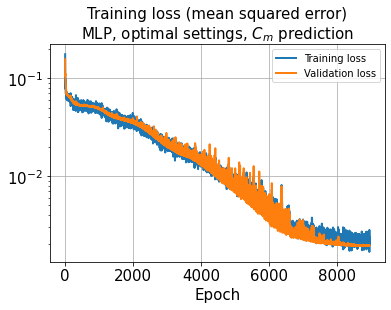

In [34]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

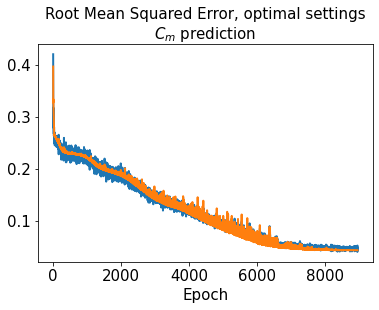

In [35]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

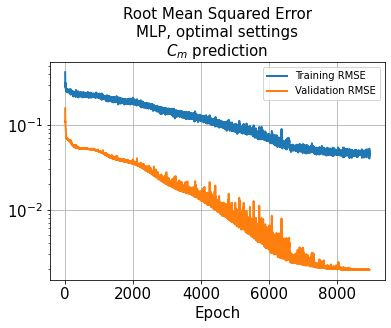

In [36]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [37]:
train_results = model.evaluate(x_train, y_train)

22/22 [==============================] - 0s 4ms/step - loss: 0.0022 - rmse: 0.0467


In [38]:
val_results = model.evaluate(x_val, y_val)

7/7 [==============================] - 0s 4ms/step - loss: 0.0019 - rmse: 0.0434


In [39]:
test_results = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 0.0021 - rmse: 0.0454


In [40]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

4/4 [==============================] - 0s 2ms/step


In [41]:
decoded_train_

array([[ 0.21118428],
       [ 0.22445367],
       [ 0.3405798 ],
       [ 0.28723717],
       [ 0.23427536],
       [ 0.3382407 ],
       [ 0.35721162],
       [ 0.26578254],
       [ 0.09016532],
       [ 0.33790687],
       [ 0.13910244],
       [ 0.25782034],
       [ 0.3417959 ],
       [ 0.2443632 ],
       [ 0.34181195],
       [ 0.21318813],
       [ 0.67032576],
       [ 0.35040215],
       [ 0.6339736 ],
       [ 0.18512528],
       [ 0.9644885 ],
       [ 0.5144103 ],
       [ 0.3607331 ],
       [ 0.73933923],
       [ 0.26443318],
       [ 0.26156425],
       [ 0.30142114],
       [ 0.48716623],
       [ 0.6208654 ],
       [ 0.13984999],
       [ 0.8586129 ],
       [ 0.3384178 ],
       [ 0.31217316],
       [ 0.34239098],
       [ 0.3415194 ],
       [ 0.2539725 ],
       [ 0.3509089 ],
       [ 0.21348287],
       [ 0.2952002 ],
       [ 0.3525921 ],
       [ 0.19673498],
       [ 0.3095746 ],
       [ 0.33762327],
       [ 0.8252971 ],
       [ 0.34242812],
       [ 0

In [42]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [43]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [44]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [45]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [46]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [47]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [48]:
model_directory = "D:\\TrainedModels\\20221226"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221226unsteadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState50_0.005_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [49]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [50]:
os.chdir(storage_dir)

In [51]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [52]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.1346729833806687
5.469966711216423


In [53]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.1197075723459146
4.68265741376049


In [54]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.13022086158880797
5.2767738761352385


In [55]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [56]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [57]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [58]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [59]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [60]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [61]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

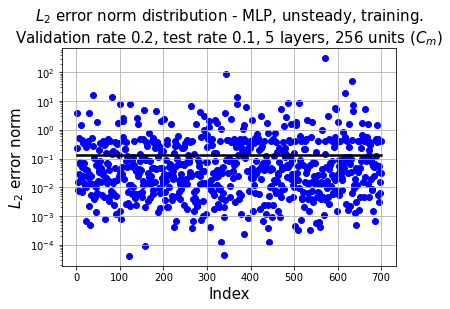

In [62]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

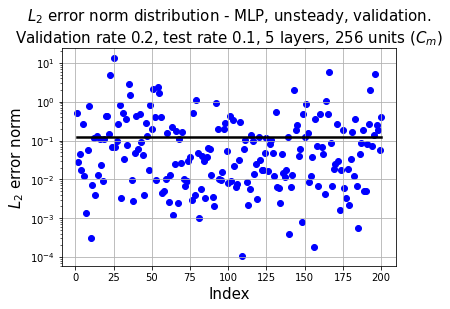

In [63]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

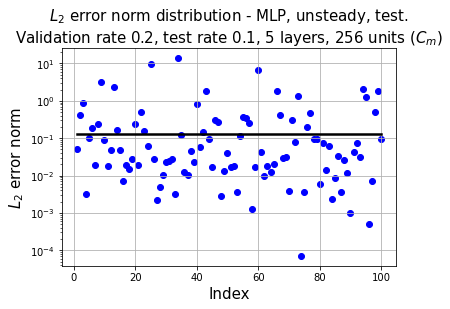

In [64]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [65]:
predicted = model.predict(x)

32/32 [==============================] - 0s 2ms/step


In [66]:
predicted.shape

(1000, 1)

In [67]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [68]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [69]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [70]:
x += 10

In [71]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x, denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.1026


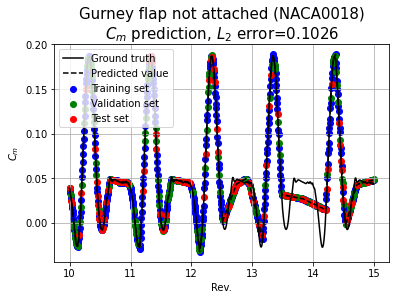

In [72]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0, 1):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted#[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tTest, iTrain, iTest)

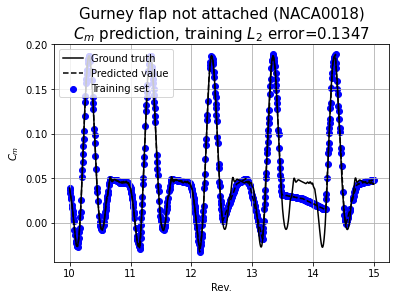

In [73]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, training $L_2$ error=%.4f' % l2_error_train
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

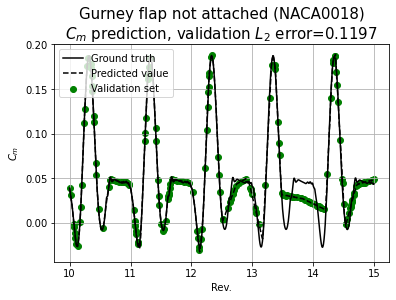

In [74]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, validation $L_2$ error=%.4f' % l2_error_val
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

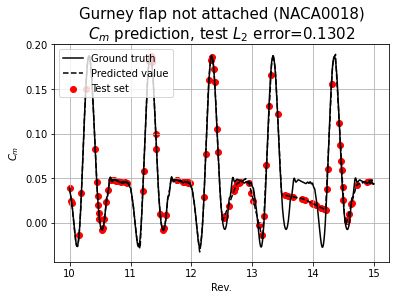

In [75]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, test $L_2$ error=%.4f' % l2_error_test
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()